# `Aadhaar Biometric Updates Dataset Analysis`

**Purpose**: To study biometric revalidation trends and lifecycle compliance, especially during adolescent transitions.

| **Attribute** | **Type** | **Description** | **Range/Format** |
| --- | --- | --- | --- |
| `date` | datetime | Biometric update date | YYYY-MM-DD |
| `state` | categorical | State or Union Territory | 28 states + 8 UTs |
| `district` | categorical | District-level unit | ~750 districts |
| `pincode` | categorical | 6-digit postal code | 100000-999999 |
| `bio_age_5_17` | integer | Biometric updates for age 5–17 | ≥ 0 |
| `bio_age_17_` | integer | Biometric updates for age 17+ | ≥ 0 |

**Usage in Project**:

- Evaluating biometric transition compliance
- Identifying regions with high biometric update stress
- Assessing lifecycle management effectiveness

## 1. INITIAL SETUP

### 1.1 Neccessary Imports

In [1]:
# ----statistic mesasures----
import pandas as pd
import numpy as np

# ----preprocessing & feature engineering----
from datetime import datetime

# ----ignore warnings----
import warnings
warnings.filterwarnings('ignore')

# ----Visualization Settings----
import matplotlib.pyplot as plt
import seaborn as sns

### 1.2 Visual Theming

In [2]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## 2. IMPORT DATA

In [3]:
# Load enrolment datasets
files = [
    "api_data_aadhar_biometric_0_500000.csv",
    "api_data_aadhar_biometric_500000_1000000.csv", 
    "api_data_aadhar_biometric_1000000_1500000.csv",
    "api_data_aadhar_biometric_1500000_1861108.csv"
]

# Read and combine
dfs = [pd.read_csv(f) for f in files]
df = pd.concat(dfs, ignore_index=True)

print(f"Enrolment dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Initial date range: {df['date'].min()} to {df['date'].max()}")

Enrolment dataset loaded: 1,861,108 rows × 6 columns
Initial date range: 01-03-2025 to 31-10-2025


### 2.1 Display basic information

In [4]:
# Display basic information
print("="*80)
print("BIOMETRIC UPDATE DATASET ANALYSIS")
print("="*80)
print(f"\nDataset Shape: {df.shape}")
print(f"\nColumn Information:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nColumn Descriptions:")
print(df.columns.tolist())

# Basic statistics
print("\nBasic Statistics:")
print(df.describe())

BIOMETRIC UPDATE DATASET ANALYSIS

Dataset Shape: (1861108, 6)

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1861108 entries, 0 to 1861107
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   date          object
 1   state         object
 2   district      object
 3   pincode       int64 
 4   bio_age_5_17  int64 
 5   bio_age_17_   int64 
dtypes: int64(3), object(3)
memory usage: 85.2+ MB
None

First 5 rows:
         date              state      district  pincode  bio_age_5_17  \
0  01-03-2025            Haryana  Mahendragarh   123029           280   
1  01-03-2025              Bihar     Madhepura   852121           144   
2  01-03-2025  Jammu and Kashmir         Punch   185101           643   
3  01-03-2025              Bihar       Bhojpur   802158           256   
4  01-03-2025         Tamil Nadu       Madurai   625514           271   

   bio_age_17_  
0          577  
1          369  
2         1091  
3          980  
4

## 3. Data Preparation Strategy

### Date Handling
- Converted the `date` column to **datetime format** using `DD-MM-YYYY`
- Extracted comprehensive temporal features to enable fine-grained time analysis:
  - `year`, `month`, `quarter`
  - `day_of_week`, `day_of_year`
  - `week_of_year` (ISO standard)
  - `month_year` (monthly aggregation period)

---

### Biometric Update Aggregation
- Computed **total biometric updates** per record:
  - `total_bio_updates = bio_age_5_17 + bio_age_17_`
- Represents overall biometric revalidation volume at the district–date level

---

### Age Group Distribution Analysis
- Calculated age-wise percentage contribution:
  - `pct_5_17`: Share of biometric updates from ages 5–17
  - `pct_17_plus`: Share of biometric updates from ages 17+
- Supports lifecycle compliance and adolescent transition analysis

---

### Derived Feature Engineering
- Created additional metrics to capture operational intensity:
  - `bio_update_intensity`: total biometric update volume
  - `youth_bio_ratio`: ratio of youth to adult biometric updates  
    - Division-by-zero handled safely
  - `bio_update_per_capita`: normalized biometric update indicator (proxy)

---

### Data Quality and Consistency Checks
- Replaced infinite values resulting from ratio calculations with nulls
- Imputed missing and invalid values with zero for modeling stability
- Ensured demographic totals align with constituent age groups

---

### Output for Analysis and Modeling
The finalized preprocessed dataset includes:
- Identifiers: `date`, `state`, `district`, `pincode`
- Temporal features: `year`, `month`, `quarter`, `day_of_week`, `day_of_year`, `week_of_year`, `month_year`
- Metrics: `total_bio_updates`, `pct_5_17`, `pct_17_plus`
- Derived indicators: `bio_update_intensity`, `youth_bio_ratio`, `bio_update_per_capita`

✅ The dataset is **cleaned, enriched, and fully prepared for exploratory analysis, temporal modeling, and policy-driven insights**.


In [5]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

# Extract temporal features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week
df['month_year'] = df['date'].dt.to_period('M')

# Calculate total biometric updates
df['total_bio_updates'] = df['bio_age_5_17'] + df['bio_age_17_']

# Calculate age group percentages
df['pct_5_17'] = (df['bio_age_5_17'] / df['total_bio_updates']) * 100
df['pct_17_plus'] = (df['bio_age_17_'] / df['total_bio_updates']) * 100

# Create derived metrics
df['bio_update_intensity'] = df['total_bio_updates']
df['youth_bio_ratio'] = df['bio_age_5_17'] / df['bio_age_17_'].replace(0, np.nan)
df['bio_update_per_capita'] = df['total_bio_updates']

# Handle any infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

# Create derived metrics
df['total_updates'] = df['bio_age_5_17'] + df['bio_age_17_']
df['child_adult_ratio'] = np.where(
    df['bio_age_17_'] > 0,
    df['bio_age_5_17'] / df['bio_age_17_'],
    np.nan  # Handle division by zero
)

# Display cleaned data info
print("\n" + "="*80)
print("DATA AFTER PREPROCESSING")
print("="*80)
print(f"\nDate Range: {df['date'].min()} to {df['date'].max()}")
print(f"Number of unique states: {df['state'].nunique()}")
print(f"Number of unique districts: {df['district'].nunique()}")
print(f"Number of unique pincodes: {df['pincode'].nunique()}")
print(f"Total biometric updates: {df['total_bio_updates'].sum():,}")

# Sample of processed data
print("\nSample of processed data:")
print(df[['date', 'state', 'district', 'total_bio_updates', 'pct_5_17', 'pct_17_plus']].head(10))


DATA AFTER PREPROCESSING

Date Range: 2025-03-01 00:00:00 to 2025-12-29 00:00:00
Number of unique states: 57
Number of unique districts: 974
Number of unique pincodes: 19707
Total biometric updates: 69,763,095

Sample of processed data:
        date              state      district  total_bio_updates   pct_5_17  \
0 2025-03-01            Haryana  Mahendragarh                857  32.672112   
1 2025-03-01              Bihar     Madhepura                513  28.070175   
2 2025-03-01  Jammu and Kashmir         Punch               1734  37.081892   
3 2025-03-01              Bihar       Bhojpur               1236  20.711974   
4 2025-03-01         Tamil Nadu       Madurai               1086  24.953959   
5 2025-03-01        Maharashtra     Ratnagiri                684  22.660819   
6 2025-03-01            Gujarat         Anand                218  34.403670   
7 2025-03-01            Gujarat   Gandhinagar                490  39.183673   
8 2025-03-01             Odisha     Dhenkanal      

In [6]:
# Aggregate to district-month level (operational decision unit)
district_month = df.groupby(['state', 'district', 'month']).agg({
    'total_updates': 'sum',
    'bio_age_5_17': 'sum',
    'bio_age_17_': 'sum',
    'child_adult_ratio': 'mean'
}).reset_index()

# Add derived metrics at aggregate level
district_month['updates_per_day'] = district_month['total_updates'] / 30  # Approximate
district_month['is_high_volume'] = district_month['total_updates'] > district_month['total_updates'].median()

print(f"📈 District-month aggregates: {district_month.shape[0]:,} records")
display(district_month.head())

📈 District-month aggregates: 8,507 records


,state,district,month,total_updates,bio_age_5_17,bio_age_17_,child_adult_ratio,updates_per_day,is_high_volume
0,Andaman & Nicobar Islands,Andamans,3,209,16,193,0.082902,6.966667,False
1,Andaman & Nicobar Islands,Andamans,4,184,17,167,0.101796,6.133333,False
2,Andaman & Nicobar Islands,Andamans,5,180,22,158,0.213542,6.000000,False
3,Andaman & Nicobar Islands,Andamans,6,140,11,129,0.085271,4.666667,False
4,Andaman & Nicobar Islands,Andamans,7,259,20,239,0.083682,8.633333,False


## 4. EDA: Exploratory Data Analysis

### 4.1 Monthly Enrolment Trends and Seasonal Pattern Analysis

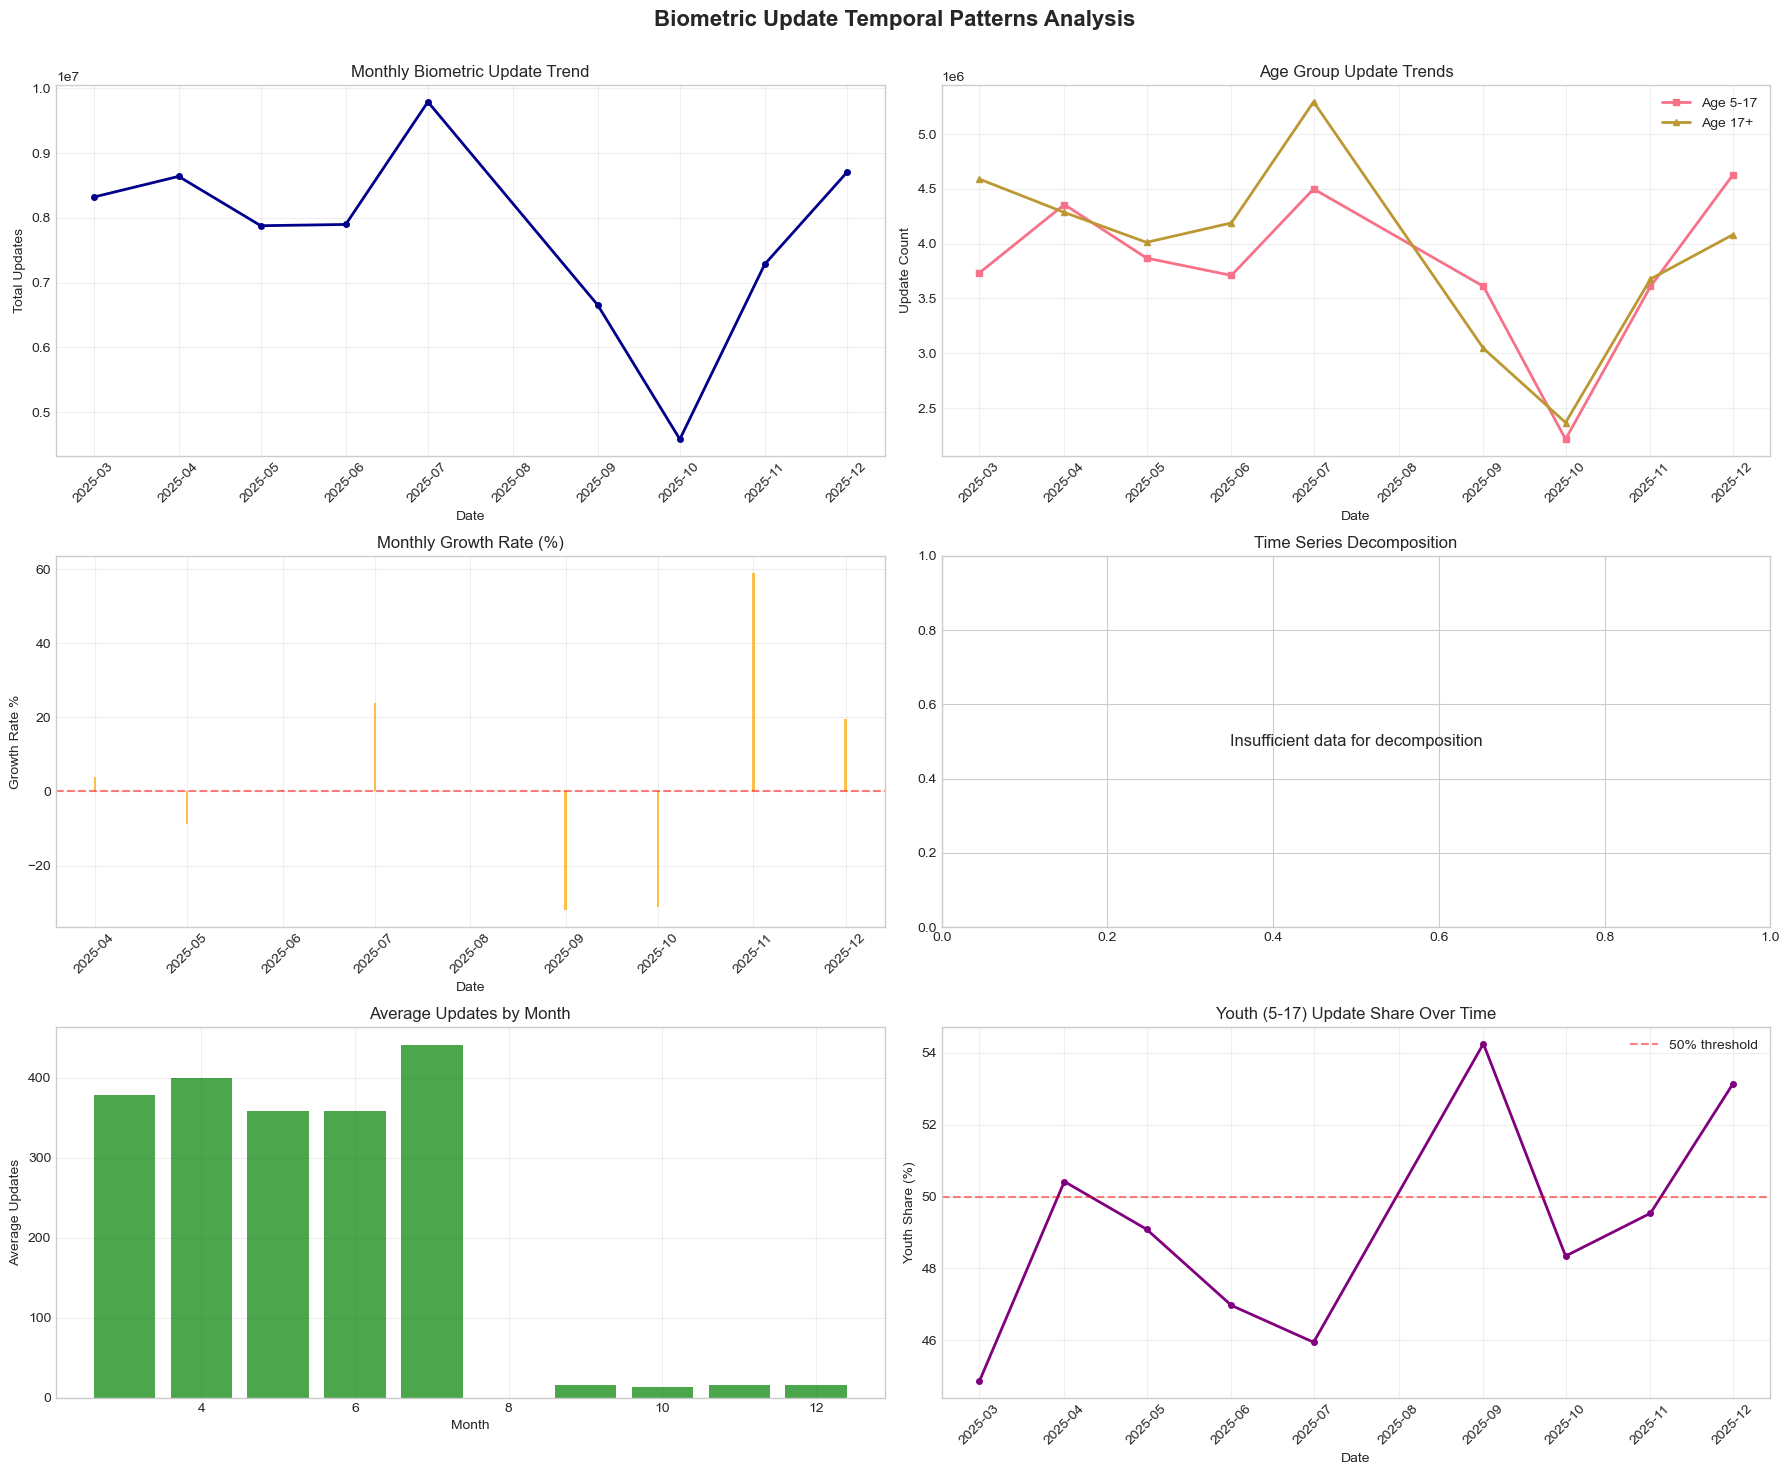


TEMPORAL ANALYSIS METRICS
Average Monthly Growth Rate: 4.31%
Monthly Volatility (Std of Growth): 30.17%
Peak Update Month: 2025-07-01 00:00:00
Seasonal Strength: 0.890
Youth Update Trend: Increasing


In [7]:
# Monthly trend analysis
monthly_bio_trend = df.groupby(['year', 'month']).agg({
    'total_bio_updates': 'sum',
    'bio_age_5_17': 'sum',
    'bio_age_17_': 'sum'
}).reset_index()

monthly_bio_trend['month_year'] = pd.to_datetime(
    monthly_bio_trend['year'].astype(str) + '-' + monthly_bio_trend['month'].astype(str) + '-01'
)

# Calculate growth metrics
monthly_bio_trend['bio_growth_rate'] = monthly_bio_trend['total_bio_updates'].pct_change() * 100
monthly_bio_trend['youth_bio_share'] = (monthly_bio_trend['bio_age_5_17'] / 
                                       monthly_bio_trend['total_bio_updates']) * 100

# Create comprehensive temporal analysis
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
fig.suptitle('Biometric Update Temporal Patterns Analysis', fontsize=16, fontweight='bold')

# Plot 1: Overall trend
axes[0, 0].plot(monthly_bio_trend['month_year'], monthly_bio_trend['total_bio_updates'], 
                marker='o', linewidth=2, color='darkblue', markersize=4)
axes[0, 0].set_title('Monthly Biometric Update Trend', fontsize=12)
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Total Updates')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Age group trends
axes[0, 1].plot(monthly_bio_trend['month_year'], monthly_bio_trend['bio_age_5_17'], 
                label='Age 5-17', linewidth=2, marker='s', markersize=4)
axes[0, 1].plot(monthly_bio_trend['month_year'], monthly_bio_trend['bio_age_17_'], 
                label='Age 17+', linewidth=2, marker='^', markersize=4)
axes[0, 1].set_title('Age Group Update Trends', fontsize=12)
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Update Count')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Growth rate
axes[1, 0].bar(monthly_bio_trend['month_year'], monthly_bio_trend['bio_growth_rate'], 
               alpha=0.7, color='orange')
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1, 0].set_title('Monthly Growth Rate (%)', fontsize=12)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Growth Rate %')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Seasonal decomposition
try:
    bio_series = monthly_bio_trend.set_index('month_year')['total_bio_updates']
    decomposition = seasonal_decompose(bio_series, model='additive', period=12)
    
    axes[1, 1].plot(decomposition.trend, label='Trend', linewidth=2)
    axes[1, 1].plot(decomposition.seasonal, label='Seasonal', alpha=0.7)
    axes[1, 1].plot(decomposition.resid, label='Residual', alpha=0.5)
    axes[1, 1].set_title('Time Series Decomposition', fontsize=12)
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Updates')
    axes[1, 1].legend()
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
except:
    axes[1, 1].text(0.5, 0.5, 'Insufficient data for decomposition', 
                    ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('Time Series Decomposition', fontsize=12)

# Plot 5: Monthly patterns
monthly_pattern = df.groupby('month').agg({
    'total_bio_updates': 'mean',
    'bio_age_5_17': 'mean',
    'bio_age_17_': 'mean'
})
axes[2, 0].bar(monthly_pattern.index, monthly_pattern['total_bio_updates'], 
               alpha=0.7, color='green')
axes[2, 0].set_title('Average Updates by Month', fontsize=12)
axes[2, 0].set_xlabel('Month')
axes[2, 0].set_ylabel('Average Updates')
axes[2, 0].grid(True, alpha=0.3)

# Plot 6: Youth share trend
axes[2, 1].plot(monthly_bio_trend['month_year'], monthly_bio_trend['youth_bio_share'],
                color='purple', linewidth=2, marker='o', markersize=4)
axes[2, 1].axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50% threshold')
axes[2, 1].set_title('Youth (5-17) Update Share Over Time', fontsize=12)
axes[2, 1].set_xlabel('Date')
axes[2, 1].set_ylabel('Youth Share (%)')
axes[2, 1].legend()
axes[2, 1].tick_params(axis='x', rotation=45)
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# Calculate key temporal metrics
print("\n" + "="*80)
print("TEMPORAL ANALYSIS METRICS")
print("="*80)

monthly_volatility = monthly_bio_trend['bio_growth_rate'].std()
avg_monthly_growth = monthly_bio_trend['bio_growth_rate'].mean()
peak_month = monthly_bio_trend.loc[monthly_bio_trend['total_bio_updates'].idxmax(), 'month_year']

print(f"Average Monthly Growth Rate: {avg_monthly_growth:.2f}%")
print(f"Monthly Volatility (Std of Growth): {monthly_volatility:.2f}%")
print(f"Peak Update Month: {peak_month}")
print(f"Seasonal Strength: {monthly_pattern['total_bio_updates'].std()/monthly_pattern['total_bio_updates'].mean():.3f}")
print(f"Youth Update Trend: {'Increasing' if np.polyfit(range(len(monthly_bio_trend)), monthly_bio_trend['youth_bio_share'], 1)[0] > 0 else 'Decreasing'}")

### 4.2 Understanding Biometric Update Patterns
We analyze distribution, trends, and anomalies to identify:
1. Overall system health
2. Geographic hotspots
3. Age-group dynamics
4. Temporal patterns

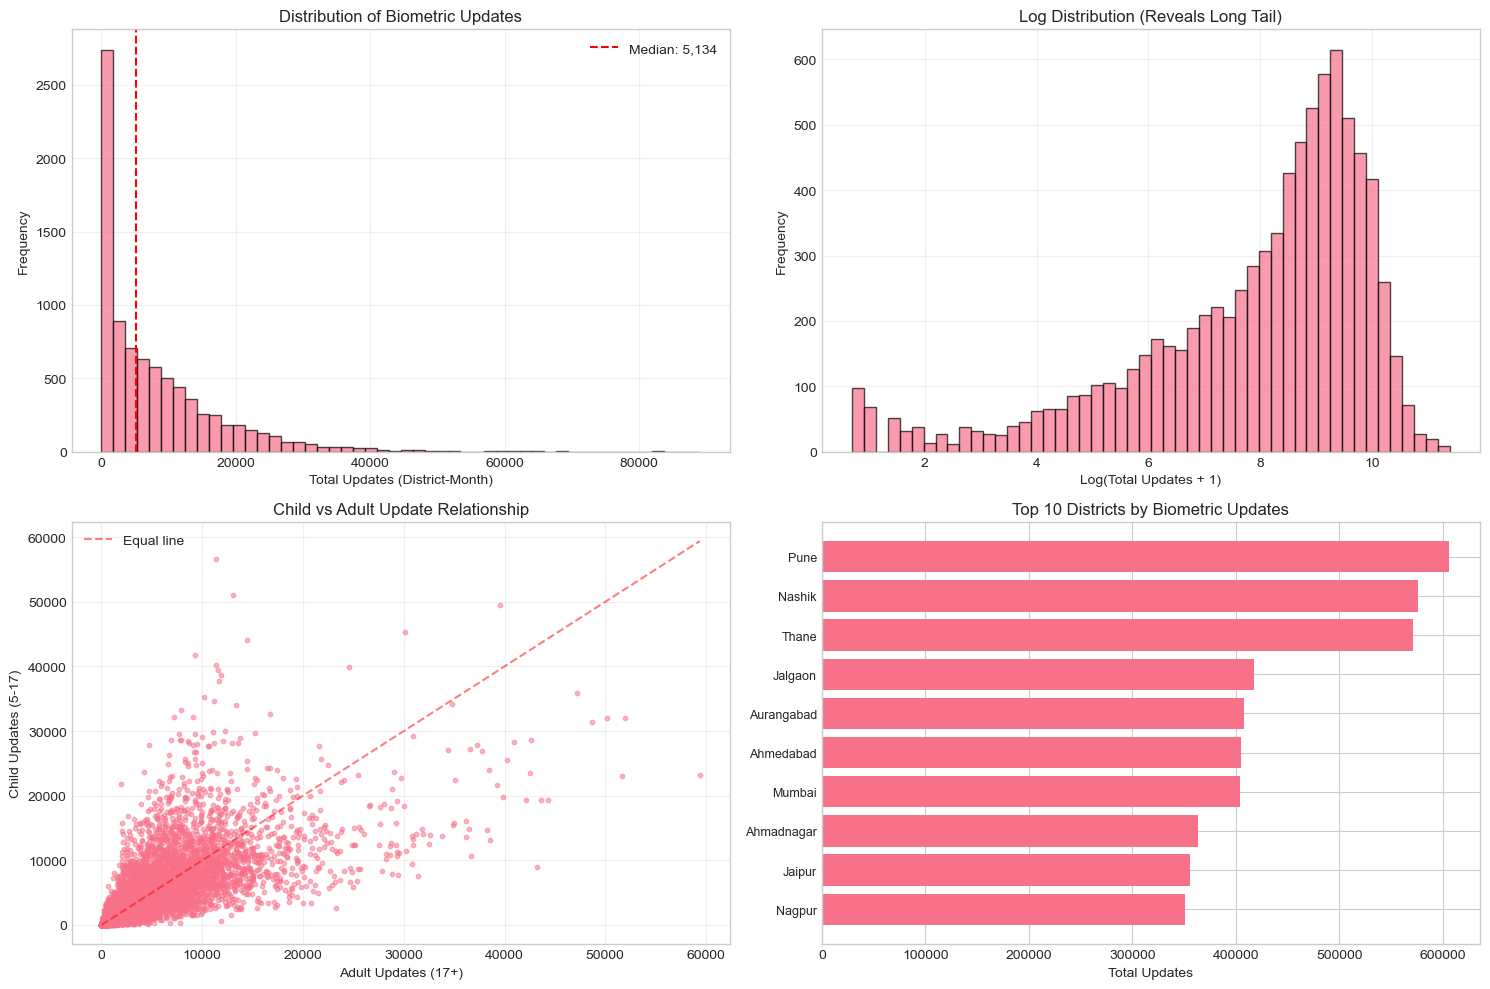

📊 KEY STATISTICS (District-Month Level):
Mean updates: 8,201
Median updates: 5,134
Std deviation: 9,581
Skewness: 2.15
Maximum: 89,018
75th percentile: 12,012
25th percentile: 963
IQR: 11,050

💡 Interpretation: Mean > Median indicates right skew - a few districts account for disproportionate volume.


In [8]:
# Create a 2x2 visualization grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Total updates distribution
axes[0, 0].hist(district_month['total_updates'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(district_month['total_updates'].median(), color='red', linestyle='--', 
                   label=f'Median: {district_month["total_updates"].median():,.0f}')
axes[0, 0].set_xlabel('Total Updates (District-Month)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Biometric Updates')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Log-scale distribution (reveals skewness)
axes[0, 1].hist(np.log1p(district_month['total_updates']), bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Log(Total Updates + 1)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Log Distribution (Reveals Long Tail)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Child vs Adult updates scatter
axes[1, 0].scatter(district_month['bio_age_17_'], district_month['bio_age_5_17'], 
                   alpha=0.5, s=10)
axes[1, 0].plot([0, district_month['bio_age_17_'].max()], 
                [0, district_month['bio_age_17_'].max()], 
                'r--', alpha=0.5, label='Equal line')
axes[1, 0].set_xlabel('Adult Updates (17+)')
axes[1, 0].set_ylabel('Child Updates (5-17)')
axes[1, 0].set_title('Child vs Adult Update Relationship')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Top 10 districts by total updates
top_districts = district_month.groupby('district')['total_updates'].sum().nlargest(10)
axes[1, 1].barh(range(len(top_districts)), top_districts.values)
axes[1, 1].set_yticks(range(len(top_districts)))
axes[1, 1].set_yticklabels(top_districts.index, fontsize=9)
axes[1, 1].set_xlabel('Total Updates')
axes[1, 1].set_title('Top 10 Districts by Biometric Updates')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=150, bbox_inches='tight')
plt.show()

# Print key statistics
print("📊 KEY STATISTICS (District-Month Level):")
print("=" * 50)
print(f"Mean updates: {district_month['total_updates'].mean():,.0f}")
print(f"Median updates: {district_month['total_updates'].median():,.0f}")
print(f"Std deviation: {district_month['total_updates'].std():,.0f}")
print(f"Skewness: {district_month['total_updates'].skew():.2f}")
print(f"Maximum: {district_month['total_updates'].max():,.0f}")
print(f"75th percentile: {district_month['total_updates'].quantile(0.75):,.0f}")
print(f"25th percentile: {district_month['total_updates'].quantile(0.25):,.0f}")
print(f"IQR: {district_month['total_updates'].quantile(0.75) - district_month['total_updates'].quantile(0.25):,.0f}")
print("\n💡 Interpretation: Mean > Median indicates right skew - a few districts account for disproportionate volume.")

### 4.3 State-wise Analysis of Aadhaar Demographic Updates

In [9]:
print("Starting state-wise analysis of biometric updates...")
print(f"Date Range: {df['date'].min()} to {df['date'].max()}")
print(f"Total biometric updates: {df['total_bio_updates'].sum():,}")
print(f"Number of unique states: {df['state'].nunique()}")

# Define month names for better readability
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Starting state-wise analysis of biometric updates...
Date Range: 2025-03-01 00:00:00 to 2025-12-29 00:00:00
Total biometric updates: 69,763,095
Number of unique states: 57


#### 4.3.1. [ STATE-LEVEL SUMMARY STATISTICS  ]

This section provides aggregated statistics for each state, including total updates, daily averages, and key metrics.

In [10]:
print("\n" + "="*100)
print("1. STATE-LEVEL SUMMARY STATISTICS FOR BIOMETRIC UPDATES")
print("="*100)

# Group by state for aggregated analysis
state_analysis = df.groupby('state').agg({
    'total_bio_updates': ['sum', 'mean', 'std', 'count'],
    'bio_age_5_17': 'sum',
    'bio_age_17_': 'sum',
    'pct_5_17': 'mean',
    'pct_17_plus': 'mean',
    'youth_bio_ratio': 'mean',
    'date': 'nunique',  # Number of days with updates
    'pincode': 'nunique'  # Number of unique pincodes
}).round(2)

# Flatten multi-index columns
state_analysis.columns = ['_'.join(col).strip() for col in state_analysis.columns.values]
state_analysis = state_analysis.reset_index()

# Rename for clarity
state_analysis.rename(columns={
    'total_bio_updates_sum': 'total_updates',
    'total_bio_updates_mean': 'avg_daily_updates',
    'total_bio_updates_std': 'std_daily_updates',
    'total_bio_updates_count': 'records_count',
    'bio_age_5_17_sum': 'total_5_17',
    'bio_age_17__sum': 'total_17_plus',
    'pct_5_17_mean': 'avg_pct_5_17',
    'pct_17_plus_mean': 'avg_pct_17_plus',
    'youth_bio_ratio_mean': 'avg_youth_bio_ratio',
    'date_nunique': 'active_days',
    'pincode_nunique': 'unique_pincodes'
}, inplace=True)

# Calculate additional metrics
state_analysis['updates_per_active_day'] = state_analysis['total_updates'] / state_analysis['active_days']
state_analysis['updates_per_pincode'] = state_analysis['total_updates'] / state_analysis['unique_pincodes']
state_analysis['records_per_day'] = state_analysis['records_count'] / state_analysis['active_days']

# Calculate consistency score (handling division by zero)
state_analysis['consistency_score'] = 1 - (state_analysis['std_daily_updates'] / state_analysis['avg_daily_updates'].replace(0, np.nan))
state_analysis['consistency_score'] = state_analysis['consistency_score'].clip(lower=0, upper=1)

# Calculate coverage percentage
total_days_in_period = df['date'].nunique()
state_analysis['coverage_percentage'] = (state_analysis['active_days'] / total_days_in_period) * 100

print(f"\nTotal states analyzed: {len(state_analysis)}")
print(f"Total biometric updates: {state_analysis['total_updates'].sum():,}")


1. STATE-LEVEL SUMMARY STATISTICS FOR BIOMETRIC UPDATES

Total states analyzed: 57
Total biometric updates: 69,763,095


#### 4.3.2 [ TOP/BOTTOM PERFORMING STATES ]

In [11]:
print("\n" + "="*100)
print("2. TOP/BOTTOM PERFORMING STATES BY BIOMETRIC UPDATES")
print("="*100)

print("\nTOP 10 STATES BY TOTAL BIOMETRIC UPDATES:")
top_states = state_analysis.nlargest(10, 'total_updates')[['state', 'total_updates', 'avg_daily_updates', 'active_days', 'unique_pincodes']]
print(top_states.to_string(index=False))

print("\nBOTTOM 10 STATES BY TOTAL BIOMETRIC UPDATES:")
bottom_states = state_analysis.nsmallest(10, 'total_updates')[['state', 'total_updates', 'avg_daily_updates', 'active_days', 'unique_pincodes']]
print(bottom_states.to_string(index=False))

print("\nTOP 10 STATES BY UPDATE INTENSITY (Updates per Active Day):")
intensity_states = state_analysis.nlargest(10, 'updates_per_active_day')[['state', 'updates_per_active_day', 'total_updates', 'active_days']]
print(intensity_states.to_string(index=False))


2. TOP/BOTTOM PERFORMING STATES BY BIOMETRIC UPDATES

TOP 10 STATES BY TOTAL BIOMETRIC UPDATES:
         state  total_updates  avg_daily_updates  active_days  unique_pincodes
 Uttar Pradesh        9577735              61.70           89             1753
   Maharashtra        9226139              61.06           89             1607
Madhya Pradesh        5923771              84.53           89              797
         Bihar        4897587              58.73           89              917
    Tamil Nadu        4698117              25.45           89             2088
     Rajasthan        3994955              50.11           89              986
Andhra Pradesh        3714592              21.59           88             1847
       Gujarat        3196514              35.70           89             1026
  Chhattisgarh        2648729              82.79           89              269
     Karnataka        2635954              18.66           89             1353

BOTTOM 10 STATES BY TOTAL BIOMETR

#### 4.3.3 [ AGE GROUP ANALYSIS BY STATE ]

In [12]:
print("\n" + "="*100)
print("3. AGE GROUP ANALYSIS FOR BIOMETRIC UPDATES BY STATE")
print("="*100)

print("\nTOP 10 STATES WITH HIGHEST YOUTH (5-17) BIOMETRIC UPDATE PERCENTAGE:")
top_youth_states = state_analysis.nlargest(10, 'avg_pct_5_17')[['state', 'avg_pct_5_17', 'total_5_17', 'total_updates']]
print(top_youth_states.to_string(index=False))

print("\nTOP 10 STATES WITH HIGHEST ADULT (17+) BIOMETRIC UPDATE PERCENTAGE:")
top_adult_states = state_analysis.nlargest(10, 'avg_pct_17_plus')[['state', 'avg_pct_17_plus', 'total_17_plus', 'total_updates']]
print(top_adult_states.to_string(index=False))

print("\nSTATES WITH HIGHEST YOUTH-ADULT BIOMETRIC UPDATE RATIO (>1 indicates more youth updates):")
high_ratio_states = state_analysis[state_analysis['avg_youth_bio_ratio'] > 1].nlargest(10, 'avg_youth_bio_ratio')
print(high_ratio_states[['state', 'avg_youth_bio_ratio', 'avg_pct_5_17', 'avg_pct_17_plus']].to_string(index=False))

# Categorize states by biometric update age focus
state_analysis['bio_age_focus'] = np.where(
    state_analysis['avg_pct_5_17'] > 60, 'Youth Focused',
    np.where(
        state_analysis['avg_pct_17_plus'] > 60, 'Adult Focused',
        'Balanced'
    )
)

print("\nSTATE BIOMETRIC UPDATE AGE FOCUS:")
bio_focus_dist = state_analysis['bio_age_focus'].value_counts()
for focus, count in bio_focus_dist.items():
    percentage = (count / len(state_analysis)) * 100
    print(f"  {focus}: {count} states ({percentage:.1f}%)")


3. AGE GROUP ANALYSIS FOR BIOMETRIC UPDATES BY STATE

TOP 10 STATES WITH HIGHEST YOUTH (5-17) BIOMETRIC UPDATE PERCENTAGE:
                      state  avg_pct_5_17  total_5_17  total_updates
                  Tamilnadu        100.00           1              1
                west Bengal        100.00           1              1
          Arunachal Pradesh         64.45       42894          72394
Andaman and Nicobar Islands         63.87       11401          18314
                    Mizoram         60.92       85531         120329
              Uttar Pradesh         60.26     6207105        9577735
              Daman and Diu         60.20        4215           6763
                 Puducherry         59.85       21828          42321
                    Manipur         59.23      166465         282587
                      Assam         59.19      596624         982722

TOP 10 STATES WITH HIGHEST ADULT (17+) BIOMETRIC UPDATE PERCENTAGE:
                    state  avg_pct_17_plus  tota

#### 4.3.4 [ UPDATE CONSISTENCY AND ACTIVITY ANALYSIS ]

In [13]:
print("\n" + "="*100)
print("4. BIOMETRIC UPDATE CONSISTENCY AND ACTIVITY ANALYSIS")
print("="*100)

print("\nMOST CONSISTENT STATES (Lowest Daily Variability):")
consistent_states = state_analysis[state_analysis['records_count'] > 10].nsmallest(10, 'std_daily_updates')
print(consistent_states[['state', 'avg_daily_updates', 'std_daily_updates', 'consistency_score']].to_string(index=False))

print("\nSTATES WITH HIGHEST ACTIVITY DENSITY (Records per Day):")
active_states = state_analysis.nlargest(10, 'records_per_day')[['state', 'records_per_day', 'records_count', 'active_days']]
print(active_states.to_string(index=False))

print("\nSTATES WITH HIGHEST BIOMETRIC UPDATE COVERAGE (% of Days with Updates):")
coverage_states = state_analysis.nlargest(10, 'coverage_percentage')[['state', 'coverage_percentage', 'active_days', 'total_updates']]
print(coverage_states.to_string(index=False))


4. BIOMETRIC UPDATE CONSISTENCY AND ACTIVITY ANALYSIS

MOST CONSISTENT STATES (Lowest Daily Variability):
          state  avg_daily_updates  std_daily_updates  consistency_score
         odisha               1.00               0.00           1.000000
   West  Bengal               1.04               0.19           0.817308
    West Bangal               1.06               0.24           0.773585
     Westbengal               1.06               0.24           0.773585
    WEST BENGAL               1.09               0.29           0.733945
     WESTBENGAL               1.09               0.30           0.724771
    West bengal               1.11               0.32           0.711712
         ODISHA               1.17               0.38           0.675214
Jammu & Kashmir               1.16               0.42           0.637931
 andhra pradesh               1.32               0.60           0.545455

STATES WITH HIGHEST ACTIVITY DENSITY (Records per Day):
         state  records_per_day  

#### 4.2.5 [ GEOGRAPHIC COVERAGE ANALYSIS ]

In [14]:
print("\n" + "="*100)
print("5. GEOGRAPHIC COVERAGE ANALYSIS FOR BIOMETRIC UPDATES")
print("="*100)

print("\nSTATES WITH WIDEST GEOGRAPHIC COVERAGE (Most Pincodes):")
wide_coverage = state_analysis.nlargest(10, 'unique_pincodes')[['state', 'unique_pincodes', 'updates_per_pincode', 'total_updates']]
print(wide_coverage.to_string(index=False))

print("\nSTATES WITH HIGHEST BIOMETRIC UPDATE DENSITY (Updates per Pincode):")
high_density = state_analysis.nlargest(10, 'updates_per_pincode')[['state', 'updates_per_pincode', 'unique_pincodes', 'total_updates']]
print(high_density.to_string(index=False))

# Calculate geographic efficiency score
state_analysis['geo_efficiency'] = (state_analysis['updates_per_pincode'] / state_analysis['updates_per_pincode'].max()) * 100

print("\nSTATES WITH HIGHEST GEOGRAPHIC EFFICIENCY:")
geo_efficient = state_analysis.nlargest(10, 'geo_efficiency')[['state', 'geo_efficiency', 'updates_per_pincode', 'unique_pincodes']]
print(geo_efficient.to_string(index=False))


5. GEOGRAPHIC COVERAGE ANALYSIS FOR BIOMETRIC UPDATES

STATES WITH WIDEST GEOGRAPHIC COVERAGE (Most Pincodes):
         state  unique_pincodes  updates_per_pincode  total_updates
    Tamil Nadu             2088          2250.056034        4698117
Andhra Pradesh             1847          2011.148890        3714592
 Uttar Pradesh             1753          5463.625214        9577735
   Maharashtra             1607          5741.219042        9226139
        Kerala             1418          1135.211566        1609730
   West Bengal             1354          1864.437223        2524448
     Karnataka             1353          1948.229120        2635954
       Gujarat             1026          3115.510721        3196514
     Rajasthan              986          4051.678499        3994955
        Odisha              940          2556.198936        2402827

STATES WITH HIGHEST BIOMETRIC UPDATE DENSITY (Updates per Pincode):
                 state  updates_per_pincode  unique_pincodes  total_upd

#### 4.2.6 [ TEMPORAL PATTERNS BY STATE ]

In [15]:
print("\n" + "="*100)
print("6. TEMPORAL PATTERNS FOR BIOMETRIC UPDATES BY STATE")
print("="*100)

# Yearly biometric updates by state
yearly_state = df.groupby(['state', 'year']).agg({
    'total_bio_updates': 'sum',
    'bio_age_5_17': 'sum',
    'bio_age_17_': 'sum'
}).reset_index()

# Calculate yearly growth rates
yearly_state = yearly_state.sort_values(['state', 'year'])
yearly_state['prev_year_updates'] = yearly_state.groupby('state')['total_bio_updates'].shift(1)
yearly_state['yoy_growth'] = np.where(
    yearly_state['prev_year_updates'] > 0,
    ((yearly_state['total_bio_updates'] - yearly_state['prev_year_updates']) / 
     yearly_state['prev_year_updates']) * 100,
    np.nan
)

print("\nSTATES WITH HIGHEST YEAR-OVER-YEAR GROWTH IN BIOMETRIC UPDATES (Latest Year):")
latest_year = yearly_state['year'].max()
latest_year_data = yearly_state[yearly_state['year'] == latest_year].copy()
valid_growth_data = latest_year_data[latest_year_data['yoy_growth'].notna()]

if not valid_growth_data.empty:
    top_growth_states = valid_growth_data.nlargest(10, 'yoy_growth')[['state', 'total_bio_updates', 'yoy_growth']]
    print(top_growth_states.to_string(index=False))
else:
    print("No valid YoY growth data available")

# Monthly pattern analysis by state
monthly_state = df.groupby(['state', 'month']).agg({
    'total_bio_updates': 'sum'
}).reset_index()

# Find peak month for each state
peak_month_by_state = monthly_state.loc[monthly_state.groupby('state')['total_bio_updates'].idxmax()]
peak_month_by_state['month_name'] = peak_month_by_state['month'].apply(lambda x: month_names[x-1])

print("\nSTATES AND THEIR PEAK BIOMETRIC UPDATE MONTHS (Top 10 by Total Updates):")
top_states_peak = peak_month_by_state[peak_month_by_state['state'].isin(top_states['state'].head(10))]
print(top_states_peak[['state', 'month_name', 'total_bio_updates']].to_string(index=False))


6. TEMPORAL PATTERNS FOR BIOMETRIC UPDATES BY STATE

STATES WITH HIGHEST YEAR-OVER-YEAR GROWTH IN BIOMETRIC UPDATES (Latest Year):
No valid YoY growth data available

STATES AND THEIR PEAK BIOMETRIC UPDATE MONTHS (Top 10 by Total Updates):
         state month_name  total_bio_updates
Andhra Pradesh        Apr             608589
         Bihar        Apr             795719
  Chhattisgarh        Dec             524212
       Gujarat        Jul             541874
     Karnataka        Jul             374362
Madhya Pradesh        Jul            1004035
   Maharashtra        Jul            1230369
     Rajasthan        Sep             690966
    Tamil Nadu        Mar             680675
 Uttar Pradesh        Jul            1426001


#### 4.2.7 [ PERFORMANCE CLUSTERING AND CATEGORIZATION ]

In [16]:
print("\n" + "="*100)
print("7. BIOMETRIC UPDATE PERFORMANCE CLUSTERING AND CATEGORIZATION")
print("="*100)

# Create comprehensive performance score
state_analysis['performance_score'] = (
    (state_analysis['total_updates'] / state_analysis['total_updates'].max()) * 0.2 +
    (state_analysis['updates_per_active_day'] / state_analysis['updates_per_active_day'].max()) * 0.2 +
    state_analysis['consistency_score'] * 0.2 +
    (state_analysis['coverage_percentage'] / 100) * 0.2 +
    (state_analysis['geo_efficiency'] / 100) * 0.2
)

# Fill NaN performance scores with 0
state_analysis['performance_score'] = state_analysis['performance_score'].fillna(0)

# Categorize states into performance tiers
state_analysis['performance_tier'] = pd.qcut(state_analysis['performance_score'], 
                                            q=5, 
                                            labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

print("\nBIOMETRIC UPDATE PERFORMANCE TIER DISTRIBUTION:")
tier_distribution = state_analysis['performance_tier'].value_counts().sort_index()
for tier, count in tier_distribution.items():
    percentage = (count / len(state_analysis)) * 100
    print(f"  {tier}: {count} states ({percentage:.1f}%)")

# Display states in each tier
print("\nSTATES BY BIOMETRIC UPDATE PERFORMANCE TIER:")
for tier in ['Very High', 'High', 'Medium', 'Low', 'Very Low']:
    states_in_tier = state_analysis[state_analysis['performance_tier'] == tier]['state'].tolist()
    if states_in_tier:
        print(f"\n{tier} Performance ({len(states_in_tier)} states):")
        print(f"  {', '.join(states_in_tier[:10])}{'...' if len(states_in_tier) > 10 else ''}")


7. BIOMETRIC UPDATE PERFORMANCE CLUSTERING AND CATEGORIZATION

BIOMETRIC UPDATE PERFORMANCE TIER DISTRIBUTION:
  Very Low: 12 states (21.1%)
  Low: 11 states (19.3%)
  Medium: 11 states (19.3%)
  High: 11 states (19.3%)
  Very High: 12 states (21.1%)

STATES BY BIOMETRIC UPDATE PERFORMANCE TIER:

Very High Performance (12 states):
  Andhra Pradesh, Bihar, Chhattisgarh, Delhi, Gujarat, Haryana, Jharkhand, Madhya Pradesh, Maharashtra, Rajasthan...

High Performance (11 states):
  Dadra and Nagar Haveli, Jammu & Kashmir, Jammu and Kashmir, Karnataka, Kerala, Manipur, Odisha, Punjab, Telangana, Uttarakhand...

Medium Performance (11 states):
  Arunachal Pradesh, Assam, Chandigarh, Himachal Pradesh, Meghalaya, Mizoram, Nagaland, Puducherry, Tripura, West Bangal...

Low Performance (11 states):
  Andaman and Nicobar Islands, Chhatisgarh, Daman and Diu, Goa, Ladakh, Orissa, Pondicherry, Sikkim, Uttaranchal, WEST BENGAL...

Very Low Performance (12 states):
  Andaman & Nicobar Islands, Dadra 

#### 4.2.8 [ GEOGRAPHIC CONCENTRATION ANALYSIS ]

In [17]:
# ===================================================
# 8. GEOGRAPHIC CONCENTRATION ANALYSIS
# ===================================================

print("\n" + "="*100)
print("8. GEOGRAPHIC CONCENTRATION OF BIOMETRIC UPDATES")
print("="*100)

# Calculate concentration metrics
total_national_updates = state_analysis['total_updates'].sum()
state_analysis['national_share'] = (state_analysis['total_updates'] / total_national_updates) * 100

# Sort by national share for cumulative calculation
state_analysis_sorted = state_analysis.sort_values('national_share', ascending=False).reset_index(drop=True)
state_analysis_sorted['cumulative_share'] = state_analysis_sorted['national_share'].cumsum()

# Find states that make up 80% of biometric updates
states_80_percent = state_analysis_sorted[state_analysis_sorted['cumulative_share'] <= 80]
states_50_percent = state_analysis_sorted[state_analysis_sorted['cumulative_share'] <= 50]

print(f"\nGEOGRAPHIC CONCENTRATION OF BIOMETRIC UPDATES:")
print(f"- Top {len(states_50_percent)} states account for 50% of all biometric updates")
print(f"- Top {len(states_80_percent)} states account for 80% of all biometric updates")
print(f"- Top state: {state_analysis_sorted.iloc[0]['state']} ({state_analysis_sorted.iloc[0]['national_share']:.1f}% of total)")

# Calculate HHI index for concentration
state_shares = state_analysis_sorted['national_share']
hhi = (state_shares ** 2).sum()
print(f"- HHI Index: {hhi:.2f}")
if hhi < 1500:
    print("  (Market: Unconcentrated)")
elif hhi < 2500:
    print("  (Market: Moderately concentrated)")
else:
    print("  (Market: Highly concentrated)")


8. GEOGRAPHIC CONCENTRATION OF BIOMETRIC UPDATES

GEOGRAPHIC CONCENTRATION OF BIOMETRIC UPDATES:
- Top 5 states account for 50% of all biometric updates
- Top 12 states account for 80% of all biometric updates
- Top state: Uttar Pradesh (13.7% of total)
- HHI Index: 706.34
  (Market: Unconcentrated)


#### 4.2.9 [ CORRELATION ANALYSIS ]

In [18]:
print("\n" + "="*100)
print("9. CORRELATION ANALYSIS FOR BIOMETRIC UPDATE METRICS")
print("="*100)

# Calculate correlations between key metrics
correlation_metrics = ['total_updates', 'avg_daily_updates', 'std_daily_updates',
                      'avg_pct_5_17', 'avg_pct_17_plus', 'avg_youth_bio_ratio',
                      'updates_per_active_day', 'updates_per_pincode', 
                      'consistency_score', 'coverage_percentage', 'geo_efficiency',
                      'unique_pincodes', 'active_days']

corr_matrix = state_analysis[correlation_metrics].corr()

print("\nTOP 10 STRONGEST CORRELATIONS (Absolute Value > 0.5):")
correlation_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.5 and not pd.isna(corr_value):
            correlation_pairs.append({
                'var1': corr_matrix.columns[i][:15],
                'var2': corr_matrix.columns[j][:15],
                'correlation': corr_value
            })

if correlation_pairs:
    correlation_df = pd.DataFrame(correlation_pairs).sort_values('correlation', key=abs, ascending=False).head(10)
    print(correlation_df.to_string(index=False))
else:
    print("No strong correlations found (Absolute value > 0.5)")


9. CORRELATION ANALYSIS FOR BIOMETRIC UPDATE METRICS

TOP 10 STRONGEST CORRELATIONS (Absolute Value > 0.5):
           var1            var2  correlation
coverage_percen     active_days     1.000000
updates_per_pin  geo_efficiency     1.000000
   avg_pct_5_17 avg_pct_17_plus    -1.000000
  total_updates updates_per_act     0.999992
avg_daily_updat  geo_efficiency     0.984270
avg_daily_updat updates_per_pin     0.984270
avg_daily_updat std_daily_updat     0.981263
consistency_sco coverage_percen    -0.962701
consistency_sco     active_days    -0.962701
std_daily_updat  geo_efficiency     0.955429


#### 4.2.10 [ VISUALIZATIONS ]

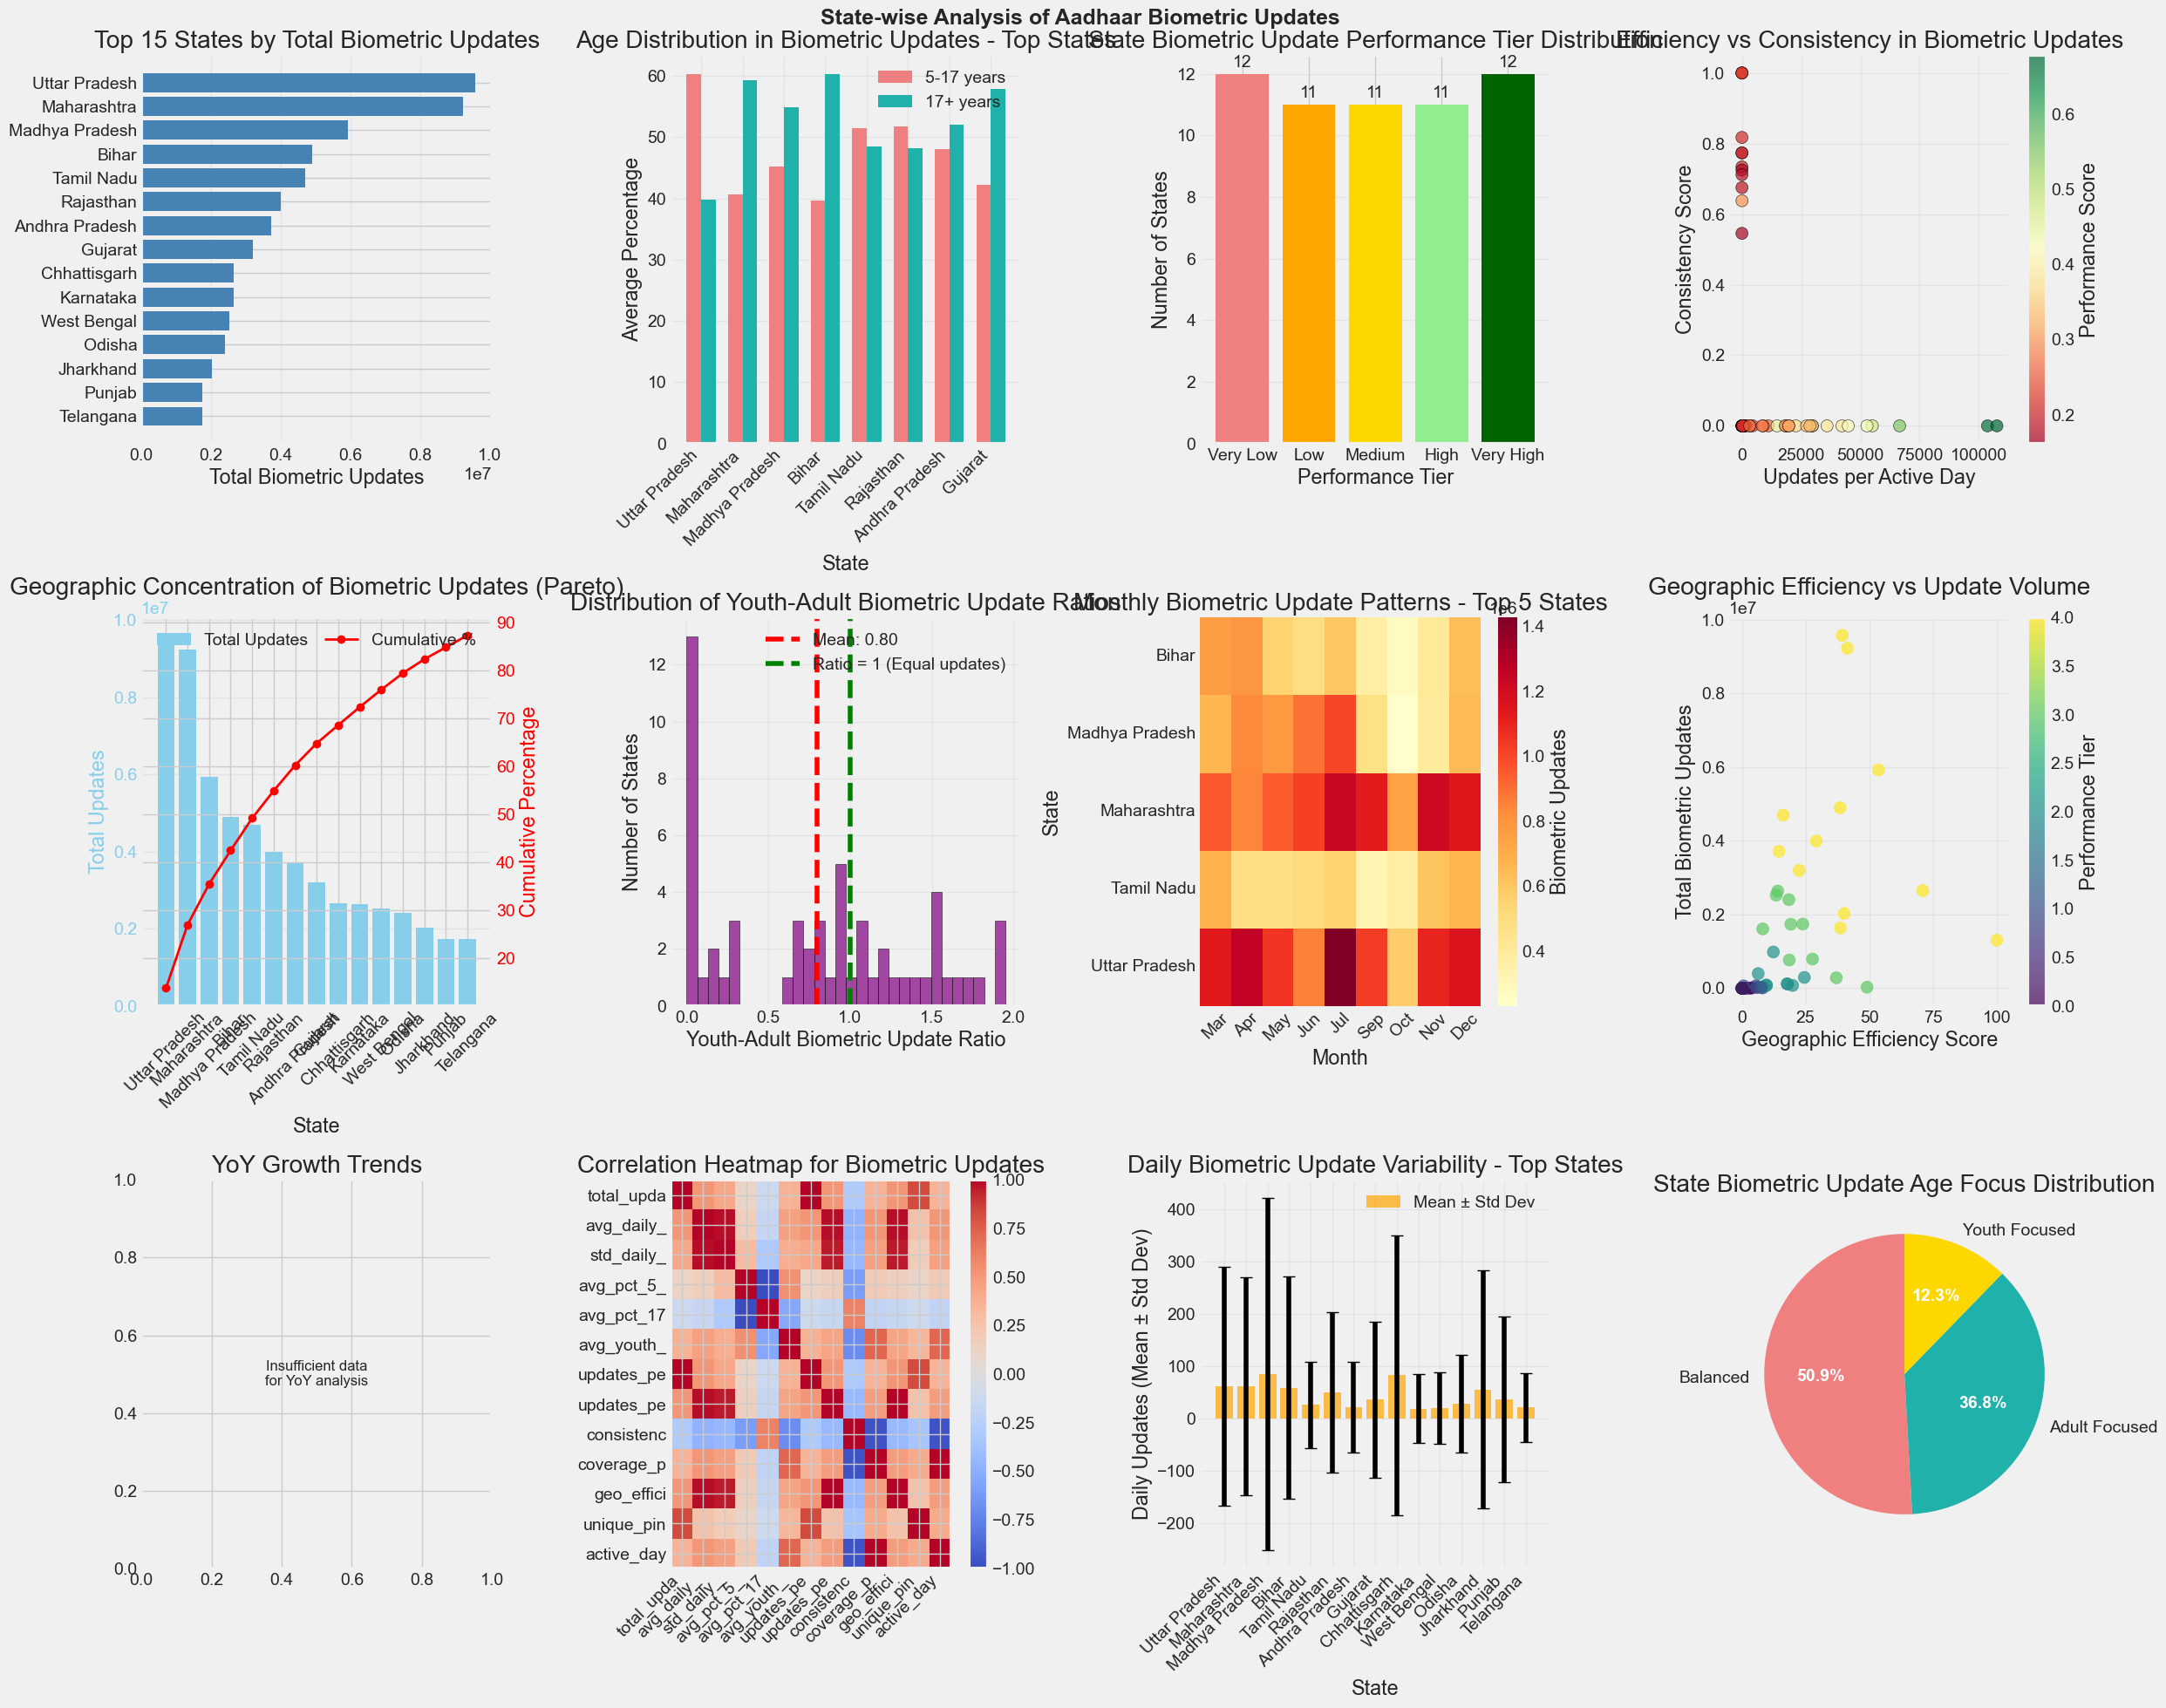

In [19]:
plt.style.use('fivethirtyeight')

# Create comprehensive visualizations
fig = plt.figure(figsize=(25, 20))
fig.suptitle('State-wise Analysis of Aadhaar Biometric Updates', fontsize=18, fontweight='bold')

# Plot 1: Top 15 states by total biometric updates
ax1 = plt.subplot(3, 4, 1)
top_15 = state_analysis.nlargest(15, 'total_updates')
ax1.barh(range(len(top_15)), top_15['total_updates'], color='steelblue')
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels(top_15['state'])
ax1.set_xlabel('Total Biometric Updates')
ax1.set_title('Top 15 States by Total Biometric Updates')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Age distribution comparison for biometric updates
ax2 = plt.subplot(3, 4, 2)
sample_states = state_analysis.nlargest(8, 'total_updates')
x = np.arange(len(sample_states))
width = 0.35
bars1 = ax2.bar(x - width/2, sample_states['avg_pct_5_17'], width, label='5-17 years', color='lightcoral')
bars2 = ax2.bar(x + width/2, sample_states['avg_pct_17_plus'], width, label='17+ years', color='lightseagreen')
ax2.set_xlabel('State')
ax2.set_ylabel('Average Percentage')
ax2.set_title('Age Distribution in Biometric Updates - Top States')
ax2.set_xticks(x)
ax2.set_xticklabels(sample_states['state'], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Performance tiers distribution
ax3 = plt.subplot(3, 4, 3)
tier_counts = state_analysis['performance_tier'].value_counts().sort_index()
colors = ['lightcoral', 'orange', 'gold', 'lightgreen', 'darkgreen']
bars = ax3.bar(tier_counts.index, tier_counts.values, color=colors)
ax3.set_xlabel('Performance Tier')
ax3.set_ylabel('Number of States')
ax3.set_title('State Biometric Update Performance Tier Distribution')
for bar, count in zip(bars, tier_counts.values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            str(count), ha='center', va='bottom')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Updates per active day vs consistency
ax4 = plt.subplot(3, 4, 4)
scatter = ax4.scatter(state_analysis['updates_per_active_day'], 
                     state_analysis['consistency_score'],
                     c=state_analysis['performance_score'], 
                     cmap='RdYlGn', s=100, alpha=0.7, edgecolors='black')
ax4.set_xlabel('Updates per Active Day')
ax4.set_ylabel('Consistency Score')
ax4.set_title('Efficiency vs Consistency in Biometric Updates')
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Performance Score')

# Plot 5: Geographic concentration (Pareto chart)
ax5 = plt.subplot(3, 4, 5)
states_plot = state_analysis_sorted.head(15)
x = np.arange(len(states_plot))
ax5.bar(x, states_plot['total_updates'], color='skyblue', label='Total Updates')
ax5.set_xlabel('State')
ax5.set_ylabel('Total Updates', color='skyblue')
ax5.set_title('Geographic Concentration of Biometric Updates (Pareto)')
ax5.set_xticks(x)
ax5.set_xticklabels(states_plot['state'], rotation=45)
ax5.tick_params(axis='y', labelcolor='skyblue')
ax5.grid(True, alpha=0.3, axis='y')

ax5_2 = ax5.twinx()
ax5_2.plot(x, states_plot['cumulative_share'], 
          color='red', marker='o', linewidth=2, label='Cumulative %')
ax5_2.set_ylabel('Cumulative Percentage', color='red')
ax5_2.tick_params(axis='y', labelcolor='red')
ax5.legend(loc='upper left')
ax5_2.legend(loc='upper right')

# Plot 6: Youth-Adult biometric update ratio distribution
ax6 = plt.subplot(3, 4, 6)
valid_ratios = state_analysis['avg_youth_bio_ratio'].dropna()
ax6.hist(valid_ratios, bins=30, color='purple', alpha=0.7, edgecolor='black')
ax6.axvline(valid_ratios.mean(), color='red', linestyle='--', 
           label=f'Mean: {valid_ratios.mean():.2f}')
ax6.axvline(1, color='green', linestyle='--', label='Ratio = 1 (Equal updates)')
ax6.set_xlabel('Youth-Adult Biometric Update Ratio')
ax6.set_ylabel('Number of States')
ax6.set_title('Distribution of Youth-Adult Biometric Update Ratios')
ax6.legend()
ax6.grid(True, alpha=0.3)

# Plot 7: Monthly biometric update patterns for top 5 states
ax7 = plt.subplot(3, 4, 7)
top_5_states = state_analysis.nlargest(5, 'total_updates')['state'].tolist()
monthly_top5 = monthly_state[monthly_state['state'].isin(top_5_states)]
heatmap_pivot = monthly_top5.pivot(index='state', columns='month', values='total_bio_updates')

# Get the actual months present in the data
months_present = sorted(heatmap_pivot.columns.tolist())
month_labels = [month_names[m-1] for m in months_present]

sns.heatmap(heatmap_pivot, cmap='YlOrRd', ax=ax7, cbar_kws={'label': 'Biometric Updates'})
ax7.set_xlabel('Month')
ax7.set_ylabel('State')
ax7.set_title('Monthly Biometric Update Patterns - Top 5 States')

# Set x-tick labels only for months present in data
ax7.set_xticks(np.arange(len(months_present)) + 0.5)
ax7.set_xticklabels(month_labels, rotation=45)

# Plot 8: Geographic efficiency vs total updates
ax8 = plt.subplot(3, 4, 8)
scatter2 = ax8.scatter(state_analysis['geo_efficiency'], 
                      state_analysis['total_updates'],
                      c=state_analysis['performance_tier'].cat.codes, 
                      cmap='viridis', s=100, alpha=0.7)
ax8.set_xlabel('Geographic Efficiency Score')
ax8.set_ylabel('Total Biometric Updates')
ax8.set_title('Geographic Efficiency vs Update Volume')
ax8.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax8, label='Performance Tier')

# Plot 9: YoY growth for top states
ax9 = plt.subplot(3, 4, 9)
if not valid_growth_data.empty:
    top_growth = valid_growth_data.nlargest(5, 'yoy_growth')['state'].tolist()
    growth_plot_data = yearly_state[yearly_state['state'].isin(top_growth)]
    for state in top_growth:
        state_data = growth_plot_data[growth_plot_data['state'] == state]
        ax9.plot(state_data['year'], state_data['total_bio_updates'], marker='o', label=state)
    ax9.set_xlabel('Year')
    ax9.set_ylabel('Total Biometric Updates')
    ax9.set_title('YoY Growth Trends - Top Growing States')
    ax9.legend()
    ax9.grid(True, alpha=0.3)
else:
    ax9.text(0.5, 0.5, 'Insufficient data\nfor YoY analysis', 
             ha='center', va='center', transform=ax9.transAxes, fontsize=12)
    ax9.set_title('YoY Growth Trends')

# Plot 10: Correlation heatmap
ax10 = plt.subplot(3, 4, 10)
corr_plot = ax10.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
ax10.set_xticks(range(len(corr_matrix.columns)))
ax10.set_yticks(range(len(corr_matrix.columns)))
ax10.set_xticklabels([col[:10] for col in corr_matrix.columns], rotation=45, ha='right')
ax10.set_yticklabels([col[:10] for col in corr_matrix.columns])
ax10.set_title('Correlation Heatmap for Biometric Updates')
plt.colorbar(corr_plot, ax=ax10)

# Plot 11: Daily update variability
ax11 = plt.subplot(3, 4, 11)
variability_data = state_analysis.nlargest(15, 'total_updates')
x = np.arange(len(variability_data))
ax11.bar(x, variability_data['avg_daily_updates'], 
        yerr=variability_data['std_daily_updates'], 
        capsize=5, color='orange', alpha=0.7, 
        label='Mean ± Std Dev')
ax11.set_xlabel('State')
ax11.set_ylabel('Daily Updates (Mean ± Std Dev)')
ax11.set_title('Daily Biometric Update Variability - Top States')
ax11.set_xticks(x)
ax11.set_xticklabels(variability_data['state'], rotation=45, ha='right')
ax11.legend()
ax11.grid(True, alpha=0.3)

# Plot 12: Biometric update age focus by state
ax12 = plt.subplot(3, 4, 12)
focus_counts = state_analysis['bio_age_focus'].value_counts()
colors_focus = ['lightcoral', 'lightseagreen', 'gold']
wedges, texts, autotexts = ax12.pie(focus_counts.values, labels=focus_counts.index, 
                                     autopct='%1.1f%%', colors=colors_focus, startangle=90)
ax12.set_title('State Biometric Update Age Focus Distribution')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

#### 4.2.11 [ KEY INSIGHTS SUMMARY ]

In [20]:
print("\n" + "="*100)
print("11. KEY INSIGHTS SUMMARY FOR BIOMETRIC UPDATES")
print("="*100)

# Insight 1: Overall statistics
print(f"\n1. OVERALL STATISTICS:")
print(f"   - Total biometric updates: {total_national_updates:,}")
print(f"   - States analyzed: {len(state_analysis)}")
print(f"   - Average biometric updates per state: {state_analysis['total_updates'].mean():,.0f}")

# Insight 2: Top performers
top_state_info = state_analysis.nlargest(1, 'total_updates').iloc[0]
print(f"\n2. TOP PERFORMING STATE FOR BIOMETRIC UPDATES:")
print(f"   - {top_state_info['state']}: {top_state_info['total_updates']:,} updates")
print(f"   - Share of national total: {top_state_info['national_share']:.1f}%")
print(f"   - Performance tier: {top_state_info['performance_tier']}")

# Insight 3: Age group patterns for biometric updates
print(f"\n3. AGE GROUP PATTERNS FOR BIOMETRIC UPDATES:")
print(f"   - Average youth (5-17) biometric update percentage: {state_analysis['avg_pct_5_17'].mean():.1f}%")
print(f"   - Average adult (17+) biometric update percentage: {state_analysis['avg_pct_17_plus'].mean():.1f}%")
print(f"   - States with more youth than adult biometric updates: {len(state_analysis[state_analysis['avg_youth_bio_ratio'] > 1])}")

# Insight 4: Geographic concentration
print(f"\n4. GEOGRAPHIC CONCENTRATION OF BIOMETRIC UPDATES:")
print(f"   - Top {len(states_50_percent)} states account for 50% of biometric updates")
print(f"   - Top {len(states_80_percent)} states account for 80% of biometric updates")
print(f"   - Concentration level: {'High' if hhi >= 2500 else 'Moderate' if hhi >= 1500 else 'Low'}")

# Insight 5: Performance distribution
print(f"\n5. BIOMETRIC UPDATE PERFORMANCE DISTRIBUTION:")
very_high_count = len(state_analysis[state_analysis['performance_tier'] == 'Very High'])
high_count = len(state_analysis[state_analysis['performance_tier'] == 'High'])
print(f"   - High/Very High performing states: {very_high_count + high_count} ({((very_high_count + high_count)/len(state_analysis)*100):.1f}%)")
print(f"   - Low/Very Low performing states: {len(state_analysis[state_analysis['performance_tier'].isin(['Low', 'Very Low'])])}")

# Insight 6: Consistency and coverage
print(f"\n6. CONSISTENCY AND COVERAGE FOR BIOMETRIC UPDATES:")
print(f"   - Average coverage days: {state_analysis['coverage_percentage'].mean():.1f}% of total period")
if 'consistency_score' in state_analysis.columns and state_analysis['consistency_score'].notna().any():
    most_consistent = state_analysis.nlargest(1, 'consistency_score').iloc[0]
    print(f"   - Most consistent state: {most_consistent['state']} (Score: {most_consistent['consistency_score']:.2f})")
print(f"   - Best coverage state: {state_analysis.nlargest(1, 'coverage_percentage').iloc[0]['state']}")

# Insight 7: Geographic efficiency
print(f"\n7. GEOGRAPHIC EFFICIENCY FOR BIOMETRIC UPDATES:")
most_efficient = state_analysis.nlargest(1, 'geo_efficiency').iloc[0]
print(f"   - Most geographically efficient state: {most_efficient['state']} ({most_efficient['geo_efficiency']:.1f} score)")
print(f"   - Average updates per pincode: {state_analysis['updates_per_pincode'].mean():.1f}")

# Insight 8: Growth patterns
if not valid_growth_data.empty and 'yoy_growth' in valid_growth_data.columns:
    positive_growth = valid_growth_data[valid_growth_data['yoy_growth'] > 0]
    if len(positive_growth) > 0:
        fastest_growth = positive_growth.nlargest(1, 'yoy_growth').iloc[0]
        print(f"\n8. GROWTH PATTERNS FOR BIOMETRIC UPDATES:")
        print(f"   - States with positive YoY growth: {len(positive_growth)}")
        print(f"   - Fastest growing state: {fastest_growth['state']} ({fastest_growth['yoy_growth']:.1f}% growth)")

# Insight 9: Strategic recommendations
print(f"\n9. STRATEGIC RECOMMENDATIONS FOR BIOMETRIC UPDATES:")
print("   - Focus resources on states with high biometric update potential")
print("   - Study best practices from high-consistency states")
print("   - Address geographic coverage gaps in low-performing states")
print("   - Tailor approaches based on age group patterns")
print("   - Monitor growth trends for emerging high-potential states")
print("   - Improve geographic efficiency through better pincode coverage")

print("\n" + "="*100)
print("ANALYSIS COMPLETE")
print("="*100)


11. KEY INSIGHTS SUMMARY FOR BIOMETRIC UPDATES

1. OVERALL STATISTICS:
   - Total biometric updates: 69,763,095
   - States analyzed: 57
   - Average biometric updates per state: 1,223,914

2. TOP PERFORMING STATE FOR BIOMETRIC UPDATES:
   - Uttar Pradesh: 9,577,735 updates
   - Share of national total: 13.7%
   - Performance tier: Very High

3. AGE GROUP PATTERNS FOR BIOMETRIC UPDATES:
   - Average youth (5-17) biometric update percentage: 43.3%
   - Average adult (17+) biometric update percentage: 56.7%
   - States with more youth than adult biometric updates: 22

4. GEOGRAPHIC CONCENTRATION OF BIOMETRIC UPDATES:
   - Top 5 states account for 50% of biometric updates
   - Top 12 states account for 80% of biometric updates
   - Concentration level: Low

5. BIOMETRIC UPDATE PERFORMANCE DISTRIBUTION:
   - High/Very High performing states: 23 (40.4%)
   - Low/Very Low performing states: 23

6. CONSISTENCY AND COVERAGE FOR BIOMETRIC UPDATES:
   - Average coverage days: 78.5% of total per

#### 4.2.12 [ EXPORT KEY FINDINGS ]

In [21]:
print("\n" + "="*100)
print("12. STATE BIOMETRIC UPDATE PERFORMANCE SUMMARY (Top 20)")
print("="*100)

summary_columns = ['state', 'total_updates', 'national_share', 'performance_tier', 'bio_age_focus',
                  'avg_daily_updates', 'updates_per_active_day', 'updates_per_pincode',
                  'coverage_percentage', 'avg_pct_5_17', 'avg_pct_17_plus', 'avg_youth_bio_ratio']

summary_report = state_analysis[summary_columns].sort_values('total_updates', ascending=False)
print(summary_report.head(20).to_string(index=False))

# Export state categorization for action planning
print("\n" + "="*100)
print("STATE CATEGORIZATION FOR BIOMETRIC UPDATE ACTION PLANNING")
print("="*100)

categorization = state_analysis[['state', 'performance_tier', 'bio_age_focus', 'total_updates', 
                                'national_share', 'coverage_percentage', 'geo_efficiency']].copy()
categorization['action_category'] = np.where(
    categorization['performance_tier'].isin(['Very High', 'High']),
    'Maintain & Optimize',
    np.where(
        categorization['performance_tier'] == 'Medium',
        'Improve & Scale',
        'Intervene & Support'
    )
)

print("\nAction Categories for Biometric Updates:")
action_counts = categorization['action_category'].value_counts()
for category, count in action_counts.items():
    print(f"  {category}: {count} states")

print("\nDetailed Categorization:")
print(categorization.sort_values(['action_category', 'total_updates'], ascending=[True, False]).to_string(index=False))


12. STATE BIOMETRIC UPDATE PERFORMANCE SUMMARY (Top 20)
            state  total_updates  national_share performance_tier bio_age_focus  avg_daily_updates  updates_per_active_day  updates_per_pincode  coverage_percentage  avg_pct_5_17  avg_pct_17_plus  avg_youth_bio_ratio
    Uttar Pradesh        9577735       13.728942        Very High Youth Focused              61.70           107615.000000          5463.625214           100.000000         60.26            39.74                 1.95
      Maharashtra        9226139       13.224957        Very High      Balanced              61.06           103664.483146          5741.219042           100.000000         40.69            59.31                 1.10
   Madhya Pradesh        5923771        8.491267        Very High      Balanced              84.53            66559.224719          7432.585947           100.000000         45.16            54.84                 1.05
            Bihar        4897587        7.020312        Very High Adult Foc

#### 4.2.13 [ ADDITIONAL ANALYSES ]

In [22]:
print("\n" + "="*100)
print("13. ADDITIONAL BIOMETRIC UPDATE ANALYSES")
print("="*100)

# Comparison with other update types (if you have other datasets)
print("\nA. STATE COMPARISON ANALYSIS:")
print("Top 5 states by biometric updates:")
for i, row in state_analysis.nlargest(5, 'total_updates').iterrows():
    print(f"  {i+1}. {row['state']}: {row['total_updates']:,} biometric updates "
          f"({row['national_share']:.1f}% of total)")

# Age focus analysis
print("\nB. AGE FOCUS ANALYSIS FOR BIOMETRIC UPDATES:")
youth_focused = state_analysis[state_analysis['bio_age_focus'] == 'Youth Focused']
adult_focused = state_analysis[state_analysis['bio_age_focus'] == 'Adult Focused']
balanced = state_analysis[state_analysis['bio_age_focus'] == 'Balanced']

print(f"  - Youth-focused states: {len(youth_focused)}")
print(f"  - Adult-focused states: {len(adult_focused)}")
print(f"  - Balanced states: {len(balanced)}")

# Geographic efficiency analysis
print("\nC. GEOGRAPHIC EFFICIENCY ANALYSIS:")
high_efficiency = state_analysis[state_analysis['geo_efficiency'] > state_analysis['geo_efficiency'].quantile(0.75)]
low_efficiency = state_analysis[state_analysis['geo_efficiency'] < state_analysis['geo_efficiency'].quantile(0.25)]

print(f"  - High geographic efficiency states (top 25%): {len(high_efficiency)}")
print(f"  - Low geographic efficiency states (bottom 25%): {len(low_efficiency)}")

if len(high_efficiency) > 0:
    print("  Top 3 geographically efficient states:")
    for i, row in high_efficiency.nlargest(3, 'geo_efficiency').iterrows():
        print(f"    - {row['state']}: {row['geo_efficiency']:.1f} score "
              f"({row['updates_per_pincode']:.1f} updates/pincode)")

# Peak month analysis
print("\nD. PEAK MONTH ANALYSIS FOR BIOMETRIC UPDATES:")
if len(top_states_peak) > 0:
    month_counts = top_states_peak['month_name'].value_counts()
    print("  Most common peak months among top states:")
    for month, count in month_counts.head(3).items():
        print(f"    - {month}: {count} states")

# Final summary statistics
print("\nE. FINAL SUMMARY STATISTICS:")
summary_stats = {
    'Total Biometric Updates': f"{total_national_updates:,}",
    'Average Daily Updates per State': f"{state_analysis['avg_daily_updates'].mean():.1f}",
    'Youth Update Percentage (National)': f"{(state_analysis['total_5_17'].sum()/total_national_updates*100):.1f}%",
    'Adult Update Percentage (National)': f"{(state_analysis['total_17_plus'].sum()/total_national_updates*100):.1f}%",
    'Average Geographic Efficiency': f"{state_analysis['geo_efficiency'].mean():.1f}",
    'Average Coverage Days': f"{state_analysis['coverage_percentage'].mean():.1f}%",
    'Top Performing State': top_state_info['state']
}

for key, value in summary_stats.items():
    print(f"  {key}: {value}")

print("\n" + "="*100)
print("ALL BIOMETRIC UPDATE ANALYSES COMPLETED SUCCESSFULLY!")
print("="*100)


13. ADDITIONAL BIOMETRIC UPDATE ANALYSES

A. STATE COMPARISON ANALYSIS:
Top 5 states by biometric updates:
  45. Uttar Pradesh: 9,577,735 biometric updates (13.7% of total)
  28. Maharashtra: 9,226,139 biometric updates (13.2% of total)
  27. Madhya Pradesh: 5,923,771 biometric updates (8.5% of total)
  6. Bihar: 4,897,587 biometric updates (7.0% of total)
  41. Tamil Nadu: 4,698,117 biometric updates (6.7% of total)

B. AGE FOCUS ANALYSIS FOR BIOMETRIC UPDATES:
  - Youth-focused states: 7
  - Adult-focused states: 21
  - Balanced states: 29

C. GEOGRAPHIC EFFICIENCY ANALYSIS:
  - High geographic efficiency states (top 25%): 14
  - Low geographic efficiency states (bottom 25%): 14
  Top 3 geographically efficient states:
    - Delhi: 100.0 score (13876.2 updates/pincode)
    - Chhattisgarh: 71.0 score (9846.6 updates/pincode)
    - Madhya Pradesh: 53.6 score (7432.6 updates/pincode)

D. PEAK MONTH ANALYSIS FOR BIOMETRIC UPDATES:
  Most common peak months among top states:
    - Jul: 5

### 4.3 District-wise Analysis of Aadhaar Biometric Updates

In [23]:
print("Starting district-wise analysis of biometric updates...")
print(f"Total districts in dataset: {df['district'].nunique()}")
print(f"Total states in dataset: {df['state'].nunique()}")
print(f"Total biometric updates: {df['total_bio_updates'].sum():,}")
print(f"Date Range: {df['date'].min()} to {df['date'].max()}")

# Define month names for better readability
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Starting district-wise analysis of biometric updates...
Total districts in dataset: 974
Total states in dataset: 57
Total biometric updates: 69,763,095
Date Range: 2025-03-01 00:00:00 to 2025-12-29 00:00:00


#### 4.3.1 [ DISTRICT-LEVEL SUMMARY STATISTICS ]

In [24]:
print("\n" + "="*100)
print("1. DISTRICT-LEVEL SUMMARY STATISTICS FOR BIOMETRIC UPDATES")
print("="*100)

# Group by state and district for aggregated analysis
district_analysis = df.groupby(['state', 'district']).agg({
    'total_bio_updates': ['sum', 'mean', 'std', 'count'],
    'bio_age_5_17': 'sum',
    'bio_age_17_': 'sum',
    'pct_5_17': 'mean',
    'pct_17_plus': 'mean',
    'youth_bio_ratio': 'mean',
    'date': 'nunique',  # Number of days with updates
    'pincode': 'nunique'  # Number of unique pincodes
}).round(2)

# Flatten multi-index columns
district_analysis.columns = ['_'.join(col).strip() for col in district_analysis.columns.values]
district_analysis = district_analysis.reset_index()

# Rename for clarity
district_analysis.rename(columns={
    'total_bio_updates_sum': 'total_updates',
    'total_bio_updates_mean': 'avg_daily_updates',
    'total_bio_updates_std': 'std_daily_updates',
    'total_bio_updates_count': 'records_count',
    'bio_age_5_17_sum': 'total_5_17',
    'bio_age_17__sum': 'total_17_plus',
    'pct_5_17_mean': 'avg_pct_5_17',
    'pct_17_plus_mean': 'avg_pct_17_plus',
    'youth_bio_ratio_mean': 'avg_youth_bio_ratio',
    'date_nunique': 'active_days',
    'pincode_nunique': 'unique_pincodes'
}, inplace=True)

# Calculate additional metrics
district_analysis['updates_per_active_day'] = district_analysis['total_updates'] / district_analysis['active_days']
district_analysis['updates_per_pincode'] = district_analysis['total_updates'] / district_analysis['unique_pincodes']
district_analysis['records_per_day'] = district_analysis['records_count'] / district_analysis['active_days']
district_analysis['coverage_density'] = district_analysis['records_count'] / district_analysis['unique_pincodes']

# Calculate consistency score
district_analysis['consistency_score'] = 1 - (district_analysis['std_daily_updates'] / district_analysis['avg_daily_updates'].replace(0, np.nan))
district_analysis['consistency_score'] = district_analysis['consistency_score'].clip(lower=0, upper=1)

# Calculate coverage percentage
total_days_in_period = df['date'].nunique()
district_analysis['coverage_percentage'] = (district_analysis['active_days'] / total_days_in_period) * 100

print(f"\nTotal districts analyzed: {len(district_analysis)}")
print(f"Total biometric updates across all districts: {district_analysis['total_updates'].sum():,}")


1. DISTRICT-LEVEL SUMMARY STATISTICS FOR BIOMETRIC UPDATES

Total districts analyzed: 1072
Total biometric updates across all districts: 69,763,095


#### 4.3.2 [ TOP/BOTTOM PERFORMING DISTRICTS NATIONALLY ]

In [25]:
print("\n" + "="*100)
print("2. TOP/BOTTOM PERFORMING DISTRICTS NATIONALLY")
print("="*100)

print("\nTOP 20 DISTRICTS BY TOTAL BIOMETRIC UPDATES:")
top_districts_national = district_analysis.nlargest(20, 'total_updates')[['state', 'district', 'total_updates', 'avg_daily_updates', 'active_days', 'unique_pincodes']]
print(top_districts_national.to_string(index=False))

print("\nBOTTOM 20 DISTRICTS BY TOTAL BIOMETRIC UPDATES:")
bottom_districts_national = district_analysis.nsmallest(20, 'total_updates')[['state', 'district', 'total_updates', 'avg_daily_updates', 'active_days', 'unique_pincodes']]
print(bottom_districts_national.to_string(index=False))

print("\nTOP 10 DISTRICTS BY BIOMETRIC UPDATE INTENSITY (Updates per Active Day):")
intensity_districts = district_analysis.nlargest(10, 'updates_per_active_day')[['state', 'district', 'updates_per_active_day', 'total_updates', 'active_days']]
print(intensity_districts.to_string(index=False))


2. TOP/BOTTOM PERFORMING DISTRICTS NATIONALLY

TOP 20 DISTRICTS BY TOTAL BIOMETRIC UPDATES:
         state         district  total_updates  avg_daily_updates  active_days  unique_pincodes
   Maharashtra             Pune         605762              52.28           88              147
   Maharashtra           Nashik         576606              94.49           87               77
   Maharashtra            Thane         571273              78.80           88               96
   Maharashtra          Jalgaon         417384              83.48           87               66
       Gujarat        Ahmedabad         405490              64.34           88               89
   Maharashtra           Mumbai         404359              53.18           87              135
   Maharashtra       Ahmadnagar         363561              48.86           88               94
     Rajasthan           Jaipur         355884              57.22           88               85
   Maharashtra           Nagpur         350

#### 4.3.3 [ TOP DISTRICTS WITHIN EACH STATE ]

In [26]:
print("\n" + "="*100)
print("3. TOP DISTRICTS WITHIN EACH STATE FOR BIOMETRIC UPDATES")
print("="*100)

# Get top 3 districts per state
district_analysis_sorted = district_analysis.sort_values(['state', 'total_updates'], ascending=[True, False])
top_3_per_state = district_analysis_sorted.groupby('state').head(3)

print("\nTOP 3 DISTRICTS IN EACH STATE BY BIOMETRIC UPDATES:")
for state in sorted(top_3_per_state['state'].unique()):
    state_districts = top_3_per_state[top_3_per_state['state'] == state]
    print(f"\n{state}:")
    for idx, row in state_districts.iterrows():
        print(f"  {row['district']}: {row['total_updates']:,} biometric updates "
              f"(Avg: {row['avg_daily_updates']:.1f}/day, "
              f"Active days: {row['active_days']}, Pincodes: {row['unique_pincodes']})")


3. TOP DISTRICTS WITHIN EACH STATE FOR BIOMETRIC UPDATES

TOP 3 DISTRICTS IN EACH STATE BY BIOMETRIC UPDATES:

Andaman & Nicobar Islands:
  Andamans: 2,015 biometric updates (Avg: 5.6/day, Active days: 81, Pincodes: 12)
  South Andaman: 367 biometric updates (Avg: 1.9/day, Active days: 68, Pincodes: 6)
  Nicobars: 2 biometric updates (Avg: 1.0/day, Active days: 2, Pincodes: 1)

Andaman and Nicobar Islands:
  South Andaman: 10,120 biometric updates (Avg: 14.2/day, Active days: 82, Pincodes: 12)
  North And Middle Andaman: 6,383 biometric updates (Avg: 16.5/day, Active days: 81, Pincodes: 7)
  Nicobar: 1,811 biometric updates (Avg: 9.0/day, Active days: 75, Pincodes: 4)

Andhra Pradesh:
  Kurnool: 350,633 biometric updates (Avg: 52.8/day, Active days: 88, Pincodes: 86)
  Visakhapatnam: 311,303 biometric updates (Avg: 43.9/day, Active days: 88, Pincodes: 94)
  East Godavari: 301,850 biometric updates (Avg: 28.4/day, Active days: 88, Pincodes: 152)

Arunachal Pradesh:
  Papum Pare: 9,259 

#### 4.3.4 [ AGE GROUP ANALYSIS BY DISTRICT ]

In [27]:
print("\n" + "="*100)
print("4. AGE GROUP ANALYSIS FOR BIOMETRIC UPDATES BY DISTRICT")
print("="*100)

print("\nTOP 10 DISTRICTS WITH HIGHEST YOUTH (5-17) BIOMETRIC UPDATE PERCENTAGE:")
top_youth_districts = district_analysis.nlargest(10, 'avg_pct_5_17')[['state', 'district', 'avg_pct_5_17', 'total_5_17', 'total_updates']]
print(top_youth_districts.to_string(index=False))

print("\nTOP 10 DISTRICTS WITH HIGHEST ADULT (17+) BIOMETRIC UPDATE PERCENTAGE:")
top_adult_districts = district_analysis.nlargest(10, 'avg_pct_17_plus')[['state', 'district', 'avg_pct_17_plus', 'total_17_plus', 'total_updates']]
print(top_adult_districts.to_string(index=False))

print("\nDISTRICTS WITH HIGHEST YOUTH-ADULT BIOMETRIC UPDATE RATIO (>2 indicates significantly more youth updates):")
high_ratio_districts = district_analysis[district_analysis['avg_youth_bio_ratio'] > 2].nlargest(10, 'avg_youth_bio_ratio')
print(high_ratio_districts[['state', 'district', 'avg_youth_bio_ratio', 'avg_pct_5_17', 'avg_pct_17_plus']].to_string(index=False))

# Categorize districts by biometric update age focus
district_analysis['bio_age_focus'] = np.where(
    district_analysis['avg_pct_5_17'] > 60, 'Youth Focused',
    np.where(
        district_analysis['avg_pct_17_plus'] > 60, 'Adult Focused',
        'Balanced'
    )
)

print("\nDISTRICT BIOMETRIC UPDATE AGE FOCUS DISTRIBUTION:")
bio_focus_dist = district_analysis['bio_age_focus'].value_counts()
for focus, count in bio_focus_dist.items():
    percentage = (count / len(district_analysis)) * 100
    print(f"  {focus}: {count} districts ({percentage:.1f}%)")


4. AGE GROUP ANALYSIS FOR BIOMETRIC UPDATES BY DISTRICT

TOP 10 DISTRICTS WITH HIGHEST YOUTH (5-17) BIOMETRIC UPDATE PERCENTAGE:
            state          district  avg_pct_5_17  total_5_17  total_updates
Jammu and Kashmir            Poonch        100.00           1              1
          Manipur          Pherzawl        100.00           2              2
           Orissa             Angul        100.00           2              2
        Tamilnadu           Chennai        100.00           1              1
    Uttar Pradesh         Auraiya *        100.00           1              1
      West Bengal  South 24 pargana        100.00           1              1
      west Bengal South 24 Parganas        100.00           1              1
Arunachal Pradesh          Leparada         91.30          34             36
       Tamil Nadu        Tirupathur         84.43          50             59
Jammu and Kashmir            Budgam         83.88       18502          23111

TOP 10 DISTRICTS WITH 

#### 4.3.5 [ DISTRICT COVERAGE AND DENSITY ANALYSIS ]

In [28]:
print("\n" + "="*100)
print("5. DISTRICT COVERAGE AND DENSITY ANALYSIS FOR BIOMETRIC UPDATES")
print("="*100)

print("\nDISTRICTS WITH WIDEST GEOGRAPHIC COVERAGE (Most Pincodes):")
wide_coverage = district_analysis.nlargest(10, 'unique_pincodes')[['state', 'district', 'unique_pincodes', 'updates_per_pincode', 'total_updates']]
print(wide_coverage.to_string(index=False))

print("\nDISTRICTS WITH HIGHEST BIOMETRIC UPDATE DENSITY (Updates per Pincode):")
high_density = district_analysis.nlargest(10, 'updates_per_pincode')[['state', 'district', 'updates_per_pincode', 'unique_pincodes', 'total_updates']]
print(high_density.to_string(index=False))

print("\nDISTRICTS WITH HIGHEST COVERAGE DENSITY (Records per Pincode):")
high_coverage_density = district_analysis.nlargest(10, 'coverage_density')[['state', 'district', 'coverage_density', 'unique_pincodes', 'records_count']]
print(high_coverage_density.to_string(index=False))

# Calculate district geographic efficiency
district_analysis['geo_efficiency'] = (district_analysis['updates_per_pincode'] / district_analysis['updates_per_pincode'].max()) * 100

print("\nMOST GEOGRAPHICALLY EFFICIENT DISTRICTS (Highest Biometric Update per Pincode Efficiency):")
geo_efficient_districts = district_analysis.nlargest(10, 'geo_efficiency')[['state', 'district', 'geo_efficiency', 'updates_per_pincode', 'unique_pincodes']]
print(geo_efficient_districts.to_string(index=False))


5. DISTRICT COVERAGE AND DENSITY ANALYSIS FOR BIOMETRIC UPDATES

DISTRICTS WITH WIDEST GEOGRAPHIC COVERAGE (Most Pincodes):
         state           district  unique_pincodes  updates_per_pincode  total_updates
   West Bengal         Barddhaman              170          1065.447059         181126
        Kerala           Thrissur              168           866.142857         145512
Andhra Pradesh      East Godavari              152          1985.855263         301850
   West Bengal  North 24 Parganas              148          1512.905405         223910
   Maharashtra               Pune              147          4120.829932         605762
        Kerala          Ernakulam              138          1077.934783         148755
        Kerala           Palakkad              138          1158.311594         159847
   Maharashtra             Mumbai              135          2995.251852         404359
        Kerala Thiruvananthapuram              131          1136.007634         148817
    T

#### 4.3.6 [PERFORMANCE CLUSTERING AND CATEGORIZATION ]

In [29]:
print("\n" + "="*100)
print("6. DISTRICT BIOMETRIC UPDATE PERFORMANCE CLUSTERING")
print("="*100)

# Create comprehensive performance score for biometric updates
district_analysis['performance_score'] = (
    (district_analysis['total_updates'] / district_analysis['total_updates'].max()) * 0.2 +
    (district_analysis['updates_per_active_day'] / district_analysis['updates_per_active_day'].max()) * 0.2 +
    district_analysis['consistency_score'] * 0.2 +
    (district_analysis['coverage_percentage'] / 100) * 0.2 +
    (district_analysis['geo_efficiency'] / 100) * 0.2
)

# Fill NaN performance scores with 0
district_analysis['performance_score'] = district_analysis['performance_score'].fillna(0)

# Categorize districts into performance tiers
district_analysis['performance_tier'] = pd.qcut(district_analysis['performance_score'], 
                                               q=5, 
                                               labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

print("\nDISTRICT BIOMETRIC UPDATE PERFORMANCE TIER DISTRIBUTION:")
tier_distribution = district_analysis['performance_tier'].value_counts().sort_index()
for tier, count in tier_distribution.items():
    percentage = (count / len(district_analysis)) * 100
    print(f"  {tier}: {count} districts ({percentage:.1f}%)")


6. DISTRICT BIOMETRIC UPDATE PERFORMANCE CLUSTERING

DISTRICT BIOMETRIC UPDATE PERFORMANCE TIER DISTRIBUTION:
  Very Low: 215 districts (20.1%)
  Low: 214 districts (20.0%)
  Medium: 214 districts (20.0%)
  High: 214 districts (20.0%)
  Very High: 215 districts (20.1%)


#### 4.3.7 [ STATE-WISE DISTRICT PERFORMANCE ANALYSIS ]

In [30]:
print("\n" + "="*100)
print("7. STATE-WISE DISTRICT PERFORMANCE ANALYSIS FOR BIOMETRIC UPDATES")
print("="*100)

# Analyze district distribution within each state
state_district_summary = district_analysis.groupby('state').agg({
    'district': 'count',
    'total_updates': ['sum', 'mean', 'std', 'max'],
    'performance_tier': lambda x: (x == 'Very High').sum(),
    'unique_pincodes': 'sum',
    'active_days': 'mean',
    'updates_per_pincode': 'mean'
}).round(2)

state_district_summary.columns = ['num_districts', 'state_total_updates', 
                                  'avg_district_updates', 'std_district_updates',
                                  'max_district_updates', 'high_performing_districts',
                                  'total_pincodes', 'avg_active_days', 'avg_updates_per_pincode']

state_district_summary = state_district_summary.reset_index()

# Calculate additional metrics
state_district_summary['updates_per_district'] = state_district_summary['state_total_updates'] / state_district_summary['num_districts']
state_district_summary['pincodes_per_district'] = state_district_summary['total_pincodes'] / state_district_summary['num_districts']
state_district_summary['high_performing_ratio'] = (state_district_summary['high_performing_districts'] / 
                                                   state_district_summary['num_districts']) * 100

print("\nSTATES WITH MOST HIGH-PERFORMING DISTRICTS FOR BIOMETRIC UPDATES:")
top_hp_states = state_district_summary.nlargest(10, 'high_performing_districts')[['state', 'high_performing_districts', 'num_districts', 'high_performing_ratio']]
print(top_hp_states.to_string(index=False))

print("\nSTATES WITH HIGHEST AVERAGE DISTRICT BIOMETRIC UPDATES:")
top_avg_states = state_district_summary.nlargest(10, 'avg_district_updates')[['state', 'avg_district_updates', 'num_districts', 'state_total_updates']]
print(top_avg_states.to_string(index=False))

print("\nSTATES WITH MOST CONSISTENT DISTRICT PERFORMANCE (Lowest Std Dev):")
consistent_states = state_district_summary.nsmallest(10, 'std_district_updates')[['state', 'std_district_updates', 'avg_district_updates', 'num_districts']]
print(consistent_states.to_string(index=False))

print("\nSTATES WITH HIGHEST GEOGRAPHIC EFFICIENCY (Avg Updates per Pincode):")
efficient_states = state_district_summary.nlargest(10, 'avg_updates_per_pincode')[['state', 'avg_updates_per_pincode', 'total_pincodes', 'state_total_updates']]
print(efficient_states.to_string(index=False))


7. STATE-WISE DISTRICT PERFORMANCE ANALYSIS FOR BIOMETRIC UPDATES

STATES WITH MOST HIGH-PERFORMING DISTRICTS FOR BIOMETRIC UPDATES:
         state  high_performing_districts  num_districts  high_performing_ratio
 Uttar Pradesh                         34             90              37.777778
   Maharashtra                         33             52              63.461538
Madhya Pradesh                         31             60              51.666667
         Bihar                         19             47              40.425532
    Tamil Nadu                         15             45              33.333333
Andhra Pradesh                         12             45              26.666667
     Rajasthan                         12             46              26.086957
  Chhattisgarh                         10             40              25.000000
         Delhi                          8             13              61.538462
       Gujarat                          7             39          

#### 4.3.8 [ DISTRICT SIZE CATEGORIZATION ]

In [31]:
print("\n" + "="*100)
print("8. DISTRICT SIZE CATEGORIZATION FOR BIOMETRIC UPDATES")
print("="*100)

# Categorize districts by size based on unique pincodes
district_analysis['size_category'] = pd.cut(district_analysis['unique_pincodes'],
                                           bins=[0, 10, 50, 100, float('inf')],
                                           labels=['Small', 'Medium', 'Large', 'Very Large'])

print("\nDISTRICT SIZE DISTRIBUTION:")
size_distribution = district_analysis['size_category'].value_counts().sort_index()
for size, count in size_distribution.items():
    percentage = (count / len(district_analysis)) * 100
    avg_updates = district_analysis[district_analysis['size_category'] == size]['total_updates'].mean()
    print(f"  {size}: {count} districts ({percentage:.1f}%), Avg biometric updates: {avg_updates:,.0f}")

# Analyze performance by size category for biometric updates
print("\nBIOMETRIC UPDATE PERFORMANCE BY DISTRICT SIZE:")
size_performance = district_analysis.groupby('size_category').agg({
    'total_updates': 'mean',
    'updates_per_pincode': 'mean',
    'updates_per_active_day': 'mean',
    'performance_score': 'mean',
    'avg_pct_5_17': 'mean',
    'district': 'count'
}).round(2)

size_performance = size_performance.rename(columns={'district': 'count'})
print(size_performance.to_string())


8. DISTRICT SIZE CATEGORIZATION FOR BIOMETRIC UPDATES

DISTRICT SIZE DISTRIBUTION:
  Small: 314 districts (29.3%), Avg biometric updates: 9,027
  Medium: 566 districts (52.8%), Avg biometric updates: 73,283
  Large: 158 districts (14.7%), Avg biometric updates: 123,066
  Very Large: 34 districts (3.2%), Avg biometric updates: 176,654

BIOMETRIC UPDATE PERFORMANCE BY DISTRICT SIZE:
               total_updates  updates_per_pincode  updates_per_active_day  performance_score  avg_pct_5_17  count
size_category                                                                                                    
Small                9026.74              1458.61                  106.77               0.19         38.08    314
Medium              73282.89              3042.34                  845.98               0.26         45.83    566
Large              123065.52              1738.95                 1409.68               0.29         44.88    158
Very Large         176653.91              143

#### 4.3.9 [ CORRELATION ANALYSIS ]

In [32]:
print("\n" + "="*100)
print("9. CORRELATION ANALYSIS FOR DISTRICT BIOMETRIC UPDATE METRICS")
print("="*100)

# Calculate correlations between key metrics
correlation_metrics = ['total_updates', 'avg_daily_updates', 'std_daily_updates',
                      'avg_pct_5_17', 'avg_pct_17_plus', 'avg_youth_bio_ratio',
                      'updates_per_active_day', 'updates_per_pincode', 
                      'coverage_density', 'consistency_score', 'unique_pincodes',
                      'active_days', 'coverage_percentage', 'geo_efficiency']

corr_matrix = district_analysis[correlation_metrics].corr()

print("\nTOP 10 STRONGEST CORRELATIONS (Absolute Value > 0.5):")
correlation_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.5 and not pd.isna(corr_value):
            correlation_pairs.append({
                'var1': corr_matrix.columns[i][:15],
                'var2': corr_matrix.columns[j][:15],
                'correlation': corr_value
            })

if correlation_pairs:
    correlation_df = pd.DataFrame(correlation_pairs).sort_values('correlation', key=abs, ascending=False).head(10)
    print(correlation_df.to_string(index=False))
else:
    print("No strong correlations found (Absolute value > 0.5)")


9. CORRELATION ANALYSIS FOR DISTRICT BIOMETRIC UPDATE METRICS

TOP 10 STRONGEST CORRELATIONS (Absolute Value > 0.5):
           var1            var2  correlation
    active_days coverage_percen     1.000000
updates_per_pin  geo_efficiency     1.000000
   avg_pct_5_17 avg_pct_17_plus    -1.000000
  total_updates updates_per_act     0.999904
avg_daily_updat updates_per_pin     0.966995
avg_daily_updat  geo_efficiency     0.966995
avg_daily_updat std_daily_updat     0.964159
std_daily_updat  geo_efficiency     0.932110
std_daily_updat updates_per_pin     0.932110
consistency_sco coverage_percen    -0.928222


#### 4.3.10 [ TEMPORAL ANALYSIS BY DISTRICT ]

In [33]:
print("\n" + "="*100)
print("10. TEMPORAL ANALYSIS FOR BIOMETRIC UPDATES BY DISTRICT")
print("="*100)

# Analyze monthly patterns for districts
monthly_district = df.groupby(['state', 'district', 'month']).agg({
    'total_bio_updates': 'sum',
    'bio_age_5_17': 'sum',
    'bio_age_17_': 'sum'
}).reset_index()

# Find peak month for each district
peak_month_by_district = monthly_district.loc[monthly_district.groupby(['state', 'district'])['total_bio_updates'].idxmax()]
peak_month_by_district['month_name'] = peak_month_by_district['month'].apply(lambda x: month_names[x-1])

print("\nPEAK BIOMETRIC UPDATE MONTHS FOR TOP 10 DISTRICTS:")
top_10_districts = district_analysis.nlargest(10, 'total_updates')[['state', 'district']]
peak_top_districts = peak_month_by_district.merge(top_10_districts, on=['state', 'district'])
print(peak_top_districts[['state', 'district', 'month_name', 'total_bio_updates']].to_string(index=False))

# Yearly growth analysis for districts with multi-year data
if df['year'].nunique() > 1:
    yearly_district = df.groupby(['state', 'district', 'year']).agg({
        'total_bio_updates': 'sum'
    }).reset_index()
    
    # Calculate YoY growth for districts with data in consecutive years
    yearly_district = yearly_district.sort_values(['state', 'district', 'year'])
    yearly_district['prev_year_updates'] = yearly_district.groupby(['state', 'district'])['total_bio_updates'].shift(1)
    yearly_district['yoy_growth'] = np.where(
        yearly_district['prev_year_updates'] > 0,
        ((yearly_district['total_bio_updates'] - yearly_district['prev_year_updates']) / 
         yearly_district['prev_year_updates']) * 100,
        np.nan
    )
    
    # Get districts with highest growth in latest year
    latest_year = yearly_district['year'].max()
    latest_year_data = yearly_district[yearly_district['year'] == latest_year]
    valid_growth_data = latest_year_data[latest_year_data['yoy_growth'].notna()]
    
    if not valid_growth_data.empty:
        print("\nDISTRICTS WITH HIGHEST YEAR-OVER-YEAR GROWTH IN BIOMETRIC UPDATES (Latest Year):")
        top_growth_districts = valid_growth_data.nlargest(10, 'yoy_growth')[['state', 'district', 'total_bio_updates', 'yoy_growth']]
        print(top_growth_districts.to_string(index=False))


10. TEMPORAL ANALYSIS FOR BIOMETRIC UPDATES BY DISTRICT

PEAK BIOMETRIC UPDATE MONTHS FOR TOP 10 DISTRICTS:
         state   district month_name  total_bio_updates
Andhra Pradesh    Kurnool        Apr              67938
       Gujarat  Ahmedabad        Jul              65705
   Maharashtra Ahmadnagar        Sep              64137
   Maharashtra    Jalgaon        Jul              62477
   Maharashtra     Mumbai        Dec              61478
   Maharashtra     Nagpur        Nov              47620
   Maharashtra     Nashik        Jul              83938
   Maharashtra       Pune        Dec              89018
   Maharashtra      Thane        Dec              82274
     Rajasthan     Jaipur        Jul              52457


#### 4.3.11 [ VISUALIZATIONS ]

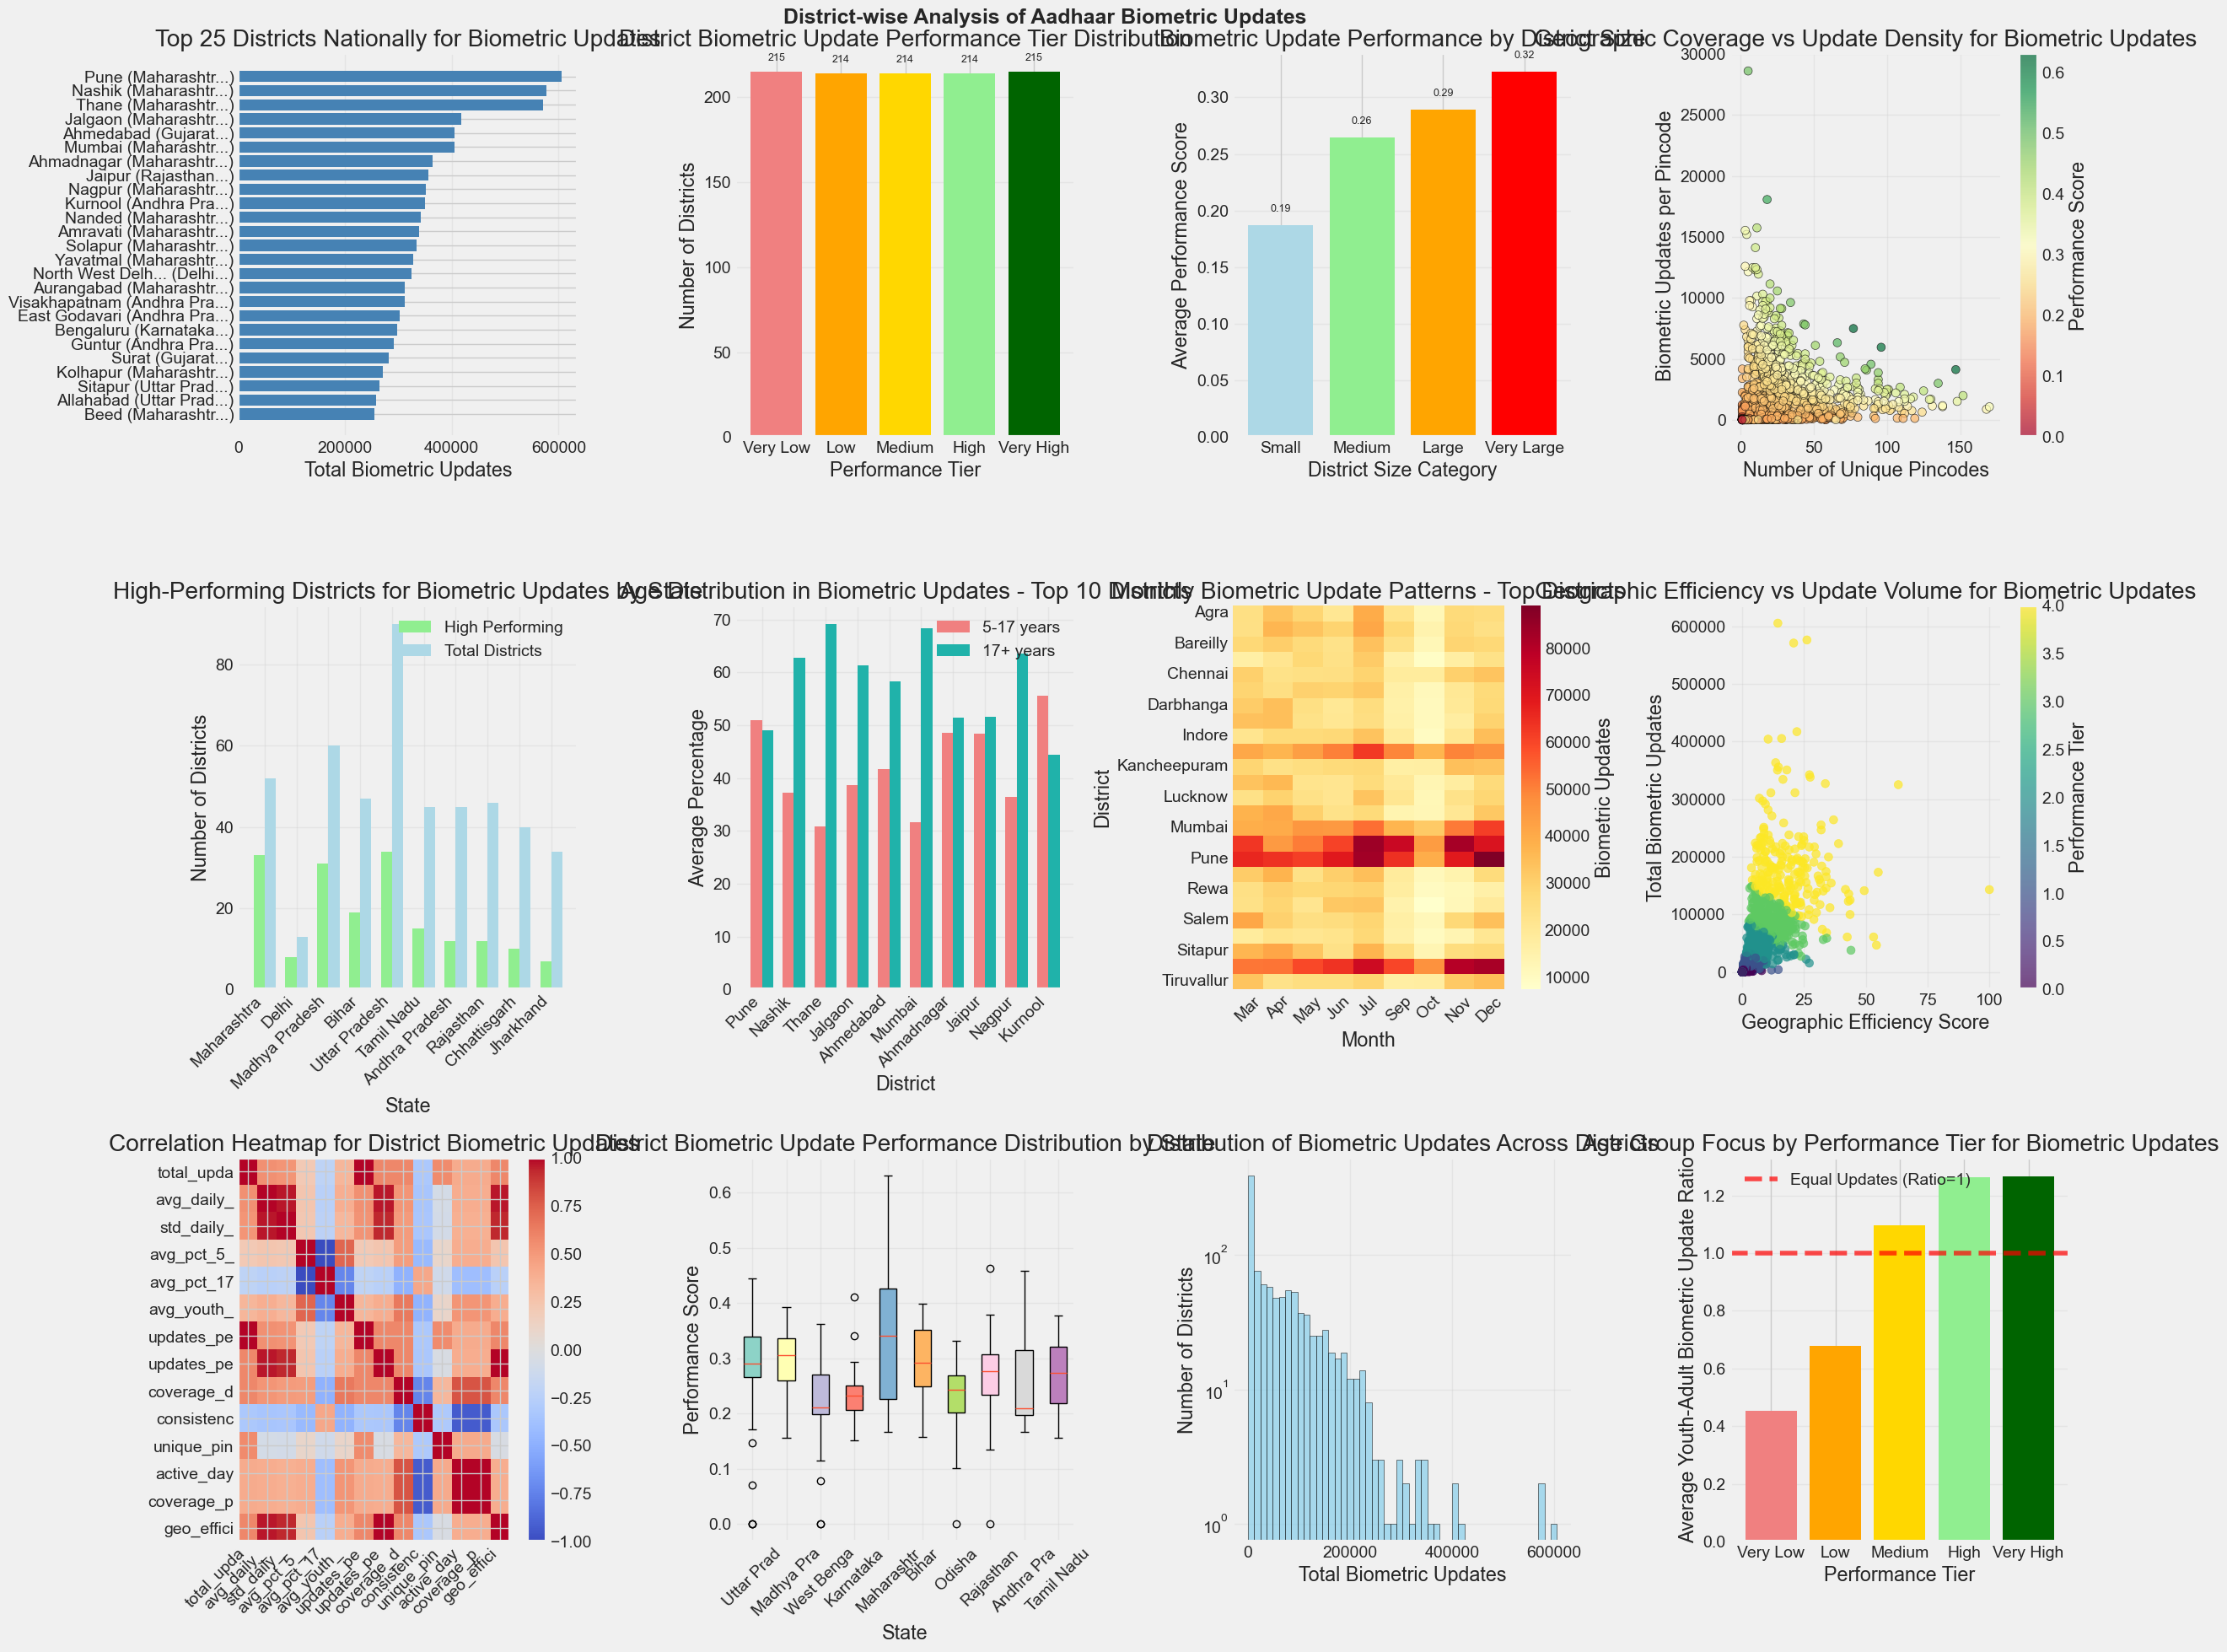

In [34]:
plt.style.use('fivethirtyeight')

# Create comprehensive visualizations
fig = plt.figure(figsize=(25, 20))
fig.suptitle('District-wise Analysis of Aadhaar Biometric Updates', fontsize=18, fontweight='bold')

# Plot 1: Top 25 districts nationally for biometric updates
ax1 = plt.subplot(3, 4, 1)
top_25 = district_analysis.nlargest(25, 'total_updates')
ax1.barh(range(len(top_25)), top_25['total_updates'], color='steelblue')
ax1.set_yticks(range(len(top_25)))
ax1.set_yticklabels(top_25.apply(lambda x: f"{x['district'][:15]}... ({x['state'][:10]}...)" 
                                 if len(x['district']) > 15 else f"{x['district']} ({x['state'][:10]}...)", axis=1))
ax1.set_xlabel('Total Biometric Updates')
ax1.set_title('Top 25 Districts Nationally for Biometric Updates')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Performance tier distribution
ax2 = plt.subplot(3, 4, 2)
tier_counts = district_analysis['performance_tier'].value_counts().sort_index()
colors = ['lightcoral', 'orange', 'gold', 'lightgreen', 'darkgreen']
bars = ax2.bar(tier_counts.index, tier_counts.values, color=colors)
ax2.set_xlabel('Performance Tier')
ax2.set_ylabel('Number of Districts')
ax2.set_title('District Biometric Update Performance Tier Distribution')
for bar, count in zip(bars, tier_counts.values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
            str(count), ha='center', va='bottom', fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: District size vs performance for biometric updates
ax3 = plt.subplot(3, 4, 3)
size_perf_plot = district_analysis.groupby('size_category')['performance_score'].mean()
colors_size = ['lightblue', 'lightgreen', 'orange', 'red']
bars_size = ax3.bar(size_perf_plot.index, size_perf_plot.values, color=colors_size)
ax3.set_xlabel('District Size Category')
ax3.set_ylabel('Average Performance Score')
ax3.set_title('Biometric Update Performance by District Size')
for bar, value in zip(bars_size, size_perf_plot.values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{value:.2f}', ha='center', va='bottom', fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Updates per pincode vs unique pincodes for biometric updates
ax4 = plt.subplot(3, 4, 4)
scatter = ax4.scatter(district_analysis['unique_pincodes'], 
                     district_analysis['updates_per_pincode'],
                     c=district_analysis['performance_score'], 
                     cmap='RdYlGn', s=50, alpha=0.7, edgecolors='black')
ax4.set_xlabel('Number of Unique Pincodes')
ax4.set_ylabel('Biometric Updates per Pincode')
ax4.set_title('Geographic Coverage vs Update Density for Biometric Updates')
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Performance Score')

# Plot 5: State-wise high-performing districts for biometric updates
ax5 = plt.subplot(3, 4, 5)
top_10_hp_states = state_district_summary.nlargest(10, 'high_performing_ratio')
x = np.arange(len(top_10_hp_states))
width = 0.35
bars5a = ax5.bar(x - width/2, top_10_hp_states['high_performing_districts'], width, label='High Performing', color='lightgreen')
bars5b = ax5.bar(x + width/2, top_10_hp_states['num_districts'], width, label='Total Districts', color='lightblue')
ax5.set_xlabel('State')
ax5.set_ylabel('Number of Districts')
ax5.set_title('High-Performing Districts for Biometric Updates by State')
ax5.set_xticks(x)
ax5.set_xticklabels(top_10_hp_states['state'], rotation=45, ha='right')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Age distribution in top districts for biometric updates
ax6 = plt.subplot(3, 4, 6)
top_10_age = district_analysis.nlargest(10, 'total_updates')
x = np.arange(len(top_10_age))
width = 0.35
bars6a = ax6.bar(x - width/2, top_10_age['avg_pct_5_17'], width, label='5-17 years', color='lightcoral')
bars6b = ax6.bar(x + width/2, top_10_age['avg_pct_17_plus'], width, label='17+ years', color='lightseagreen')
ax6.set_xlabel('District')
ax6.set_ylabel('Average Percentage')
ax6.set_title('Age Distribution in Biometric Updates - Top 10 Districts')
ax6.set_xticks(x)
district_labels = [f"{d[:10]}..." if len(d) > 10 else d for d in top_10_age['district']]
ax6.set_xticklabels(district_labels, rotation=45, ha='right')
ax6.legend()
ax6.grid(True, alpha=0.3)

# Plot 7: Monthly patterns heatmap for top 5 states' districts
ax7 = plt.subplot(3, 4, 7)
top_5_states = state_district_summary.nlargest(5, 'state_total_updates')['state'].tolist()
districts_top_states = district_analysis[district_analysis['state'].isin(top_5_states)]
top_districts_per_state = districts_top_states.groupby('state').apply(lambda x: x.nlargest(5, 'total_updates')).reset_index(drop=True)

# Create a sample heatmap for top districts
if len(top_districts_per_state) > 0:
    monthly_sample = monthly_district.merge(top_districts_per_state[['state', 'district']], on=['state', 'district'])
    heatmap_pivot = monthly_sample.pivot_table(index='district', columns='month', values='total_bio_updates', aggfunc='sum')
    
    # Get months present in data
    months_present = sorted(heatmap_pivot.columns.tolist())
    month_labels = [month_names[m-1] for m in months_present]
    
    sns.heatmap(heatmap_pivot, cmap='YlOrRd', ax=ax7, cbar_kws={'label': 'Biometric Updates'})
    ax7.set_xlabel('Month')
    ax7.set_ylabel('District')
    ax7.set_title('Monthly Biometric Update Patterns - Top Districts')
    
    # Set x-tick labels for months present
    ax7.set_xticks(np.arange(len(months_present)) + 0.5)
    ax7.set_xticklabels(month_labels, rotation=45)
else:
    ax7.text(0.5, 0.5, 'Insufficient data\nfor heatmap', 
             ha='center', va='center', transform=ax7.transAxes, fontsize=12)
    ax7.set_title('Monthly Biometric Update Patterns')

# Plot 8: Geographic efficiency vs total biometric updates
ax8 = plt.subplot(3, 4, 8)
scatter2 = ax8.scatter(district_analysis['geo_efficiency'], 
                      district_analysis['total_updates'],
                      c=district_analysis['performance_tier'].cat.codes, 
                      cmap='viridis', s=50, alpha=0.7)
ax8.set_xlabel('Geographic Efficiency Score')
ax8.set_ylabel('Total Biometric Updates')
ax8.set_title('Geographic Efficiency vs Update Volume for Biometric Updates')
ax8.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax8, label='Performance Tier')

# Plot 9: Correlation heatmap for biometric updates
ax9 = plt.subplot(3, 4, 9)
corr_plot = ax9.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
ax9.set_xticks(range(len(corr_matrix.columns)))
ax9.set_yticks(range(len(corr_matrix.columns)))
ax9.set_xticklabels([col[:10] for col in corr_matrix.columns], rotation=45, ha='right')
ax9.set_yticklabels([col[:10] for col in corr_matrix.columns])
ax9.set_title('Correlation Heatmap for District Biometric Updates')
plt.colorbar(corr_plot, ax=ax9)

# Plot 10: District performance by state (box plot) for biometric updates
ax10 = plt.subplot(3, 4, 10)
# Select top 10 states by number of districts
top_10_states_districts = state_district_summary.nlargest(10, 'num_districts')['state'].tolist()
boxplot_data = [district_analysis[district_analysis['state'] == state]['performance_score'].dropna() 
                for state in top_10_states_districts]
bp = ax10.boxplot(boxplot_data, patch_artist=True)
for patch, color in zip(bp['boxes'], plt.cm.Set3(np.arange(len(boxplot_data)))):
    patch.set_facecolor(color)
ax10.set_xlabel('State')
ax10.set_ylabel('Performance Score')
ax10.set_title('District Biometric Update Performance Distribution by State')
ax10.set_xticklabels([s[:10] for s in top_10_states_districts], rotation=45)
ax10.grid(True, alpha=0.3)

# Plot 11: Biometric updates distribution histogram
ax11 = plt.subplot(3, 4, 11)
ax11.hist(district_analysis['total_updates'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax11.set_xlabel('Total Biometric Updates')
ax11.set_ylabel('Number of Districts')
ax11.set_title('Distribution of Biometric Updates Across Districts')
ax11.set_yscale('log')  # Use log scale for better visualization
ax11.grid(True, alpha=0.3)

# Plot 12: Youth-adult biometric update ratio by performance tier
ax12 = plt.subplot(3, 4, 12)
tier_ratio_data = district_analysis.groupby('performance_tier')['avg_youth_bio_ratio'].mean()
colors_tier = ['lightcoral', 'orange', 'gold', 'lightgreen', 'darkgreen']
bars_tier = ax12.bar(tier_ratio_data.index, tier_ratio_data.values, color=colors_tier)
ax12.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Equal Updates (Ratio=1)')
ax12.set_xlabel('Performance Tier')
ax12.set_ylabel('Average Youth-Adult Biometric Update Ratio')
ax12.set_title('Age Group Focus by Performance Tier for Biometric Updates')
ax12.legend()
ax12.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

#### 4.3.12 [ KEY INSIGHTS SUMMARY ]

In [35]:
print("\n" + "="*100)
print("12. KEY INSIGHTS SUMMARY FOR DISTRICT BIOMETRIC UPDATES")
print("="*100)

# Insight 1: Overall statistics
total_updates = district_analysis['total_updates'].sum()
print(f"\n1. OVERALL STATISTICS:")
print(f"   - Total districts analyzed: {len(district_analysis)}")
print(f"   - Total biometric updates across districts: {total_updates:,}")
print(f"   - Average biometric updates per district: {district_analysis['total_updates'].mean():,.0f}")

# Insight 2: Top performing districts
top_district_info = district_analysis.nlargest(1, 'total_updates').iloc[0]
print(f"\n2. TOP PERFORMING DISTRICT FOR BIOMETRIC UPDATES:")
print(f"   - {top_district_info['district']}, {top_district_info['state']}")
print(f"   - Total biometric updates: {top_district_info['total_updates']:,}")
print(f"   - Performance tier: {top_district_info['performance_tier']}")
print(f"   - Geographic coverage: {top_district_info['unique_pincodes']} pincodes")

# Insight 3: Performance distribution
print(f"\n3. PERFORMANCE DISTRIBUTION:")
very_high_count = len(district_analysis[district_analysis['performance_tier'] == 'Very High'])
low_count = len(district_analysis[district_analysis['performance_tier'].isin(['Low', 'Very Low'])])
print(f"   - High/Very High performing districts: {very_high_count} ({very_high_count/len(district_analysis)*100:.1f}%)")
print(f"   - Low/Very Low performing districts: {low_count} ({low_count/len(district_analysis)*100:.1f}%)")

# Insight 4: Geographic patterns for biometric updates
print(f"\n4. GEOGRAPHIC PATTERNS FOR BIOMETRIC UPDATES:")
print(f"   - Districts with wide coverage (>100 pincodes): {len(district_analysis[district_analysis['unique_pincodes'] > 100])}")
print(f"   - Average pincodes per district: {district_analysis['unique_pincodes'].mean():.1f}")
print(f"   - Average biometric updates per pincode: {district_analysis['updates_per_pincode'].mean():.1f}")

# Insight 5: Age group patterns for biometric updates
print(f"\n5. AGE GROUP PATTERNS FOR BIOMETRIC UPDATES:")
print(f"   - Average youth (5-17) biometric update percentage: {district_analysis['avg_pct_5_17'].mean():.1f}%")
print(f"   - Districts with youth-focused biometric updates (>60%): {len(district_analysis[district_analysis['bio_age_focus'] == 'Youth Focused'])}")
print(f"   - Districts with adult-focused biometric updates (>60%): {len(district_analysis[district_analysis['bio_age_focus'] == 'Adult Focused'])}")

# Insight 6: State performance analysis for biometric updates
print(f"\n6. STATE PERFORMANCE ANALYSIS FOR BIOMETRIC UPDATES:")
top_state_perf = state_district_summary.nlargest(1, 'high_performing_ratio').iloc[0]
print(f"   - State with highest % of high-performing districts: {top_state_perf['state']} ({top_state_perf['high_performing_ratio']:.1f}%)")
print(f"   - Average districts per state: {state_district_summary['num_districts'].mean():.1f}")
print(f"   - Average biometric updates per district per state: {state_district_summary['avg_district_updates'].mean():.0f}")

# Insight 7: Size-performance relationship for biometric updates
print(f"\n7. SIZE-PERFORMANCE RELATIONSHIP FOR BIOMETRIC UPDATES:")
best_size = size_performance['performance_score'].idxmax()
worst_size = size_performance['performance_score'].idxmin()
print(f"   - Best performing size category: {best_size}")
print(f"   - Worst performing size category: {worst_size}")
print(f"   - Large districts average updates: {size_performance.loc['Large', 'total_updates']:,.0f}")
print(f"   - Small districts average updates: {size_performance.loc['Small', 'total_updates']:,.0f}")

# Insight 8: Recommendations for biometric updates
print(f"\n8. STRATEGIC RECOMMENDATIONS FOR BIOMETRIC UPDATES:")
print("   - Focus on improving low-performing districts' biometric infrastructure")
print("   - Study and replicate best practices from high-performing districts")
print("   - Tailor biometric update approaches based on district size and age focus")
print("   - Monitor districts with high growth potential for biometric updates")
print("   - Address geographic coverage gaps in districts with low pincode coverage")
print("   - Prioritize youth biometric updates in districts with high child population")
print("   - Implement targeted campaigns based on monthly biometric update patterns")

print("\n" + "="*100)
print("ANALYSIS COMPLETE")
print("="*100)


12. KEY INSIGHTS SUMMARY FOR DISTRICT BIOMETRIC UPDATES

1. OVERALL STATISTICS:
   - Total districts analyzed: 1072
   - Total biometric updates across districts: 69,763,095
   - Average biometric updates per district: 65,078

2. TOP PERFORMING DISTRICT FOR BIOMETRIC UPDATES:
   - Pune, Maharashtra
   - Total biometric updates: 605,762
   - Performance tier: Very High
   - Geographic coverage: 147 pincodes

3. PERFORMANCE DISTRIBUTION:
   - High/Very High performing districts: 215 (20.1%)
   - Low/Very Low performing districts: 429 (40.0%)

4. GEOGRAPHIC PATTERNS FOR BIOMETRIC UPDATES:
   - Districts with wide coverage (>100 pincodes): 34
   - Average pincodes per district: 29.2
   - Average biometric updates per pincode: 2335.2

5. AGE GROUP PATTERNS FOR BIOMETRIC UPDATES:
   - Average youth (5-17) biometric update percentage: 43.4%
   - Districts with youth-focused biometric updates (>60%): 199
   - Districts with adult-focused biometric updates (>60%): 397

6. STATE PERFORMANCE ANA

#### 4.3.13 [ EXPORT KEY FINDINGS ]

In [36]:
print("\n" + "="*100)
print("13. DISTRICT BIOMETRIC UPDATE PERFORMANCE SUMMARY (Top 30)")
print("="*100)

summary_columns = ['state', 'district', 'total_updates', 'performance_tier',
                  'size_category', 'bio_age_focus', 'avg_daily_updates', 
                  'updates_per_pincode', 'coverage_percentage', 'geo_efficiency',
                  'avg_pct_5_17', 'avg_pct_17_plus', 'avg_youth_bio_ratio',
                  'unique_pincodes', 'active_days']

summary_report = district_analysis[summary_columns].sort_values('total_updates', ascending=False)
print(summary_report.head(30).to_string(index=False))

# Export state-wise district performance for biometric updates
print("\n" + "="*100)
print("STATE-WISE DISTRICT PERFORMANCE SUMMARY FOR BIOMETRIC UPDATES")
print("="*100)

for state in sorted(district_analysis['state'].unique()):
    state_data = district_analysis[district_analysis['state'] == state]
    if len(state_data) > 0:
        top_state_district = state_data.nlargest(1, 'total_updates').iloc[0]
        avg_updates = state_data['total_updates'].mean()
        high_perf_count = len(state_data[state_data['performance_tier'] == 'Very High'])
        youth_focused_count = len(state_data[state_data['bio_age_focus'] == 'Youth Focused'])
        
        print(f"\n{state}:")
        print(f"  Districts: {len(state_data)}")
        print(f"  Total Biometric Updates: {state_data['total_updates'].sum():,}")
        print(f"  Average per District: {avg_updates:,.0f}")
        print(f"  Top District: {top_state_district['district']} "
              f"({top_state_district['total_updates']:,} biometric updates)")
        print(f"  High-Performing Districts: {high_perf_count}")
        print(f"  Youth-Focused Districts: {youth_focused_count}")


13. DISTRICT BIOMETRIC UPDATE PERFORMANCE SUMMARY (Top 30)
         state         district  total_updates performance_tier size_category bio_age_focus  avg_daily_updates  updates_per_pincode  coverage_percentage  geo_efficiency  avg_pct_5_17  avg_pct_17_plus  avg_youth_bio_ratio  unique_pincodes  active_days
   Maharashtra             Pune         605762        Very High    Very Large      Balanced              52.28          4120.829932            98.876404       14.398830         50.96            49.04                 1.36              147           88
   Maharashtra           Nashik         576606        Very High         Large Adult Focused              94.49          7488.389610            97.752809       26.165615         37.22            62.78                 0.81               77           87
   Maharashtra            Thane         571273        Very High         Large Adult Focused              78.80          5950.760417            98.876404       20.792896         30.84     

#### 4.3.14 [ ADDITIONAL BIOMETRIC-SPECIFIC ANALYSES ]

In [37]:
print("\n" + "="*100)
print("14. ADDITIONAL BIOMETRIC-SPECIFIC ANALYSES")
print("="*100)

# Biometric update efficiency by district size
print("\nA. BIOMETRIC UPDATE EFFICIENCY BY DISTRICT SIZE:")
for size in size_performance.index:
    size_data = district_analysis[district_analysis['size_category'] == size]
    if len(size_data) > 0:
        avg_efficiency = size_data['updates_per_pincode'].mean()
        avg_consistency = size_data['consistency_score'].mean()
        print(f"  {size} districts:")
        print(f"    - Avg updates per pincode: {avg_efficiency:.1f}")
        print(f"    - Avg consistency score: {avg_consistency:.2f}")
        print(f"    - Count: {len(size_data)} districts")

# Age focus patterns by district size
print("\nB. AGE FOCUS PATTERNS BY DISTRICT SIZE FOR BIOMETRIC UPDATES:")
for size in size_performance.index:
    size_data = district_analysis[district_analysis['size_category'] == size]
    if len(size_data) > 0:
        youth_pct = (size_data['bio_age_focus'] == 'Youth Focused').mean() * 100
        adult_pct = (size_data['bio_age_focus'] == 'Adult Focused').mean() * 100
        balanced_pct = (size_data['bio_age_focus'] == 'Balanced').mean() * 100
        print(f"  {size} districts:")
        print(f"    - Youth Focused: {youth_pct:.1f}%")
        print(f"    - Adult Focused: {adult_pct:.1f}%")
        print(f"    - Balanced: {balanced_pct:.1f}%")

# Top performing districts by different metrics
print("\nC. TOP PERFORMING DISTRICTS BY DIFFERENT METRICS:")

print("\n  By Geographic Efficiency:")
geo_efficient_top = district_analysis.nlargest(5, 'geo_efficiency')[['state', 'district', 'geo_efficiency', 'updates_per_pincode', 'total_updates']]
for _, row in geo_efficient_top.iterrows():
    print(f"    - {row['district']}, {row['state']}: {row['geo_efficiency']:.1f} efficiency score")

print("\n  By Consistency:")
consistent_top = district_analysis.nlargest(5, 'consistency_score')[['state', 'district', 'consistency_score', 'avg_daily_updates', 'std_daily_updates']]
for _, row in consistent_top.iterrows():
    print(f"    - {row['district']}, {row['state']}: {row['consistency_score']:.2f} consistency score")

print("\n  By Youth Focus (for child biometric updates):")
youth_focused_top = district_analysis[district_analysis['bio_age_focus'] == 'Youth Focused'].nlargest(5, 'total_updates')[['state', 'district', 'total_updates', 'avg_pct_5_17']]
for _, row in youth_focused_top.iterrows():
    print(f"    - {row['district']}, {row['state']}: {row['total_updates']:,} updates, {row['avg_pct_5_17']:.1f}% youth")

# Final summary
print("\nD. FINAL SUMMARY FOR BIOMETRIC UPDATES AT DISTRICT LEVEL:")
final_summary = {
    'Total Districts Analyzed': len(district_analysis),
    'Total Biometric Updates': f"{total_updates:,}",
    'Average Updates per District': f"{district_analysis['total_updates'].mean():,.0f}",
    'Average Geographic Efficiency': f"{district_analysis['geo_efficiency'].mean():.1f}",
    'Average Coverage Days': f"{district_analysis['coverage_percentage'].mean():.1f}%",
    'Youth-Focused Districts': f"{len(district_analysis[district_analysis['bio_age_focus'] == 'Youth Focused'])}",
    'High/Very High Performing Districts': f"{len(district_analysis[district_analysis['performance_tier'].isin(['High', 'Very High'])])}",
    'Top District': f"{top_district_info['district']}, {top_district_info['state']}"
}

for key, value in final_summary.items():
    print(f"  {key}: {value}")

print("\n" + "="*100)
print("ALL DISTRICT-WISE BIOMETRIC UPDATE ANALYSES COMPLETED SUCCESSFULLY!")
print("="*100)


14. ADDITIONAL BIOMETRIC-SPECIFIC ANALYSES

A. BIOMETRIC UPDATE EFFICIENCY BY DISTRICT SIZE:
  Small districts:
    - Avg updates per pincode: 1458.6
    - Avg consistency score: 0.32
    - Count: 314 districts
  Medium districts:
    - Avg updates per pincode: 3042.3
    - Avg consistency score: 0.03
    - Count: 566 districts
  Large districts:
    - Avg updates per pincode: 1739.0
    - Avg consistency score: 0.00
    - Count: 158 districts
  Very Large districts:
    - Avg updates per pincode: 1430.3
    - Avg consistency score: 0.00
    - Count: 34 districts

B. AGE FOCUS PATTERNS BY DISTRICT SIZE FOR BIOMETRIC UPDATES:
  Small districts:
    - Youth Focused: 22.3%
    - Adult Focused: 51.3%
    - Balanced: 26.4%
  Medium districts:
    - Youth Focused: 19.3%
    - Adult Focused: 29.7%
    - Balanced: 51.1%
  Large districts:
    - Youth Focused: 12.0%
    - Adult Focused: 33.5%
    - Balanced: 54.4%
  Very Large districts:
    - Youth Focused: 2.9%
    - Adult Focused: 44.1%
   

### 4.4 Age-wise Analysis of Aadhaar Biometric Updates

#### 4.4.1 [ TEMPORAL AGE-WISE ANALYSI ]

In [38]:
print("\n" + "="*80)
print("TEMPORAL AGE-WISE ANALYSIS")
print("="*80)

# Yearly trend by age group
yearly_age_trend = df.groupby('year')[['bio_age_5_17', 'bio_age_17_']].sum().reset_index()
yearly_age_trend['total'] = yearly_age_trend['bio_age_5_17'] + yearly_age_trend['bio_age_17_']
yearly_age_trend['pct_5_17'] = (yearly_age_trend['bio_age_5_17'] / yearly_age_trend['total']) * 100
yearly_age_trend['pct_17_plus'] = (yearly_age_trend['bio_age_17_'] / yearly_age_trend['total']) * 100

print("\nYearly Trend by Age Group:")
print(yearly_age_trend)

# Monthly/Quarterly patterns
monthly_age_trend = df.groupby(['year', 'month'])[['bio_age_5_17', 'bio_age_17_']].sum().reset_index()
monthly_age_trend['total'] = monthly_age_trend['bio_age_5_17'] + monthly_age_trend['bio_age_17_']
monthly_age_trend['age_ratio'] = monthly_age_trend['bio_age_5_17'] / monthly_age_trend['bio_age_17_'].replace(0, np.nan)

quarterly_age_trend = df.groupby(['year', 'quarter'])[['bio_age_5_17', 'bio_age_17_']].sum().reset_index()


TEMPORAL AGE-WISE ANALYSIS

Yearly Trend by Age Group:
   year  bio_age_5_17  bio_age_17_     total   pct_5_17  pct_17_plus
0  2025      34226855     35536240  69763095  49.061549    50.938451


#### 4.4.2 [ GEOGRAPHICAL AGE-WISE ANALYSIS ] 

In [39]:
print("\n" + "="*80)
print("GEOGRAPHICAL AGE-WISE ANALYSIS")
print("="*80)

# State-wise analysis
state_age_analysis = df.groupby('state').agg({
    'bio_age_5_17': 'sum',
    'bio_age_17_': 'sum',
    'district': 'nunique'
}).reset_index()

state_age_analysis['total'] = state_age_analysis['bio_age_5_17'] + state_age_analysis['bio_age_17_']
state_age_analysis['child_adult_ratio'] = state_age_analysis['bio_age_5_17'] / state_age_analysis['bio_age_17_'].replace(0, np.nan)
state_age_analysis['pct_child_updates'] = (state_age_analysis['bio_age_5_17'] / state_age_analysis['total']) * 100
state_age_analysis = state_age_analysis.sort_values('total', ascending=False)

print(f"\nTop 10 States by Total Biometric Updates:")
print(state_age_analysis[['state', 'total', 'bio_age_5_17', 'bio_age_17_', 'pct_child_updates']].head(10))

print(f"\nBottom 10 States by Total Biometric Updates:")
print(state_age_analysis[['state', 'total', 'bio_age_5_17', 'bio_age_17_', 'pct_child_updates']].tail(10))

# District-wise analysis (for top states)
top_states = state_age_analysis.head(5)['state'].tolist()
district_age_analysis = df[df['state'].isin(top_states)].groupby(['state', 'district']).agg({
    'bio_age_5_17': 'sum',
    'bio_age_17_': 'sum'
}).reset_index()


GEOGRAPHICAL AGE-WISE ANALYSIS

Top 10 States by Total Biometric Updates:
             state    total  bio_age_5_17  bio_age_17_  pct_child_updates
44   Uttar Pradesh  9577735       6207105      3370630          64.807650
27     Maharashtra  9226139       3512712      5713427          38.073478
26  Madhya Pradesh  5923771       3200117      2723654          54.021619
5            Bihar  4897587       2208141      2689446          45.086305
40      Tamil Nadu  4698117       2227252      2470865          47.407334
38       Rajasthan  3994955       2066747      1928208          51.733924
2   Andhra Pradesh  3714592       2241448      1473144          60.341701
16         Gujarat  3196514       1460655      1735859          45.695248
8     Chhattisgarh  2648729        884553      1764176          33.395376
22       Karnataka  2635954       1244999      1390955          47.231439

Bottom 10 States by Total Biometric Updates:
           state  total  bio_age_5_17  bio_age_17_  pct_child_upd

#### 4.4.3 [ AGE GROUP DISTRIBUTION ANALYSIS ]

In [40]:
print("\n" + "="*80)
print("AGE GROUP DISTRIBUTION ANALYSIS")
print("="*80)

# Overall distribution
total_child = df['bio_age_5_17'].sum()
total_adult = df['bio_age_17_'].sum()
overall_total = total_child + total_adult

print(f"\nOverall Distribution:")
print(f"5-17 years: {total_child:,} ({total_child/overall_total*100:.2f}%)")
print(f"17+ years:  {total_adult:,} ({total_adult/overall_total*100:.2f}%)")
print(f"Child-to-Adult Ratio: {total_child/total_adult:.3f}")

# Distribution statistics
print(f"\nAge Group Statistics:")
print(f"Average daily updates for 5-17: {df['bio_age_5_17'].mean():.2f}")
print(f"Average daily updates for 17+:  {df['bio_age_17_'].mean():.2f}")
print(f"Median daily updates for 5-17:  {df['bio_age_5_17'].median():.2f}")
print(f"Median daily updates for 17+:   {df['bio_age_17_'].median():.2f}")


AGE GROUP DISTRIBUTION ANALYSIS

Overall Distribution:
5-17 years: 34,226,855 (49.06%)
17+ years:  35,536,240 (50.94%)
Child-to-Adult Ratio: 0.963

Age Group Statistics:
Average daily updates for 5-17: 18.39
Average daily updates for 17+:  19.09
Median daily updates for 5-17:  3.00
Median daily updates for 17+:   4.00


#### 4.4.4 [ SEASONALITY AND PATTERNS BY AGE GROUP ]

In [41]:
# Monthly patterns
monthly_pattern = df.groupby('month').agg({
    'bio_age_5_17': 'mean',
    'bio_age_17_': 'mean'
}).reset_index()

# Day of week patterns
dow_pattern = df.groupby('day_of_week').agg({
    'bio_age_5_17': 'mean',
    'bio_age_17_': 'mean'
}).reset_index()
dow_pattern['day_name'] = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

#### 4.4.5 [ GROWTH AND CHANGE ANALYSIS ]

In [42]:
print("\n" + "="*80)
print("GROWTH ANALYSIS BY AGE GROUP")
print("="*80)

# Calculate monthly growth rates
monthly_totals = df.groupby('month_year').agg({
    'bio_age_5_17': 'sum',
    'bio_age_17_': 'sum'
}).reset_index().sort_values('month_year')

monthly_totals['total'] = monthly_totals['bio_age_5_17'] + monthly_totals['bio_age_17_']
monthly_totals['child_growth'] = monthly_totals['bio_age_5_17'].pct_change() * 100
monthly_totals['adult_growth'] = monthly_totals['bio_age_17_'].pct_change() * 100
monthly_totals['total_growth'] = monthly_totals['total'].pct_change() * 100

print("\nMonthly Growth Rates (last 5 months):")
print(monthly_totals[['month_year', 'child_growth', 'adult_growth', 'total_growth']].tail(5))


GROWTH ANALYSIS BY AGE GROUP

Monthly Growth Rates (last 5 months):
  month_year  child_growth  adult_growth  total_growth
4    2025-07     21.263513     26.362332     23.967512
5    2025-09    -19.749916    -42.487317    -32.040923
6    2025-10    -38.640581    -22.242449    -31.138924
7    2025-11     62.901669     55.310008     58.980024
8    2025-12     28.132437     10.975666     19.474310


#### 4.4.6 [ CORRELATION ANALYSIS ]

In [43]:
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

correlation_matrix = df[['bio_age_5_17', 'bio_age_17_', 'total_bio_updates', 
                         'pct_5_17', 'pct_17_plus', 'youth_bio_ratio']].corr()

print("\nCorrelation Matrix:")
print(correlation_matrix.round(3))


CORRELATION ANALYSIS

Correlation Matrix:
                   bio_age_5_17  bio_age_17_  total_bio_updates  pct_5_17  \
bio_age_5_17              1.000        0.786              0.942     0.067   
bio_age_17_               0.786        1.000              0.948    -0.039   
total_bio_updates         0.942        0.948              1.000     0.014   
pct_5_17                  0.067       -0.039              0.014     1.000   
pct_17_plus              -0.067        0.039             -0.013    -1.000   
youth_bio_ratio           0.088       -0.022              0.033     0.408   

                   pct_17_plus  youth_bio_ratio  
bio_age_5_17            -0.067            0.088  
bio_age_17_              0.039           -0.022  
total_bio_updates       -0.013            0.033  
pct_5_17                -1.000            0.408  
pct_17_plus              1.000           -0.408  
youth_bio_ratio         -0.408            1.000  


#### 4.4.7 [ TOP PERFORMERS ANALYSIS ]

In [44]:
print("\n" + "="*80)
print("TOP PERFORMERS BY AGE GROUP")
print("="*80)

# Top districts for child updates
top_child_districts = df.groupby(['state', 'district'])['bio_age_5_17'].sum().nlargest(10).reset_index()
print("\nTop 10 Districts for Child/Adolescent Updates (5-17 years):")
print(top_child_districts)

# Top districts for adult updates
top_adult_districts = df.groupby(['state', 'district'])['bio_age_17_'].sum().nlargest(10).reset_index()
print("\nTop 10 Districts for Adult Updates (17+ years):")
print(top_adult_districts)


TOP PERFORMERS BY AGE GROUP

Top 10 Districts for Child/Adolescent Updates (5-17 years):
            state       district  bio_age_5_17
0     Maharashtra           Pune        283480
1  Andhra Pradesh        Kurnool        242992
2     Maharashtra         Nashik        213100
3  Andhra Pradesh  East Godavari        204904
4     Maharashtra          Thane        202896
5   Uttar Pradesh        Sitapur        200310
6  Andhra Pradesh  Visakhapatnam        195385
7  Andhra Pradesh         Guntur        187665
8   Uttar Pradesh      Allahabad        177827
9  Andhra Pradesh       Chittoor        168710

Top 10 Districts for Adult Updates (17+ years):
         state   district  bio_age_17_
0  Maharashtra      Thane       368377
1  Maharashtra     Nashik       363506
2  Maharashtra       Pune       322282
3  Maharashtra     Mumbai       284744
4  Maharashtra    Jalgaon       268531
5      Gujarat  Ahmedabad       239599
6  Maharashtra     Nagpur       238072
7  Maharashtra   Amravati       

#### 4.4.8 [ VISUALIZATION ]

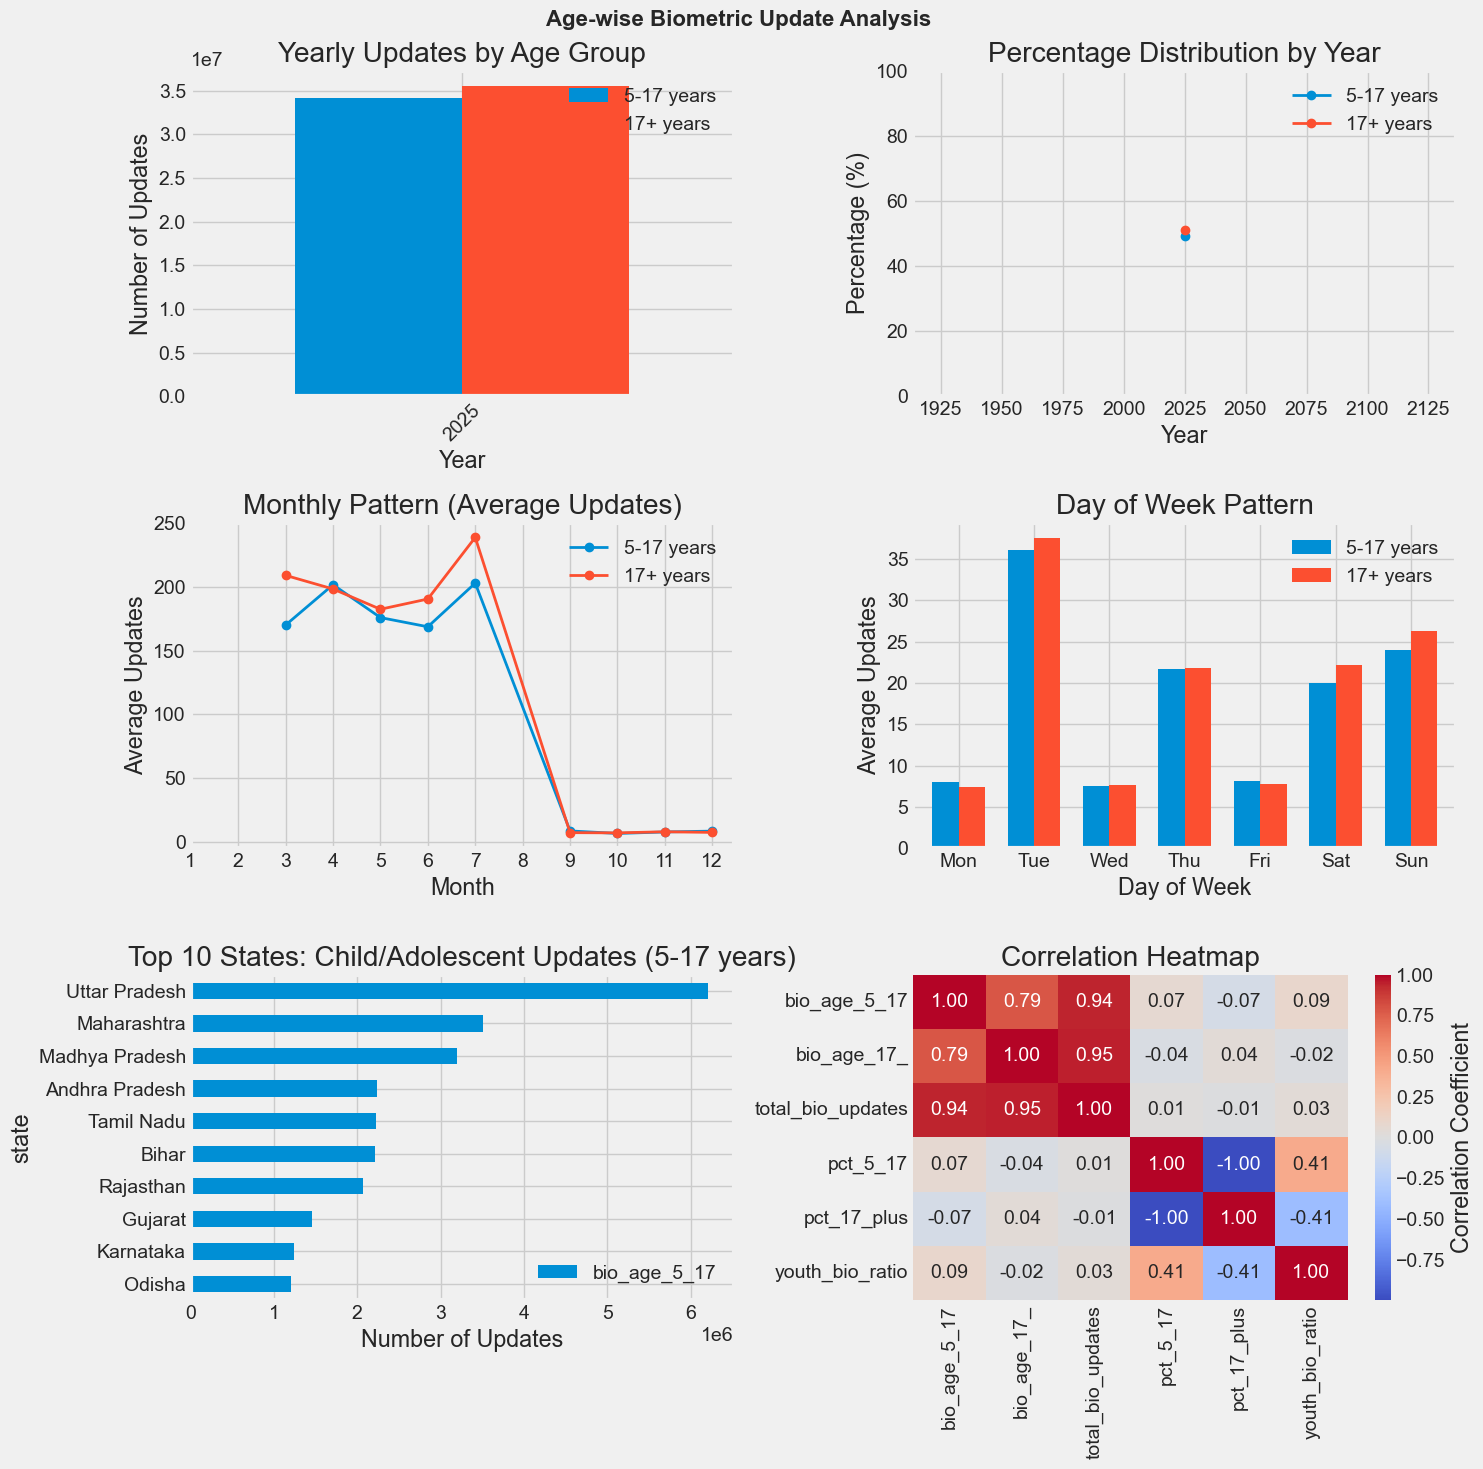

In [45]:
plt.style.use('fivethirtyeight')

# Create visualizations
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Age-wise Biometric Update Analysis', fontsize=16, fontweight='bold')

# Plot 1: Yearly trend
ax1 = axes[0, 0]
yearly_age_trend.plot(x='year', y=['bio_age_5_17', 'bio_age_17_'], kind='bar', ax=ax1, width=0.8)
ax1.set_title('Yearly Updates by Age Group')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Updates')
ax1.legend(['5-17 years', '17+ years'])
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Percentage trend
ax2 = axes[0, 1]
yearly_age_trend.plot(x='year', y=['pct_5_17', 'pct_17_plus'], kind='line', 
                      marker='o', ax=ax2, linewidth=2)
ax2.set_title('Percentage Distribution by Year')
ax2.set_xlabel('Year')
ax2.set_ylabel('Percentage (%)')
ax2.legend(['5-17 years', '17+ years'])
ax2.set_ylim(0, 100)

# Plot 3: Monthly pattern
ax3 = axes[1, 0]
monthly_pattern.plot(x='month', y=['bio_age_5_17', 'bio_age_17_'], kind='line', 
                     marker='o', ax=ax3, linewidth=2)
ax3.set_title('Monthly Pattern (Average Updates)')
ax3.set_xlabel('Month')
ax3.set_ylabel('Average Updates')
ax3.legend(['5-17 years', '17+ years'])
ax3.set_xticks(range(1, 13))

# Plot 4: Day of week pattern
ax4 = axes[1, 1]
dow_pattern.plot(x='day_name', y=['bio_age_5_17', 'bio_age_17_'], kind='bar', 
                 ax=ax4, width=0.7)
ax4.set_title('Day of Week Pattern')
ax4.set_xlabel('Day of Week')
ax4.set_ylabel('Average Updates')
ax4.legend(['5-17 years', '17+ years'])
ax4.tick_params(axis='x', rotation=0)

# Plot 5: Top states for child updates
ax5 = axes[2, 0]
top_states_child = state_age_analysis.nlargest(10, 'bio_age_5_17')
top_states_child.plot(x='state', y='bio_age_5_17', kind='barh', ax=ax5)
ax5.set_title('Top 10 States: Child/Adolescent Updates (5-17 years)')
ax5.set_xlabel('Number of Updates')
ax5.invert_yaxis()

# Plot 6: Correlation heatmap
ax6 = axes[2, 1]
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=ax6, cbar_kws={'label': 'Correlation Coefficient'})
ax6.set_title('Correlation Heatmap')

plt.tight_layout()
plt.show()

#### 4.4.9 [  ADDITIONAL INSIGHTS ]

In [46]:
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

# Calculate volatility
child_volatility = df['bio_age_5_17'].std() / df['bio_age_5_17'].mean() * 100
adult_volatility = df['bio_age_17_'].std() / df['bio_age_17_'].mean() * 100

print(f"\nVolatility Analysis:")
print(f"5-17 years volatility: {child_volatility:.2f}%")
print(f"17+ years volatility:  {adult_volatility:.2f}%")

# Identify anomalies (values beyond 2 standard deviations)
child_mean = df['bio_age_5_17'].mean()
child_std = df['bio_age_5_17'].std()
child_anomalies = df[df['bio_age_5_17'] > child_mean + 2 * child_std]

adult_mean = df['bio_age_17_'].mean()
adult_std = df['bio_age_17_'].std()
adult_anomalies = df[df['bio_age_17_'] > adult_mean + 2 * adult_std]

print(f"\nAnomaly Detection:")
print(f"Extreme child update days (>2σ): {len(child_anomalies)}")
print(f"Extreme adult update days (>2σ): {len(adult_anomalies)}")

if len(child_anomalies) > 0:
    print("\nTop extreme child update days:")
    print(child_anomalies[['date', 'state', 'district', 'bio_age_5_17']].nlargest(5, 'bio_age_5_17'))

# Peak analysis
peak_child_day = df.loc[df['bio_age_5_17'].idxmax()]
peak_adult_day = df.loc[df['bio_age_17_'].idxmax()]

print(f"\nPeak Update Days:")
print(f"Peak child updates: {peak_child_day['bio_age_5_17']:,} on {peak_child_day['date'].date()} in {peak_child_day['state']}")
print(f"Peak adult updates: {peak_adult_day['bio_age_17_']:,} on {peak_adult_day['date'].date()} in {peak_adult_day['state']}")


KEY INSIGHTS

Volatility Analysis:
5-17 years volatility: 455.15%
17+ years volatility:  461.22%

Anomaly Detection:
Extreme child update days (>2σ): 32275
Extreme adult update days (>2σ): 33563

Top extreme child update days:
            date           state          district  bio_age_5_17
35938 2025-04-01   Uttar Pradesh         Firozabad          8002
40099 2025-04-01   Uttar Pradesh         Moradabad          7657
29872 2025-04-01  Madhya Pradesh         Singrauli          7085
28233 2025-04-01           Delhi  North East Delhi          6921
41596 2025-04-01  Madhya Pradesh             Sidhi          6433

Peak Update Days:
Peak child updates: 8,002 on 2025-04-01 in Uttar Pradesh
Peak adult updates: 7,625 on 2025-04-01 in Delhi


#### 4.4.10 [ EXPORT ANALYSIS RESULTS ]

In [47]:
# Create summary dataframe
summary = {
    'Metric': ['Total Updates', 'Child Updates (5-17)', 'Adult Updates (17+)', 
               'Child Percentage', 'Adult Percentage', 'Child-to-Adult Ratio',
               'Avg Daily Child', 'Avg Daily Adult', 'Peak Child Day', 'Peak Adult Day'],
    'Value': [f"{overall_total:,}", f"{total_child:,}", f"{total_adult:,}",
              f"{total_child/overall_total*100:.2f}%", f"{total_adult/overall_total*100:.2f}%",
              f"{total_child/total_adult:.3f}", f"{df['bio_age_5_17'].mean():.1f}",
              f"{df['bio_age_17_'].mean():.1f}", peak_child_day['date'].strftime('%Y-%m-%d'),
              peak_adult_day['date'].strftime('%Y-%m-%d')]
}

summary_df = pd.DataFrame(summary)
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(summary_df.to_string(index=False))

# Export to CSV
summary_df.to_csv('age_wise_biometric_analysis_summary.csv', index=False)
state_age_analysis.to_csv('state_age_analysis.csv', index=False)
yearly_age_trend.to_csv('yearly_age_trend.csv', index=False)

print("\nAnalysis completed and results exported to CSV files!")


SUMMARY STATISTICS
              Metric      Value
       Total Updates 69,763,095
Child Updates (5-17) 34,226,855
 Adult Updates (17+) 35,536,240
    Child Percentage     49.06%
    Adult Percentage     50.94%
Child-to-Adult Ratio      0.963
     Avg Daily Child       18.4
     Avg Daily Adult       19.1
      Peak Child Day 2025-04-01
      Peak Adult Day 2025-04-01

Analysis completed and results exported to CSV files!


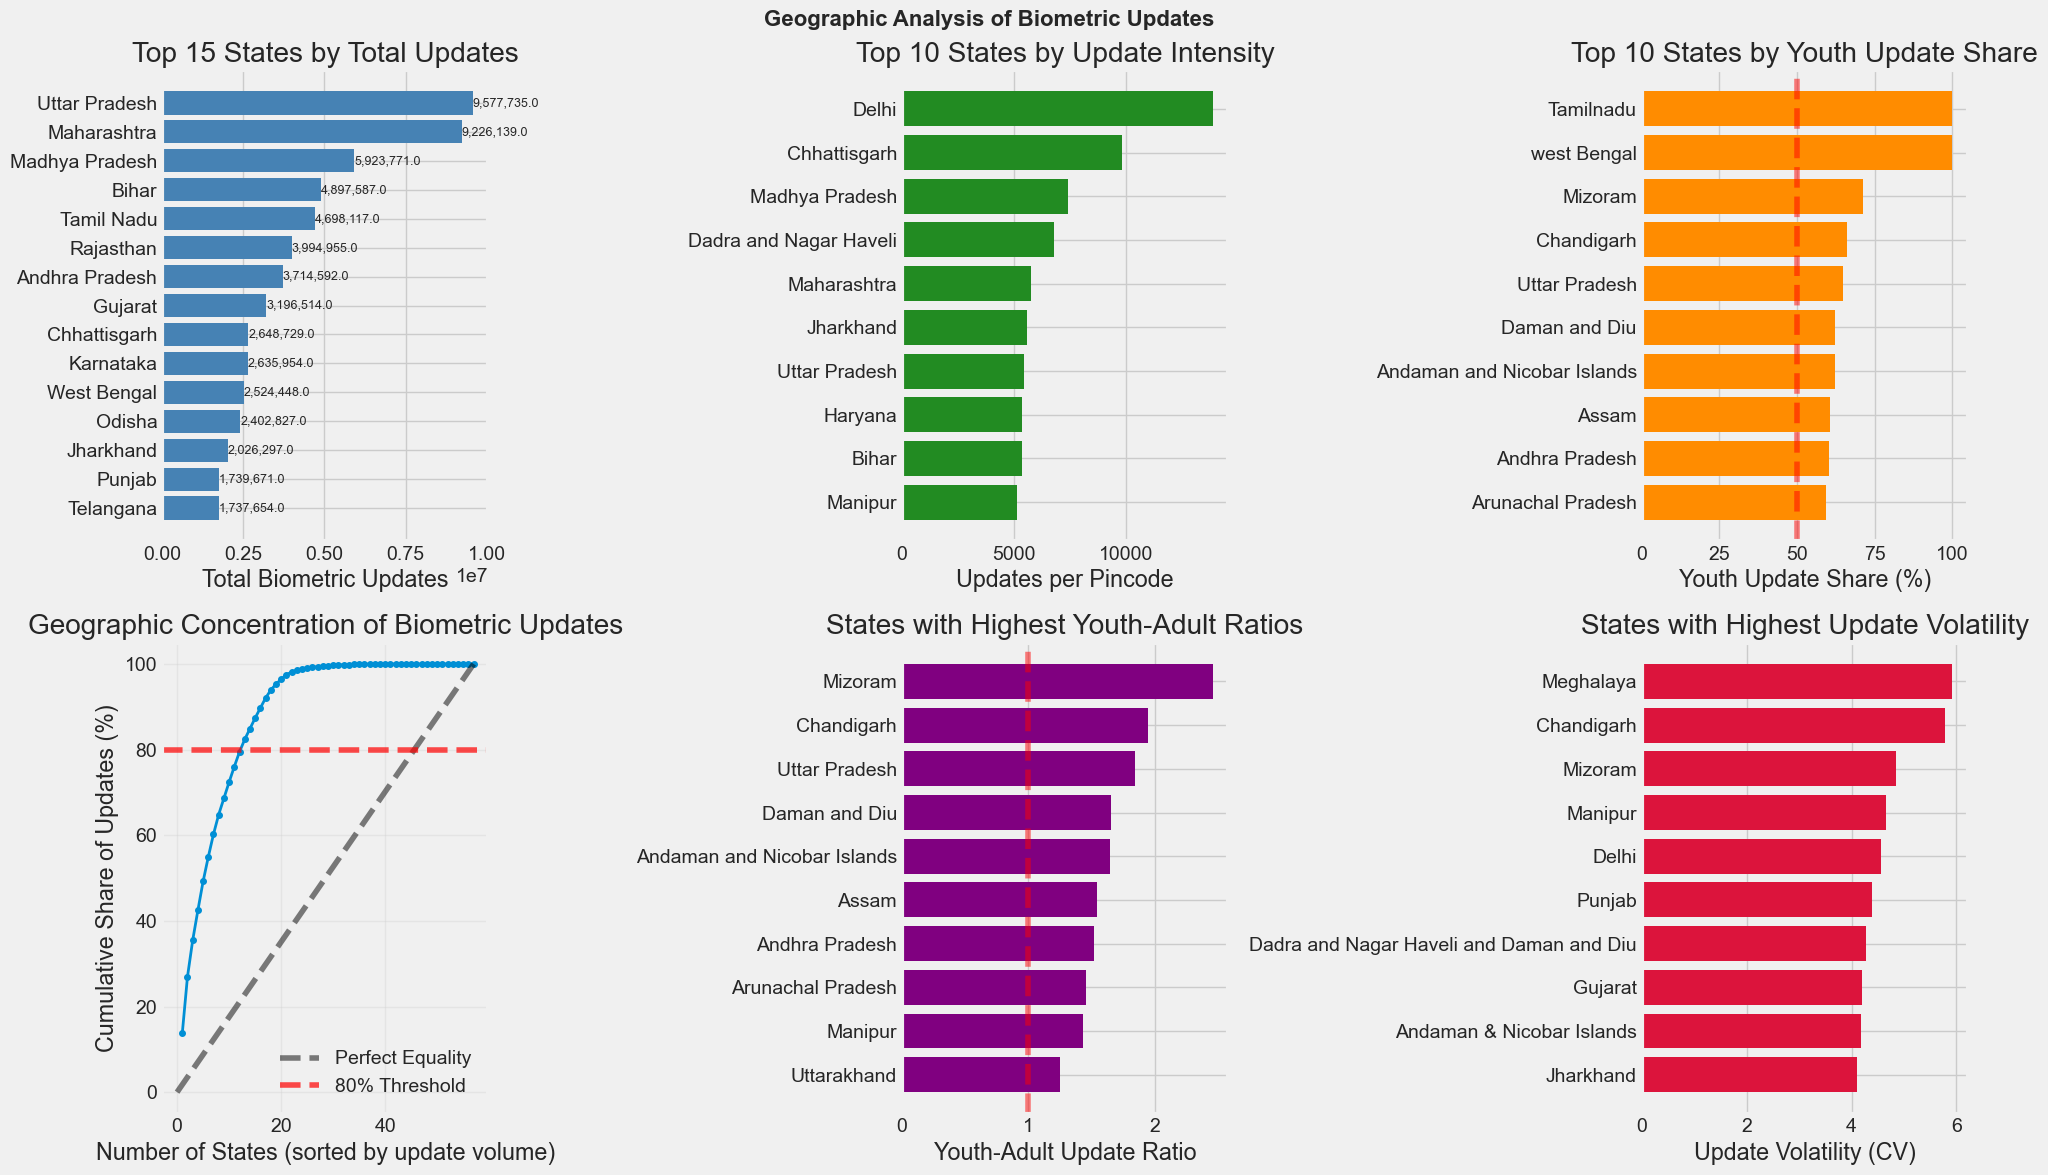


GEOGRAPHIC CONCENTRATION METRICS
Gini Coefficient: -0.756
   Interpretation: Relatively equal

HHI Index: 706
   Interpretation: Unconcentrated

Top 3 States Share: 35.4%
Top 5 States Share: 49.2%
States needed for 80% of updates: 13


In [48]:
# State-wise analysis
state_bio_analysis = df.groupby('state').agg({
    'total_bio_updates': ['sum', 'mean', 'std'],
    'bio_age_5_17': 'sum',
    'bio_age_17_': 'sum',
    'pincode': 'nunique',
    'district': 'nunique'
})

# Flatten multi-level columns
state_bio_analysis.columns = ['_'.join(col).strip() for col in state_bio_analysis.columns.values]
state_bio_analysis = state_bio_analysis.rename(columns={
    'total_bio_updates_sum': 'total_updates',
    'total_bio_updates_mean': 'avg_daily_updates',
    'total_bio_updates_std': 'std_daily_updates',
    'bio_age_5_17_sum': 'youth_updates',
    'bio_age_17__sum': 'adult_updates',
    'pincode_nunique': 'pincode_count',
    'district_nunique': 'district_count'
})

# Calculate derived metrics
state_bio_analysis['update_intensity'] = state_bio_analysis['total_updates'] / state_bio_analysis['pincode_count']
state_bio_analysis['youth_share'] = (state_bio_analysis['youth_updates'] / state_bio_analysis['total_updates']) * 100
state_bio_analysis['adult_share'] = (state_bio_analysis['adult_updates'] / state_bio_analysis['total_updates']) * 100
state_bio_analysis['youth_adult_ratio'] = state_bio_analysis['youth_updates'] / state_bio_analysis['adult_updates']
state_bio_analysis['update_volatility'] = state_bio_analysis['std_daily_updates'] / state_bio_analysis['avg_daily_updates']
state_bio_analysis['total_share'] = (state_bio_analysis['total_updates'] / state_bio_analysis['total_updates'].sum()) * 100

# Sort by total updates
state_bio_analysis = state_bio_analysis.sort_values('total_updates', ascending=False)

# Visualize geographic patterns
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Geographic Analysis of Biometric Updates', fontsize=16, fontweight='bold')

# Plot 1: Top 15 states by total updates
top_states = state_bio_analysis.head(15)
axes[0, 0].barh(top_states.index, top_states['total_updates'], color='steelblue')
axes[0, 0].set_xlabel('Total Biometric Updates')
axes[0, 0].set_title('Top 15 States by Total Updates')
axes[0, 0].invert_yaxis()
for i, (idx, row) in enumerate(top_states.iterrows()):
    axes[0, 0].text(row['total_updates'], i, f'{row["total_updates"]:,}', 
                   ha='left', va='center', fontsize=9)

# Plot 2: Update intensity (updates per pincode)
intensity_states = state_bio_analysis.sort_values('update_intensity', ascending=False).head(10)
axes[0, 1].barh(intensity_states.index, intensity_states['update_intensity'], color='forestgreen')
axes[0, 1].set_xlabel('Updates per Pincode')
axes[0, 1].set_title('Top 10 States by Update Intensity')
axes[0, 1].invert_yaxis()

# Plot 3: Youth share by state
youth_share_states = state_bio_analysis.sort_values('youth_share', ascending=False).head(10)
axes[0, 2].barh(youth_share_states.index, youth_share_states['youth_share'], color='darkorange')
axes[0, 2].set_xlabel('Youth Update Share (%)')
axes[0, 2].set_title('Top 10 States by Youth Update Share')
axes[0, 2].invert_yaxis()
axes[0, 2].axvline(x=50, color='r', linestyle='--', alpha=0.5)

# Plot 4: Geographic concentration (Lorenz curve)
sorted_shares = state_bio_analysis['total_share'].sort_values(ascending=False)
cumulative_shares = sorted_shares.cumsum()

axes[1, 0].plot(range(1, len(cumulative_shares) + 1), cumulative_shares.values, 
                marker='o', linewidth=2, markersize=4)
axes[1, 0].plot([0, len(cumulative_shares)], [0, 100], 'k--', alpha=0.5, label='Perfect Equality')
axes[1, 0].axhline(y=80, color='r', linestyle='--', alpha=0.7, label='80% Threshold')
axes[1, 0].set_xlabel('Number of States (sorted by update volume)')
axes[1, 0].set_ylabel('Cumulative Share of Updates (%)')
axes[1, 0].set_title('Geographic Concentration of Biometric Updates')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Youth-adult ratio
ratio_states = state_bio_analysis[state_bio_analysis['adult_updates'] > 1000].copy()
ratio_states = ratio_states.sort_values('youth_adult_ratio', ascending=False).head(10)
axes[1, 1].barh(ratio_states.index, ratio_states['youth_adult_ratio'], color='purple')
axes[1, 1].set_xlabel('Youth-Adult Update Ratio')
axes[1, 1].set_title('States with Highest Youth-Adult Ratios')
axes[1, 1].invert_yaxis()
axes[1, 1].axvline(x=1, color='r', linestyle='--', alpha=0.5, label='Equal Ratio')

# Plot 6: Update volatility
volatility_states = state_bio_analysis.sort_values('update_volatility', ascending=False).head(10)
axes[1, 2].barh(volatility_states.index, volatility_states['update_volatility'], color='crimson')
axes[1, 2].set_xlabel('Update Volatility (CV)')
axes[1, 2].set_title('States with Highest Update Volatility')
axes[1, 2].invert_yaxis()

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# Calculate geographic concentration metrics
def calculate_geographic_metrics(data_series):
    """Calculate various geographic concentration metrics"""
    sorted_data = data_series.sort_values(ascending=False)
    
    # Gini coefficient
    n = len(sorted_data)
    cum_values = sorted_data.cumsum().values
    gini = (n + 1 - 2 * np.sum(cum_values) / cum_values[-1]) / n if cum_values[-1] > 0 else 0
    
    # Herfindahl-Hirschman Index (HHI)
    hhi = ((sorted_data / sorted_data.sum()) ** 2).sum() * 10000 if sorted_data.sum() > 0 else 0
    
    # Top 3 and Top 5 shares
    top3_share = sorted_data.head(3).sum() / sorted_data.sum() if sorted_data.sum() > 0 else 0
    top5_share = sorted_data.head(5).sum() / sorted_data.sum() if sorted_data.sum() > 0 else 0
    
    # Number of states to reach 80%
    cum_pct = (sorted_data.cumsum() / sorted_data.sum() * 100)
    states_to_80 = (cum_pct <= 80).sum() + 1
    
    return {
        'gini_coefficient': gini,
        'hhi_index': hhi,
        'top3_share': top3_share,
        'top5_share': top5_share,
        'states_to_80pct': states_to_80
    }

geo_metrics = calculate_geographic_metrics(state_bio_analysis['total_updates'])

print("\n" + "="*80)
print("GEOGRAPHIC CONCENTRATION METRICS")
print("="*80)
print(f"Gini Coefficient: {geo_metrics['gini_coefficient']:.3f}")
print(f"   Interpretation: {'High inequality' if geo_metrics['gini_coefficient'] > 0.4 else 'Moderate inequality' if geo_metrics['gini_coefficient'] > 0.3 else 'Relatively equal'}")
print(f"\nHHI Index: {geo_metrics['hhi_index']:.0f}")
print(f"   Interpretation: {'Highly concentrated' if geo_metrics['hhi_index'] > 2500 else 'Moderately concentrated' if geo_metrics['hhi_index'] > 1500 else 'Unconcentrated'}")
print(f"\nTop 3 States Share: {geo_metrics['top3_share']:.1%}")
print(f"Top 5 States Share: {geo_metrics['top5_share']:.1%}")
print(f"States needed for 80% of updates: {geo_metrics['states_to_80pct']}")

## 5. Identifying Coverage Gaps

🔍 BIOMETRIC UPDATE GAP ANALYSIS RESULTS
National median (district-month): 5,134 updates
Total months analysed: 9

📊 Coverage Gap Distribution:
gap_category
Minor Gap            367
Severe Gap           353
Adequate Coverage    294
Moderate Gap          58
Name: count, dtype: int64

⚠️ Percentage of districts with SEVERE gaps: 32.9%

🚨 TOP 10 DISTRICTS WITH SEVERE BIOMETRIC UPDATE GAPS


,state,district,low_months_count,gap_category
1059,West Bengal,West Midnapore,9,Severe Gap
1005,West Bengal,Alipurduar,9,Severe Gap
991,Uttarakhand,Rudraprayag,9,Severe Gap
983,Uttarakhand,Champawat,9,Severe Gap
981,Uttarakhand,Bageshwar,9,Severe Gap
962,Uttar Pradesh,Prayagraj,9,Severe Gap
910,Uttar Pradesh,Bhadohi,9,Severe Gap
907,Uttar Pradesh,Barabanki,9,Severe Gap
898,Uttar Pradesh,Ayodhya,9,Severe Gap
888,Tripura,Unakoti,9,Severe Gap


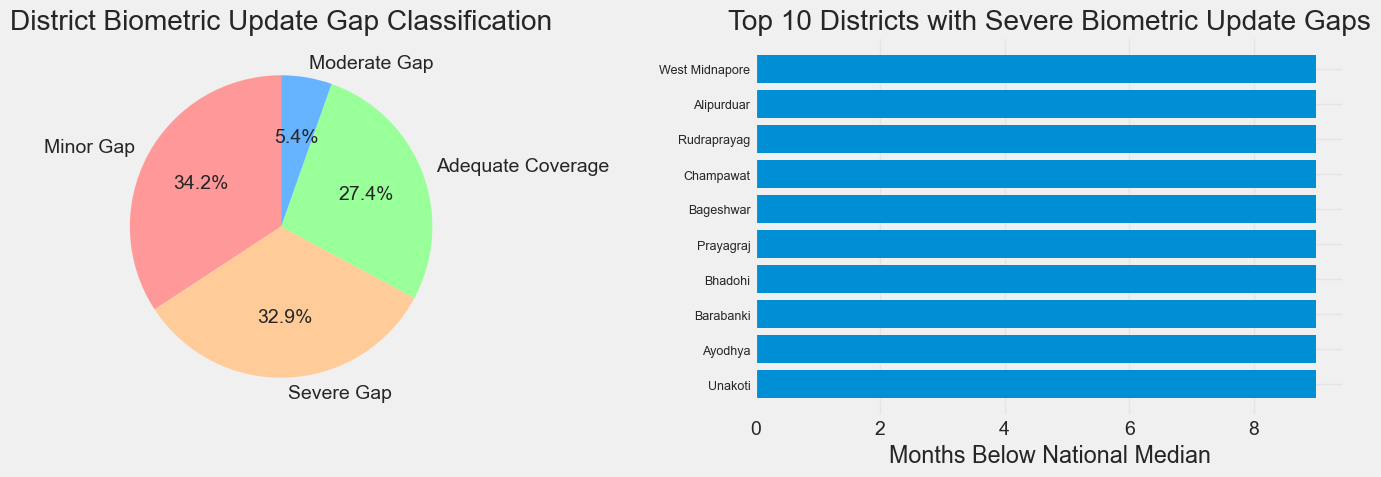

In [49]:
# Create total biometric updates
df['total_bio_updates'] = (
    df['bio_age_5_17'] + df['bio_age_17_']
)

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Aggregate to district–month level
district_month = df.groupby(
    ['state', 'district', 'year', 'month']
)['total_bio_updates'].sum().reset_index()

# National median of district-month biometric updates
national_median = district_month['total_bio_updates'].median()

district_month['below_median'] = (
    district_month['total_bio_updates'] < national_median
)

gap_analysis = (
    district_month
    .groupby(['state', 'district'])['below_median']
    .sum()
    .reset_index()
)

gap_analysis.columns = ['state', 'district', 'low_months_count']

total_months = district_month[['year', 'month']].drop_duplicates().shape[0]

def classify_coverage_gap(count, total_months):
    if count >= total_months * 0.75:
        return 'Severe Gap'
    elif count >= total_months * 0.50:
        return 'Moderate Gap'
    elif count >= 1:
        return 'Minor Gap'
    else:
        return 'Adequate Coverage'

gap_analysis['gap_category'] = gap_analysis['low_months_count'].apply(
    lambda x: classify_coverage_gap(x, total_months)
)

gap_dist = gap_analysis['gap_category'].value_counts()

print("🔍 BIOMETRIC UPDATE GAP ANALYSIS RESULTS")
print("=" * 65)
print(f"National median (district-month): {national_median:,.0f} updates")
print(f"Total months analysed: {total_months}")

print("\n📊 Coverage Gap Distribution:")
print(gap_dist)

print(
    f"\n⚠️ Percentage of districts with SEVERE gaps: "
    f"{gap_dist.get('Severe Gap', 0) / len(gap_analysis) * 100:.1f}%"
)

severe_gap_districts = (
    gap_analysis[gap_analysis['gap_category'] == 'Severe Gap']
    .sort_values('low_months_count', ascending=False)
)

print("\n🚨 TOP 10 DISTRICTS WITH SEVERE BIOMETRIC UPDATE GAPS")
display(severe_gap_districts.head(10))

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = ['#ff9999', '#ffcc99', '#99ff99', '#66b3ff']
ax1.pie(
    gap_dist.values,
    labels=gap_dist.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90
)
ax1.set_title('District Biometric Update Gap Classification')

# Bar chart – top severe gap districts
top_gap = severe_gap_districts.head(10)
ax2.barh(range(len(top_gap)), top_gap['low_months_count'])
ax2.set_yticks(range(len(top_gap)))
ax2.set_yticklabels(top_gap['district'], fontsize=9)
ax2.set_xlabel('Months Below National Median')
ax2.set_title('Top 10 Districts with Severe Biometric Update Gaps')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('biometric_update_gap_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Anomaly detection using Z-score


ANOMALY DETECTION IN BIOMETRIC UPDATES
Statistical anomalies (Z-score > 3): 23422 records
Temporal anomalies (3σ from rolling mean): 45150 records
Age ratio anomalies: 32412 records
Total anomaly rate: 1.26%


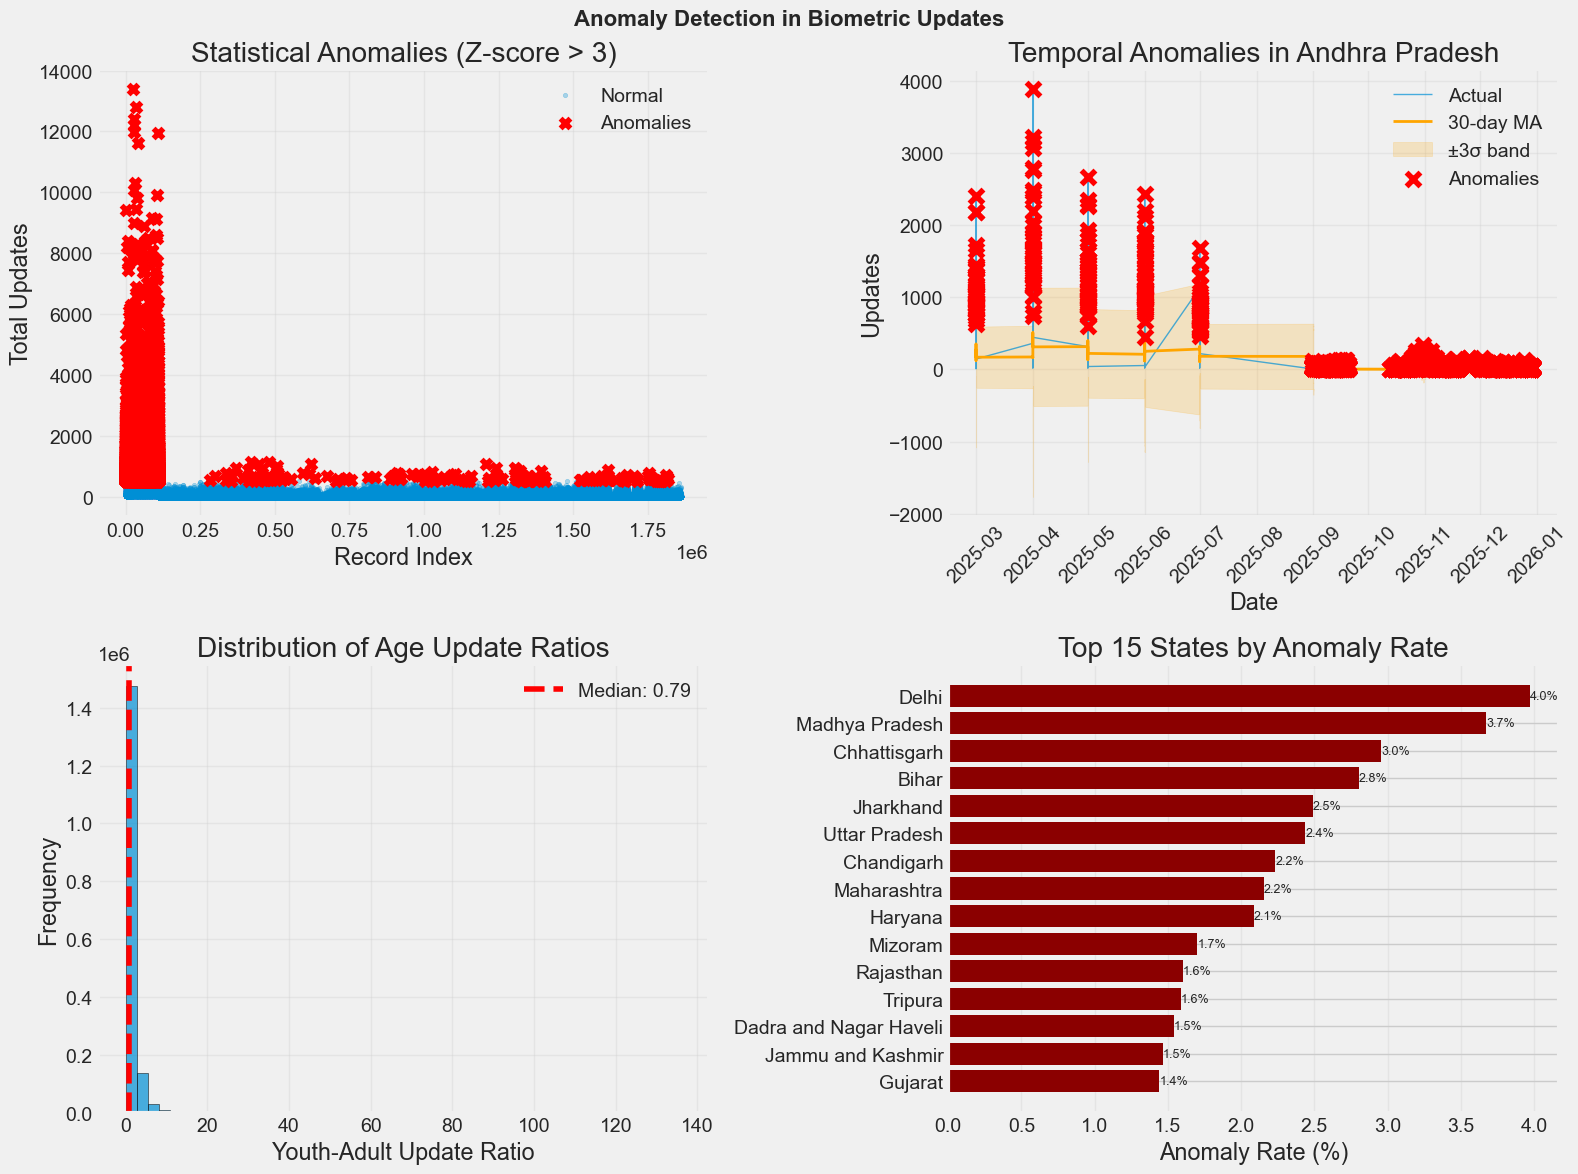


Top 10 anomalous records:
             date           state          district  total_bio_updates  bio_age_5_17  bio_age_17_    z_score
24461  2025-04-01           Delhi       South Delhi              13381          5861         7520  82.199847
36088  2025-04-01           Delhi  North West Delhi              12805          5180         7625  78.651524
28311  2025-04-01           Delhi       South Delhi              12395          5411         6984  76.125807
28235  2025-04-01           Delhi        West Delhi              12204          5003         7201  74.949193
28233  2025-04-01           Delhi  North East Delhi              11987          6921         5066  73.612411
107288 2025-07-01     Maharashtra        Aurangabad              11941          4469         7472  73.329038
40099  2025-04-01   Uttar Pradesh         Moradabad              11612          7657         3955  71.302305
32284  2025-04-01           Delhi  North West Delhi              10300          4112         6188  63

In [59]:
# Advanced anomaly detection
from scipy import stats
print("\n" + "="*80)
print("ANOMALY DETECTION IN BIOMETRIC UPDATES")
print("="*80)

# Method 1: Statistical outlier detection (Z-score)
df['z_score'] = np.abs(stats.zscore(df['total_bio_updates'].fillna(0)))
statistical_anomalies = df[df['z_score'] > 3]

# Method 2: Temporal anomaly detection (rolling statistics)
df_sorted = df.sort_values(['state', 'date'])
df_sorted['rolling_mean'] = df_sorted.groupby('state')['total_bio_updates'].transform(
    lambda x: x.rolling(window=30, min_periods=5).mean()
)
df_sorted['rolling_std'] = df_sorted.groupby('state')['total_bio_updates'].transform(
    lambda x: x.rolling(window=30, min_periods=5).std()
)
df_sorted['is_temporal_anomaly'] = (
    (df_sorted['total_bio_updates'] > df_sorted['rolling_mean'] + 3*df_sorted['rolling_std']) |
    (df_sorted['total_bio_updates'] < df_sorted['rolling_mean'] - 3*df_sorted['rolling_std'])
)
temporal_anomalies = df_sorted[df_sorted['is_temporal_anomaly']]

# Method 3: Age ratio anomalies
df['age_ratio'] = df['bio_age_5_17'] / df['bio_age_17_'].replace(0, np.nan)
age_ratio_zscore = np.abs(stats.zscore(df['age_ratio'].fillna(0)))
ratio_anomalies = df[age_ratio_zscore > 3]

print(f"Statistical anomalies (Z-score > 3): {len(statistical_anomalies)} records")
print(f"Temporal anomalies (3σ from rolling mean): {len(temporal_anomalies)} records")
print(f"Age ratio anomalies: {len(ratio_anomalies)} records")
print(f"Total anomaly rate: {(len(statistical_anomalies) / len(df)) * 100:.2f}%")

# Visualize anomalies
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Anomaly Detection in Biometric Updates', fontsize=16, fontweight='bold')

# Plot 1: Statistical anomalies
axes[0, 0].scatter(df.index, df['total_bio_updates'], 
                  alpha=0.3, s=10, label='Normal')
axes[0, 0].scatter(statistical_anomalies.index, statistical_anomalies['total_bio_updates'],
                  color='red', s=50, label='Anomalies', marker='x')
axes[0, 0].set_xlabel('Record Index')
axes[0, 0].set_ylabel('Total Updates')
axes[0, 0].set_title('Statistical Anomalies (Z-score > 3)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Temporal anomalies (example for top state)
if len(temporal_anomalies) > 0:
    top_state_anomalies = temporal_anomalies[temporal_anomalies['state'] == temporal_anomalies['state'].mode()[0]]
    state_data = df_sorted[df_sorted['state'] == temporal_anomalies['state'].mode()[0]]
    
    axes[0, 1].plot(state_data['date'], state_data['total_bio_updates'], 
                    label='Actual', alpha=0.7, linewidth=1)
    axes[0, 1].plot(state_data['date'], state_data['rolling_mean'], 
                    label='30-day MA', linewidth=2, color='orange')
    axes[0, 1].fill_between(state_data['date'],
                           state_data['rolling_mean'] - 3*state_data['rolling_std'],
                           state_data['rolling_mean'] + 3*state_data['rolling_std'],
                           alpha=0.2, color='orange', label='±3σ band')
    axes[0, 1].scatter(top_state_anomalies['date'], top_state_anomalies['total_bio_updates'],
                      color='red', s=100, label='Anomalies', marker='x', zorder=5)
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Updates')
    axes[0, 1].set_title(f'Temporal Anomalies in {temporal_anomalies["state"].mode()[0]}')
    axes[0, 1].legend()
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'No temporal anomalies detected', 
                    ha='center', va='center', fontsize=12)

# Plot 3: Age ratio distribution
axes[1, 0].hist(df['age_ratio'].replace([np.inf, -np.inf], np.nan).dropna(), 
               bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=df['age_ratio'].median(), color='r', linestyle='--', 
                  label=f'Median: {df["age_ratio"].median():.2f}')
axes[1, 0].set_xlabel('Youth-Adult Update Ratio')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Age Update Ratios')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Geographic anomaly heatmap
anomaly_by_state = df.groupby('state').apply(
    lambda x: len(x[x['z_score'] > 3]) / len(x) * 100
).sort_values(ascending=False).head(15)

axes[1, 1].barh(anomaly_by_state.index, anomaly_by_state.values, color='darkred')
axes[1, 1].set_xlabel('Anomaly Rate (%)')
axes[1, 1].set_title('Top 15 States by Anomaly Rate')
axes[1, 1].invert_yaxis()
for i, (state, rate) in enumerate(anomaly_by_state.items()):
    axes[1, 1].text(rate, i, f'{rate:.1f}%', ha='left', va='center', fontsize=9)
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# Analyze anomalous patterns
if len(statistical_anomalies) > 0:
    print("\nTop 10 anomalous records:")
    print(statistical_anomalies[['date', 'state', 'district', 'total_bio_updates', 
                                 'bio_age_5_17', 'bio_age_17_', 'z_score']]
          .sort_values('z_score', ascending=False).head(10).to_string())

## 9. Predictive Models for Biometric Updates

## 9.1 Predictive Analytics and Biometric Update Demand Forecasting (Pipeline-Based)

"""
This module implements a **production-grade machine learning pipeline** that integrates 
automated feature engineering, categorical encoding, and ensemble-based regression to 
forecast biometric update demand. The pipeline-based architecture ensures **reproducibility, 
scalability, and consistency** between training and inference, eliminating manual 
preprocessing steps and reducing the risk of data leakage. The model leverages temporal 
and geographic attributes to identify key drivers of biometric update demand.

**Key outputs** include short-term update forecasts, feature importance diagnostics, 
seasonal patterns, and compliance risk segmentation at state and district levels.

---
## Technical Usage: Pipeline Inputs and Outputs

### Input Requirements
The predictive pipeline expects a pandas DataFrame with the following minimum columns:
- `date` (datetime): Biometric update date
- `state` (string): State/UT name  
- `district` (string): District name
- `bio_age_5_17` (int): Biometric updates (5–17 years)
- `bio_age_17_` (int): Biometric updates (17+ years)

The target variable is **computed internally**:
total_biometric_updates = bio_age_5_17 + bio_age_17_

---
### Automated Feature Engineering (Pipeline-Generated)
All feature transformations are handled **inside the pipeline**.

### Temporal Features (Auto-Derived)
- `day_of_week`
- `day_of_month` 
- `month`
- `quarter`
- `year`
- `is_weekend`

### Geographic Features
- `state` → ordinal-encoded
- `district` → ordinal-encoded

> No manual feature creation or encoding is required during prediction.

---
## Pipeline Architecture
    InputDataFrame
       ↓
    DateFeatureEngineering
       ↓
    CategoricalEncoding+FeaturePassthrough
       ↓
    RandomForestRegressionModel
       ↓
    PredictedBiometricUpdateOutput

---
## Model Training
    rf_pipeline.fit(X_train, y_train)

**Input:**
- `X_train`: DataFrame containing `date`, `state`, and `district`
- `y_train`: `total_biometric_updates`

**Output:**
- Fully trained end-to-end prediction pipeline

---
## Model Inference (Prediction)
    predictions = rf_pipeline.predict(X_new)

**Input:**
- `X_new`: DataFrame with columns `date`, `state`, and `district`

**Output:**
- Numeric predictions of `total_biometric_updates`

The pipeline automatically:
- Extracts temporal features
- Encodes geographic identifiers  
- Applies the trained regression model

---
## Future Date & Location Prediction
To generate forecasts for unseen dates or locations:

1. Provide a DataFrame containing future `date`, `state`, and `district`
2. Pass the DataFrame directly to the pipeline's `predict()` method

    rf_pipeline.predict(future_data)

No manual preprocessing, encoding, or feature selection is required.

---
## Model Outputs
- Predicted daily biometric update volumes (`total_biometric_updates`)
- Performance metrics: MAE, RMSE, R²
- Feature importance scores derived from the Random Forest model
- State-level compliance trend indicators
- District-level risk segmentation for biometric update backlog

---
## Operational Notes
- All preprocessing steps are embedded within the pipeline and reused consistently at inference time
- The model produces reliable predictions only for **known states and districts** present during training
- Forecasts are **decision-support estimates** for biometric update planning
- Pipeline-based design enables seamless deployment for compliance monitoring

---
## Practical Applications
- **Update Forecasting:** Predict daily, weekly, or monthly biometric update demand
- **Compliance Planning:** Support staffing and infrastructure for lifecycle management  
- **Risk Identification:** Flag districts with high backlog or low update rates
- **Targeted Interventions:** Identify regions needing biometric update awareness campaigns
- **Policy Support:** Enable data-driven planning for biometric transition compliance
"""

In [51]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Display pipeline diagram
from sklearn import set_config
set_config(display='diagram')

In [52]:
#### 9.1.1 Custom Feature Builder for Biometric Updates

from sklearn.base import BaseEstimator, TransformerMixin

class DateFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['day_of_week'] = X['date'].dt.dayofweek
        X['day_of_month'] = X['date'].dt.day
        X['month'] = X['date'].dt.month
        X['quarter'] = X['date'].dt.quarter
        X['year'] = X['date'].dt.year
        X['is_weekend'] = (X['day_of_week'] >= 5).astype(int)
        return X

In [53]:
#### 9.1.2 Column Transformer (Encoding)

numeric_features = [
    'day_of_week', 'day_of_month', 'month',
    'quarter', 'year', 'is_weekend'
]

categorical_features = ['state', 'district']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

In [54]:
#### 9.1.3 Full Random Forest Pipeline for Biometric Updates

rf_pipeline = Pipeline(steps=[
    ('date_features', DateFeatureEngineer()),
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        random_state=42,
        n_jobs=-1
    ))
])

# Display pipeline
rf_pipeline

Pipeline(steps=[('date_features', DateFeatureEngineer()),
                ('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['state', 'district']),
                                                 ('num', 'passthrough',
                                                  ['day_of_week',
                                                   'day_of_month', 'month',
                                                   'quarter', 'year',
                                                   'is_weekend'])])),
                ('model',
                 RandomForestRegressor(max_depth=15, n_jobs=-1,
                                       random_state=42))])

In [55]:
# Assume 'df' is your biometric updates DataFrame
# Create target variable
df['total_biometric_updates'] = df['bio_age_5_17'] + df['bio_age_17_']

# Prepare features and target
X = df[['date', 'state', 'district']]
y = df['total_biometric_updates']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False  # No shuffle for time series
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 1488886
Testing samples: 372222


In [56]:
#### 9.1.4 Training the Biometric Updates Model

rf_pipeline.fit(X_train, y_train)
print("Biometric Updates Model trained successfully!")

Biometric Updates Model trained successfully!


In [57]:
#### 9.1.5 Model Evaluation

y_train_pred = rf_pipeline.predict(X_train)
y_test_pred = rf_pipeline.predict(X_test)

print("BIOMETRIC UPDATES MODEL PERFORMANCE")
print("=" * 40)
print("\nTRAINING SET")
print("-" * 20)
print(f"MAE: {mean_absolute_error(y_train, y_train_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.2f}")
print(f"R²: {r2_score(y_train, y_train_pred):.4f}")

print("\nTESTING SET")
print("-" * 20)
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_test_pred):.4f}")

BIOMETRIC UPDATES MODEL PERFORMANCE

TRAINING SET
--------------------
MAE: 28.22
RMSE: 123.33
R²: 0.5335

TESTING SET
--------------------
MAE: 13.08
RMSE: 24.55
R²: 0.1803


FEATURE IMPORTANCE FOR BIOMETRIC UPDATES
        feature  importance
4         month    0.554096
0         state    0.248000
1      district    0.173691
2   day_of_week    0.011470
5       quarter    0.008471
7    is_weekend    0.002968
3  day_of_month    0.001304
6          year    0.000000


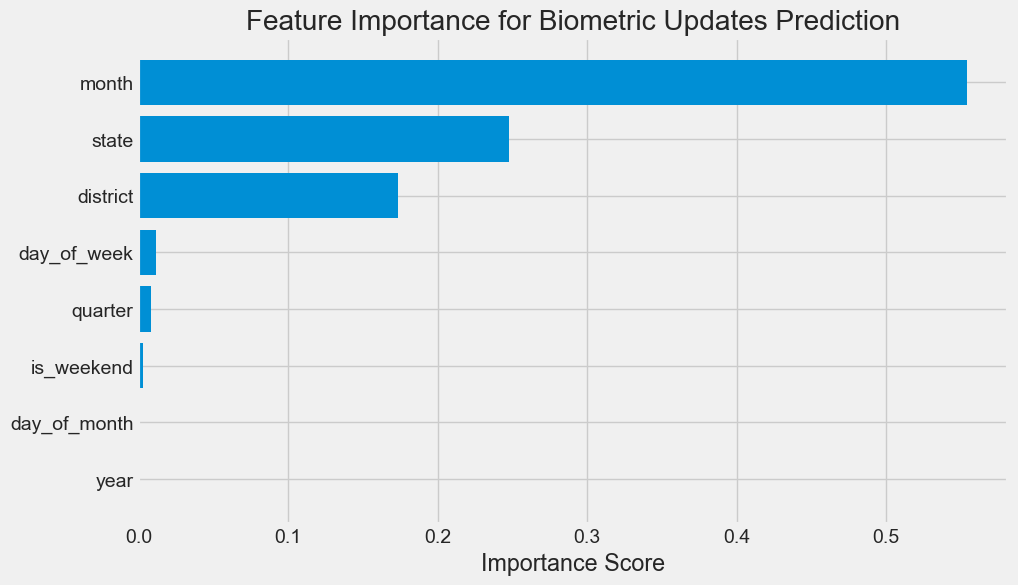

In [58]:
#### 9.1.6 Feature Importance Analysis

# Get feature names
feature_names = categorical_features + numeric_features

# Extract feature importances
importances = rf_pipeline.named_steps['model'].feature_importances_

# Create importance dataframe
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("FEATURE IMPORTANCE FOR BIOMETRIC UPDATES")
print("=" * 40)
print(feature_importance_df)

# Optional: Visualize feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importance for Biometric Updates Prediction')
plt.gca().invert_yaxis()
plt.show()